In [ ]:
!which python

In [ ]:
import struct 
struct.calcsize("P")*8

In [ ]:
# !pip list

In [ ]:
# !pip install openpyxl

In [ ]:
# pd.set_option('display.max_rows', sub_pressure_df.shape[0]+1)

In [2]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from matplotlib import rcParams
from operator import itemgetter
from typing import Callable, Dict, List, Set, Tuple
from scipy.signal import savgol_filter
import math  

In [3]:
# from util import load_data_from_txt, calculate_derivative,convert_timestamp2hour,produce_pressure_4metrics
# from util import calculate_points_interval
from baseline import detect_breakpoints_startPoint, detect_breakpoints, detect_breakpoints_2, detect_breakpoints_3,detect_breakpoints_4,detect_breakpoints_startPoint2
from plot import plot_nonDenoised_VS_Denoised,PlotNSave
from data_load_N_preprocess import LoadNPreprocessData
# from plot2 import group_index, plot_breakpoints,plot_4_metrics,plot_4_metrics_details,plot_detection_statistics,plot_histogram

# Experiment Setup

In [4]:
#experiment setup
ground_truth_temp=[2249,  2467,  2805,[2875, 2876],3100,3561,3994,[4228, 4232],4753,4895, 5297,5436,5985,[6543, 6547], 7249,[7544, 7545],7946,[8362, 8364],9025,[9607, 9608],10149,10216, 10528,[10801, 10804],11340,  11479,12363,[13039, 13040],13868, 14086,14774,15341,16098,16619,[17589, 17590],18435,19643,19764,20021,20349,20701,21030,21974,22186,22710,23220,24215,24685,25717,26006,26656, 26759,27023,[27316,27327],27773,[27966,27970],28322,28497,28832,29115]
# ground_truth=[]

colum_names   ={"pressure":{"time":"Elapsed time",
                             "measure":"Data",
                             "first_order_derivative":"first_order_derivative",
                             "second_order_derivative":"second_order_derivative"},
                "rate":{"time":"Elapsed time",
                        "measure":"Liquid rate"}}
data_inOneRow=1000
pressure_filePath="../data_input/EAGE_Shchipanov_2017/Pressure.txt"
rate_filePath="../data_input/EAGE_Shchipanov_2017/Rate.txt"

In [ ]:
ground_truth=[]
for point in ground_truth_temp: 
    if "list" in str(type(point)):
        ground_truth.append(math.ceil(sum(point)/len(point)))
    else:
        ground_truth.append(point)
                     
print("len(ground_truth):",len(ground_truth))

In [ ]:
ground_truth_buildUp=[point for index, point in enumerate(ground_truth) if index%2!=0]
ground_truth_buildUp

# Raw data

In [ ]:
processed_data=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names, 
                 use_SG_smoothing=False)
pressure_df=processed_data.pressure_df
rate_df=processed_data.rate_df

display(pressure_df)
display(rate_df)
# display(processed_data.pressureNrate_df)

first_order_derivative=pressure_df["first_order_derivative"]
second_order_derivative=pressure_df["second_order_derivative"]

In [ ]:
# #plot histogram
# data=pressure_df["first_order_derivative"]
# xlabel="first_order_derivative"
# ylabel="data count"
# title='histogram--real field data'
# plot_histogram(data, xlabel, ylabel,title)

In [ ]:
# breakpoints_detected=detect_breakpoints(first_order_derivative)
# print(len(breakpoints_detected))
# print(breakpoints_detected)

In [ ]:
def display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names):
    rate_time=rate_df[colum_names["rate"]["time"]]
    sub_rate_df=rate_df.loc[(rate_time >= start_time) & (rate_time <= end_time)]
    pd.set_option('display.max_rows', sub_rate_df.shape[0]+1)
    display(sub_rate_df)
    pressure_time=pressure_df[colum_names["pressure"]["time"]]
    sub_pressure_df=pressure_df.loc[(pressure_time >= start_time) & (pressure_time <= end_time)]
    pd.set_option('display.max_rows', sub_pressure_df.shape[0]+1)
    display(sub_pressure_df)
    return (sub_pressure_df,sub_rate_df)

start_time=2150
end_time=2155
sub_pressure_df,sub_rate_df=display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names) 

In [ ]:
sub_pressure_df.index
timegap=[]
for i in sub_pressure_df.index[0:-2]:
    tg=sub_pressure_df.loc[i+1,"Elapsed time"] -sub_pressure_df.loc[i,"Elapsed time"]
    timegap.append(tg)
timegap 

In [ ]:
max([3, 7, -10], key=abs)
def get_metrics(pressure_df:pd.DataFrame,
                    rate_df:pd.DataFrame
               )->(List[float],List[float],List[float],List[float],List[float],List[float]):
        pressure_time=pressure_df[colum_names["pressure"]["time"]]
        pressure_measure=pressure_df[colum_names["pressure"]["measure"]]
        pressure_first_order_derivative=pressure_df[colum_names["pressure"]["first_order_derivative"]]
        pressure_second_order_derivative=pressure_df[colum_names["pressure"]["second_order_derivative"]]
        rate_time=rate_df[colum_names["rate"]["time"]]
        rate_measure=rate_df[colum_names["rate"]["measure"]]
        return (pressure_time, pressure_measure, pressure_first_order_derivative,pressure_second_order_derivative,rate_time,rate_measure)

start_time=900
end_time=920
(sub_pressure_df,sub_rate_df)=display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names)    
sub_pressure_first_order_derivative=sub_pressure_df[colum_names["pressure"]["first_order_derivative"]]    
# print(sub_pressure_first_order_derivative)
# sub_pressure_first_order_derivative=list(sub_pressure_first_order_derivative)
print(max(sub_pressure_first_order_derivative, key=abs))
maxabs=max(sub_pressure_first_order_derivative, key=abs)
sub_pressure_df.index[sub_pressure_df[colum_names["pressure"]["first_order_derivative"]] == maxabs].tolist()

## Plot ground truth

In [ ]:
#plot ground truth
#plot & save
data_inOneRow=1200
filename_toSave="../data_output/RealField_Ground_truth.pdf"
plot_name="RealField_Ground_truth"
plot_whole=False
plot_details=True
plot_statistics=False
PlotNSave(pressure_df,
          rate_df,
          ground_truth,
          [],
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

## plot ground truth buildUp

In [ ]:
#plot ground truth
#plot & save
data_inOneRow=1200
filename_toSave=""
plot_name="RealField_Ground_truth"
plot_whole=False
plot_details=True
plot_statistics=False
PlotNSave(pressure_df,
          rate_df,
          ground_truth_buildUp,
          [],
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

In [ ]:
# breakpoints_detected=detect_breakpoints_2(first_order_derivative,second_order_derivative)
# print(len(breakpoints_detected))
# # print(breakpoints_detected)

## Baseline method

In [ ]:
#baseline method
noise_threshold=1.7
breakpoints_detected_3=detect_breakpoints_3(first_order_derivative,second_order_derivative,noise_threshold)
print(len(breakpoints_detected_3))
# print(breakpoints_detected)

In [ ]:
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_baseline_method_RawData.pdf"
plot_name="RealField_baseline_method_RawData"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df,
          rate_df,
          breakpoints_detected_3,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

# S-G smoothing

In [ ]:
processed_data_denoised=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names, 
                 use_SG_smoothing=True)
pressure_df_denoised=processed_data_denoised.pressure_df
rate_df_denoised=processed_data_denoised.rate_df

# display(pressure_df_denoised)
# display(rate_df_denoised)
# display(processed_data_denoised.pressureNrate_df)

first_order_derivative_denoised=pressure_df_denoised["first_order_derivative"]
second_order_derivative_denoised=pressure_df_denoised["second_order_derivative"]
std_1_denoised=statistics.stdev(first_order_derivative_denoised)
std_2_denoised=statistics.stdev(second_order_derivative_denoised)
print(f"std_1:{std_1_denoised},std_2:{std_2_denoised}")
plot_nonDenoised_VS_Denoised(pressure_df.iloc[0:400,:],pressure_df_denoised.iloc[0:400,:],colum_names)

In [ ]:


# calculate_points_interval(0,10,pressure_df_denoised,colum_names)

In [ ]:
# #S-G filter startPoint
# noise_threshold=3
# breakpoints_detected_startPoint=detect_breakpoints_startPoint(first_order_derivative,noise_threshold)
# print("len(breakpoints_detected)",len(breakpoints_detected_startPoint))

## Start point method

In [ ]:
#S-G filter startPoint2
noise_threshold=3
breakpoints_detected_startPoint2=detect_breakpoints_startPoint2(first_order_derivative_denoised,second_order_derivative_denoised,noise_threshold)
print("len(breakpoints_detected)",len(breakpoints_detected_startPoint2))
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_StartPoint_method_SGSmoothing.pdf"
plot_name="RealField_StartPoint_method_SGSmoothing"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df_denoised,
          rate_df_denoised,
          breakpoints_detected_startPoint2,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

## Baseline method

In [ ]:
#S-G filter baseline
noise_threshold=0.01
breakpoints_detected_3SG=detect_breakpoints_3(first_order_derivative_denoised,second_order_derivative_denoised,noise_threshold)
print(len(breakpoints_detected_3SG))
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_baseline_method_SGSmoothing.pdf"
plot_name="RealField_baseline_method_SGSmoothing"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df_denoised,
          rate_df_denoised,
          breakpoints_detected_3SG,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

In [ ]:
#S-G filter detect algorithm 4
# noise_threshold=0.3
# close_zero_threshold=0.5
# window_time_duration=8
# breakpoints_detected_4SG=detect_breakpoints_4(pressure_df_denoised,colum_names, noise_threshold,window_time_duration,close_zero_threshold)
# print(len(breakpoints_detected_4SG))


## denoise first order derivative

In [12]:
processed_data_denoised=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names, 
                 use_SG_smoothing=True)
pressure_df_denoised=processed_data_denoised.pressure_df
rate_df_denoised=processed_data_denoised.rate_df

first_order_derivative_denoised=pressure_df_denoised["first_order_derivative"]
second_order_derivative_denoised=pressure_df_denoised["second_order_derivative"]
std_1_denoised=statistics.stdev(first_order_derivative_denoised)
std_2_denoised=statistics.stdev(second_order_derivative_denoised)
print(f"std_1:{std_1_denoised},std_2:{std_2_denoised}")
# plot_nonDenoised_VS_Denoised(pressure_df.iloc[0:400,:],pressure_df_denoised.iloc[0:400,:],colum_names)

---load data from 'txt' or 'xlsx' files...
check the time type
---denoising data using S-G smoothing...
---The first & second order derivative has been calculated and appended to pressure dataframe
std_1:217.076859984311,std_2:26067.263415502584


In [13]:
# pressure_df_denoised[colum_names["pressure"]["first_order_derivative"]]=savgol_filter(first_order_derivative_denoised,399,3)
# first_order_derivative_denoised=pressure_df_denoised["first_order_derivative"]

138.21652203818655 26067.263415502584
88
---initializing...
---plotting...
No ground truth defined


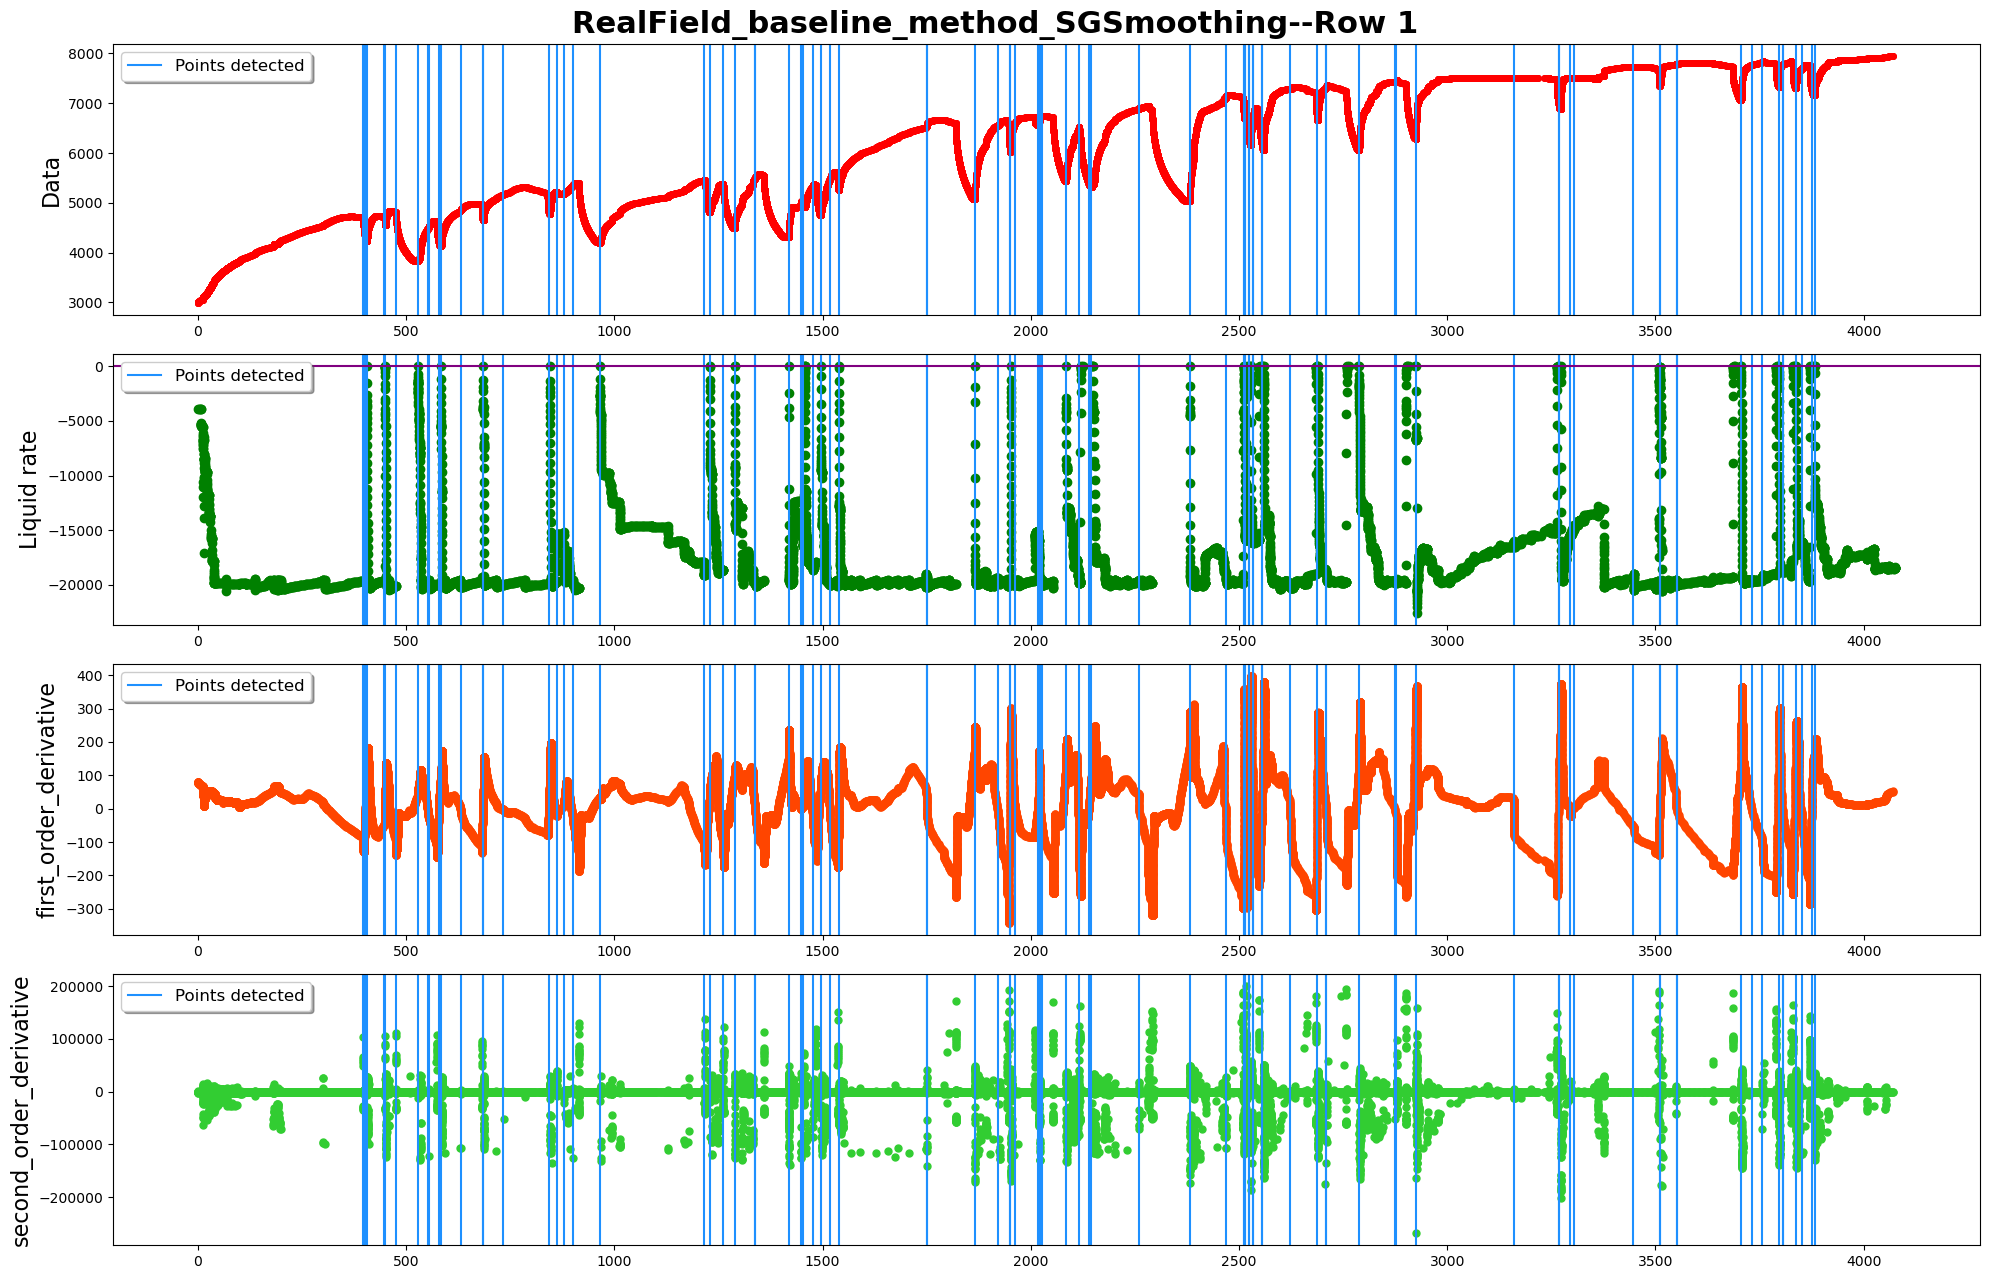

detected 88 points as breakpoints
The plot is devided into 30 rows
------row 1-----detected points:[]


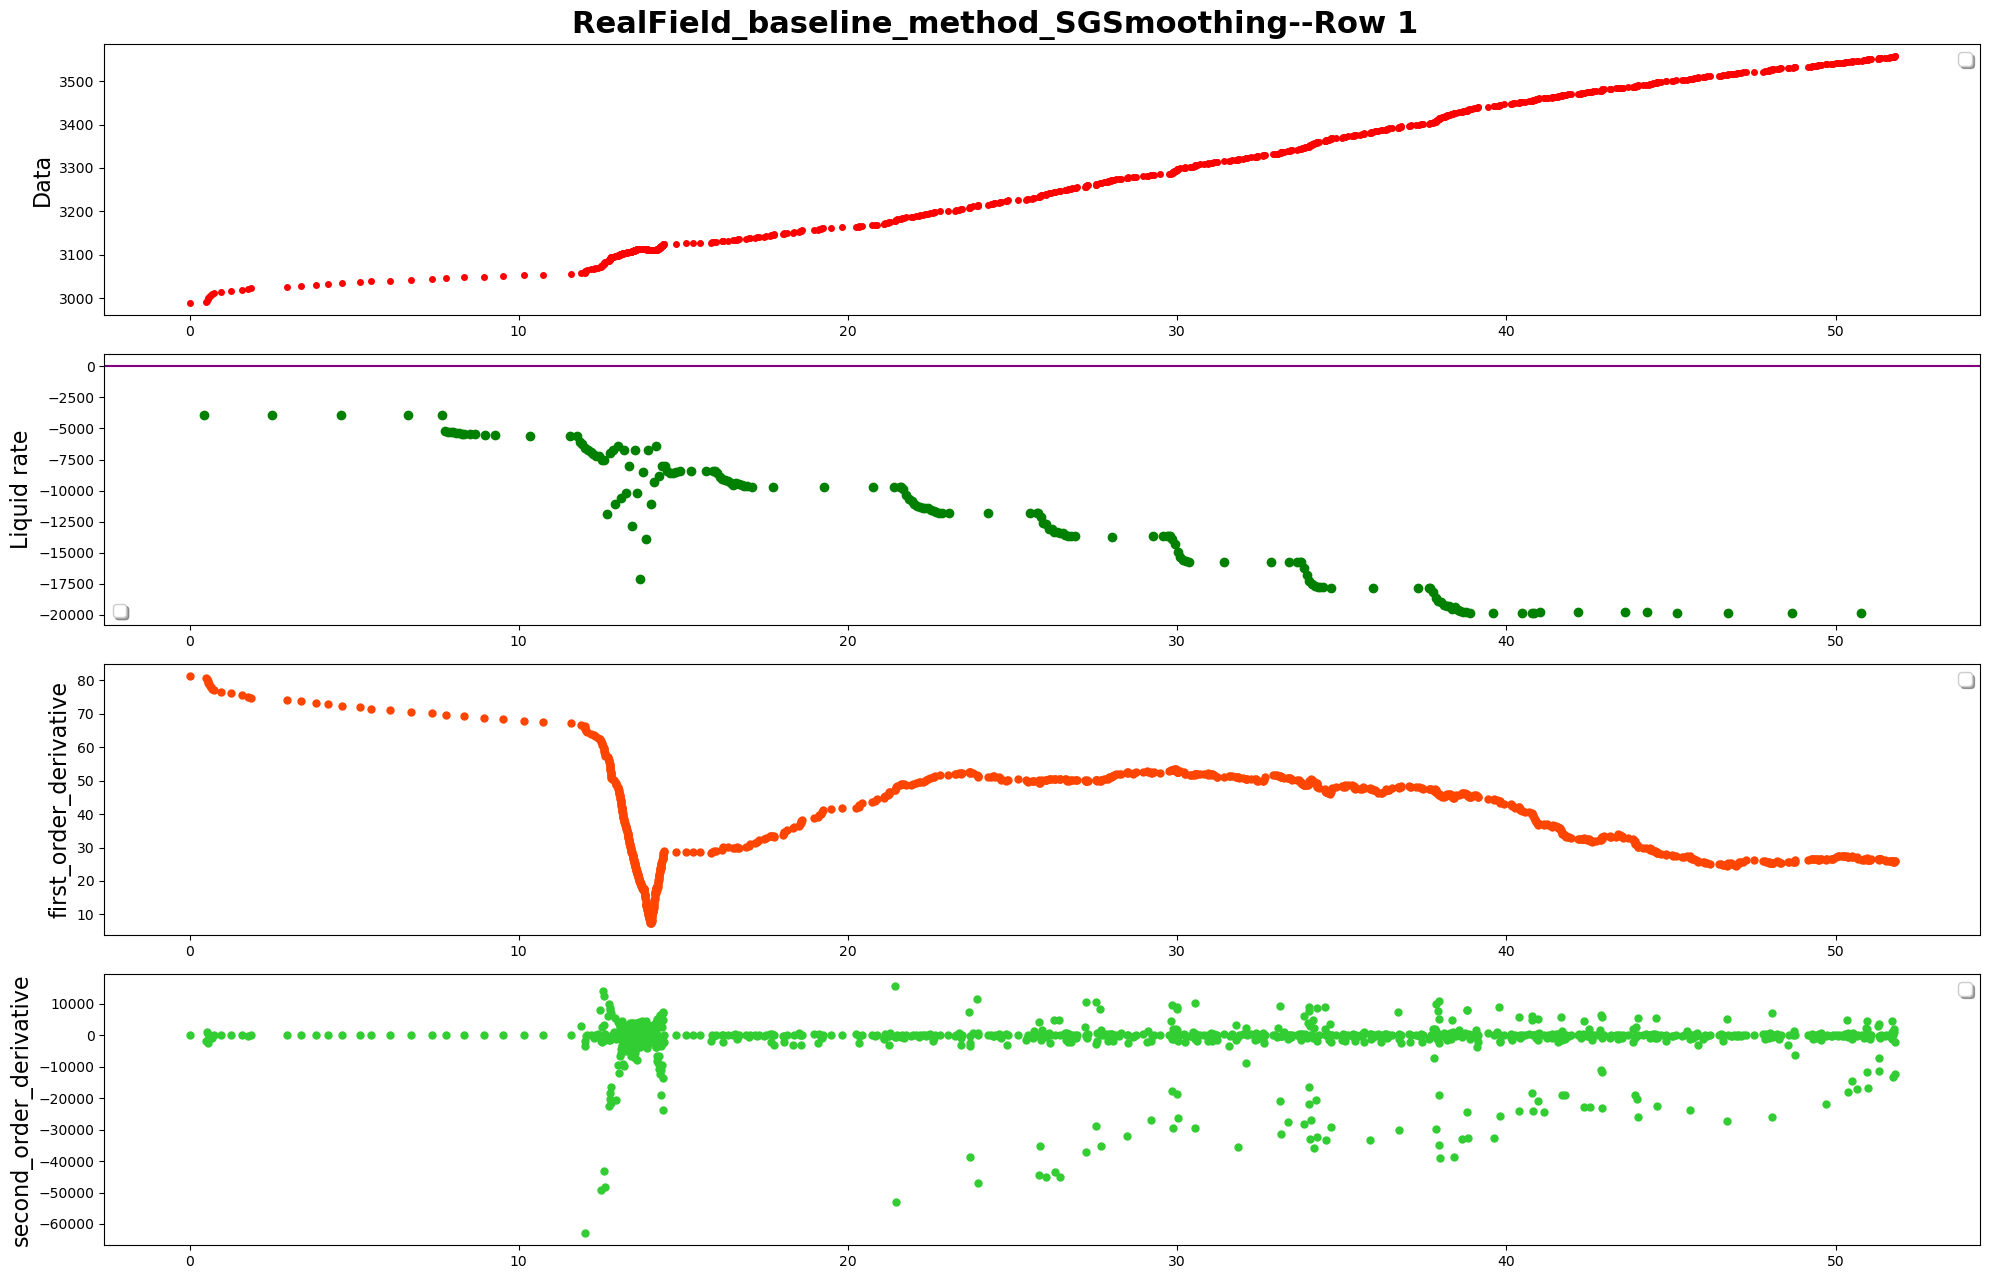

------row 2-----detected points:[]


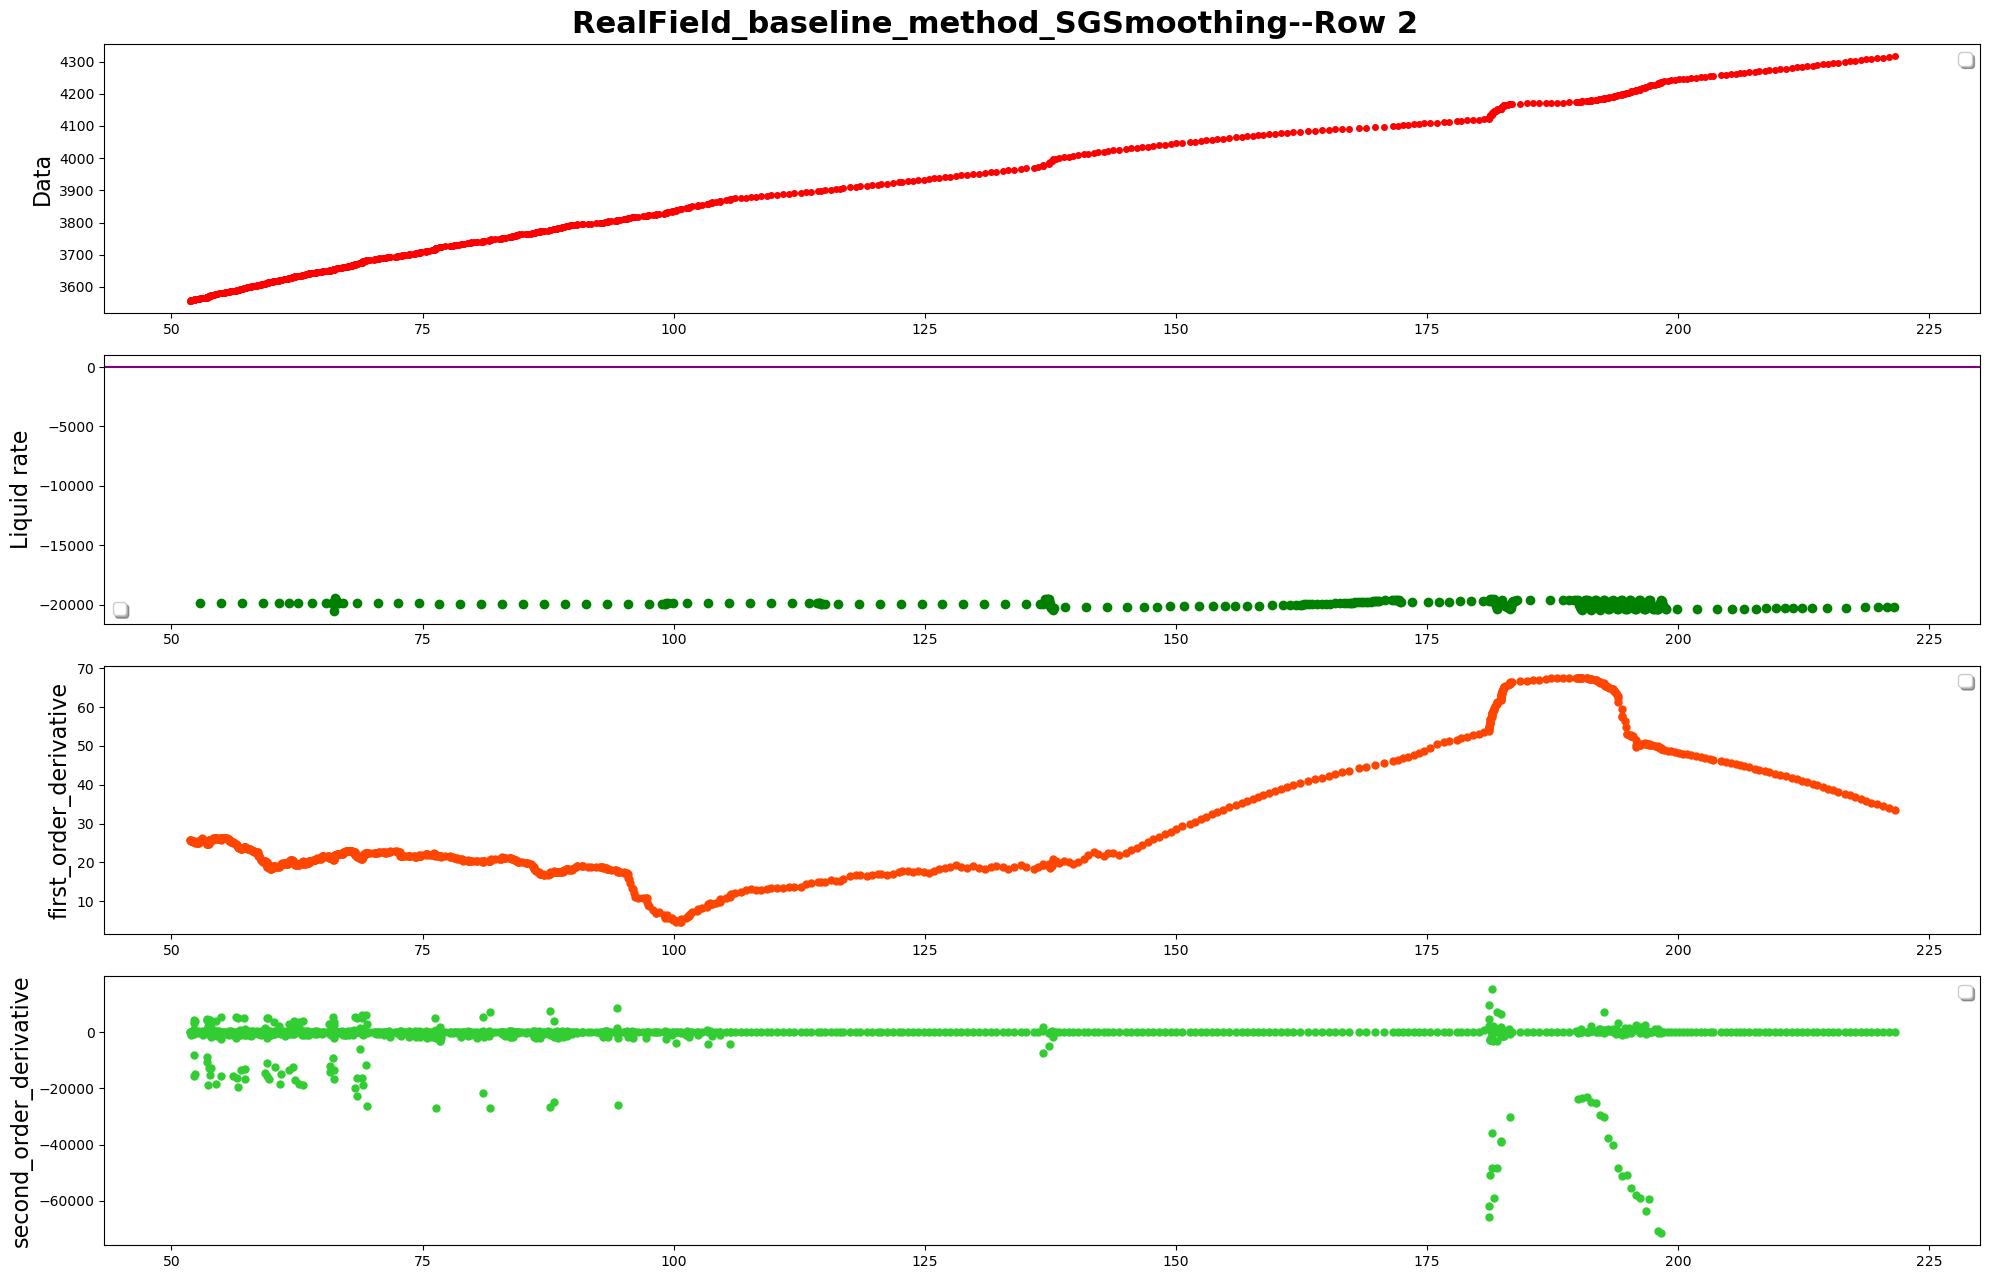

------row 3-----detected points:[2247, 2420, 2466, 2803, 2844]


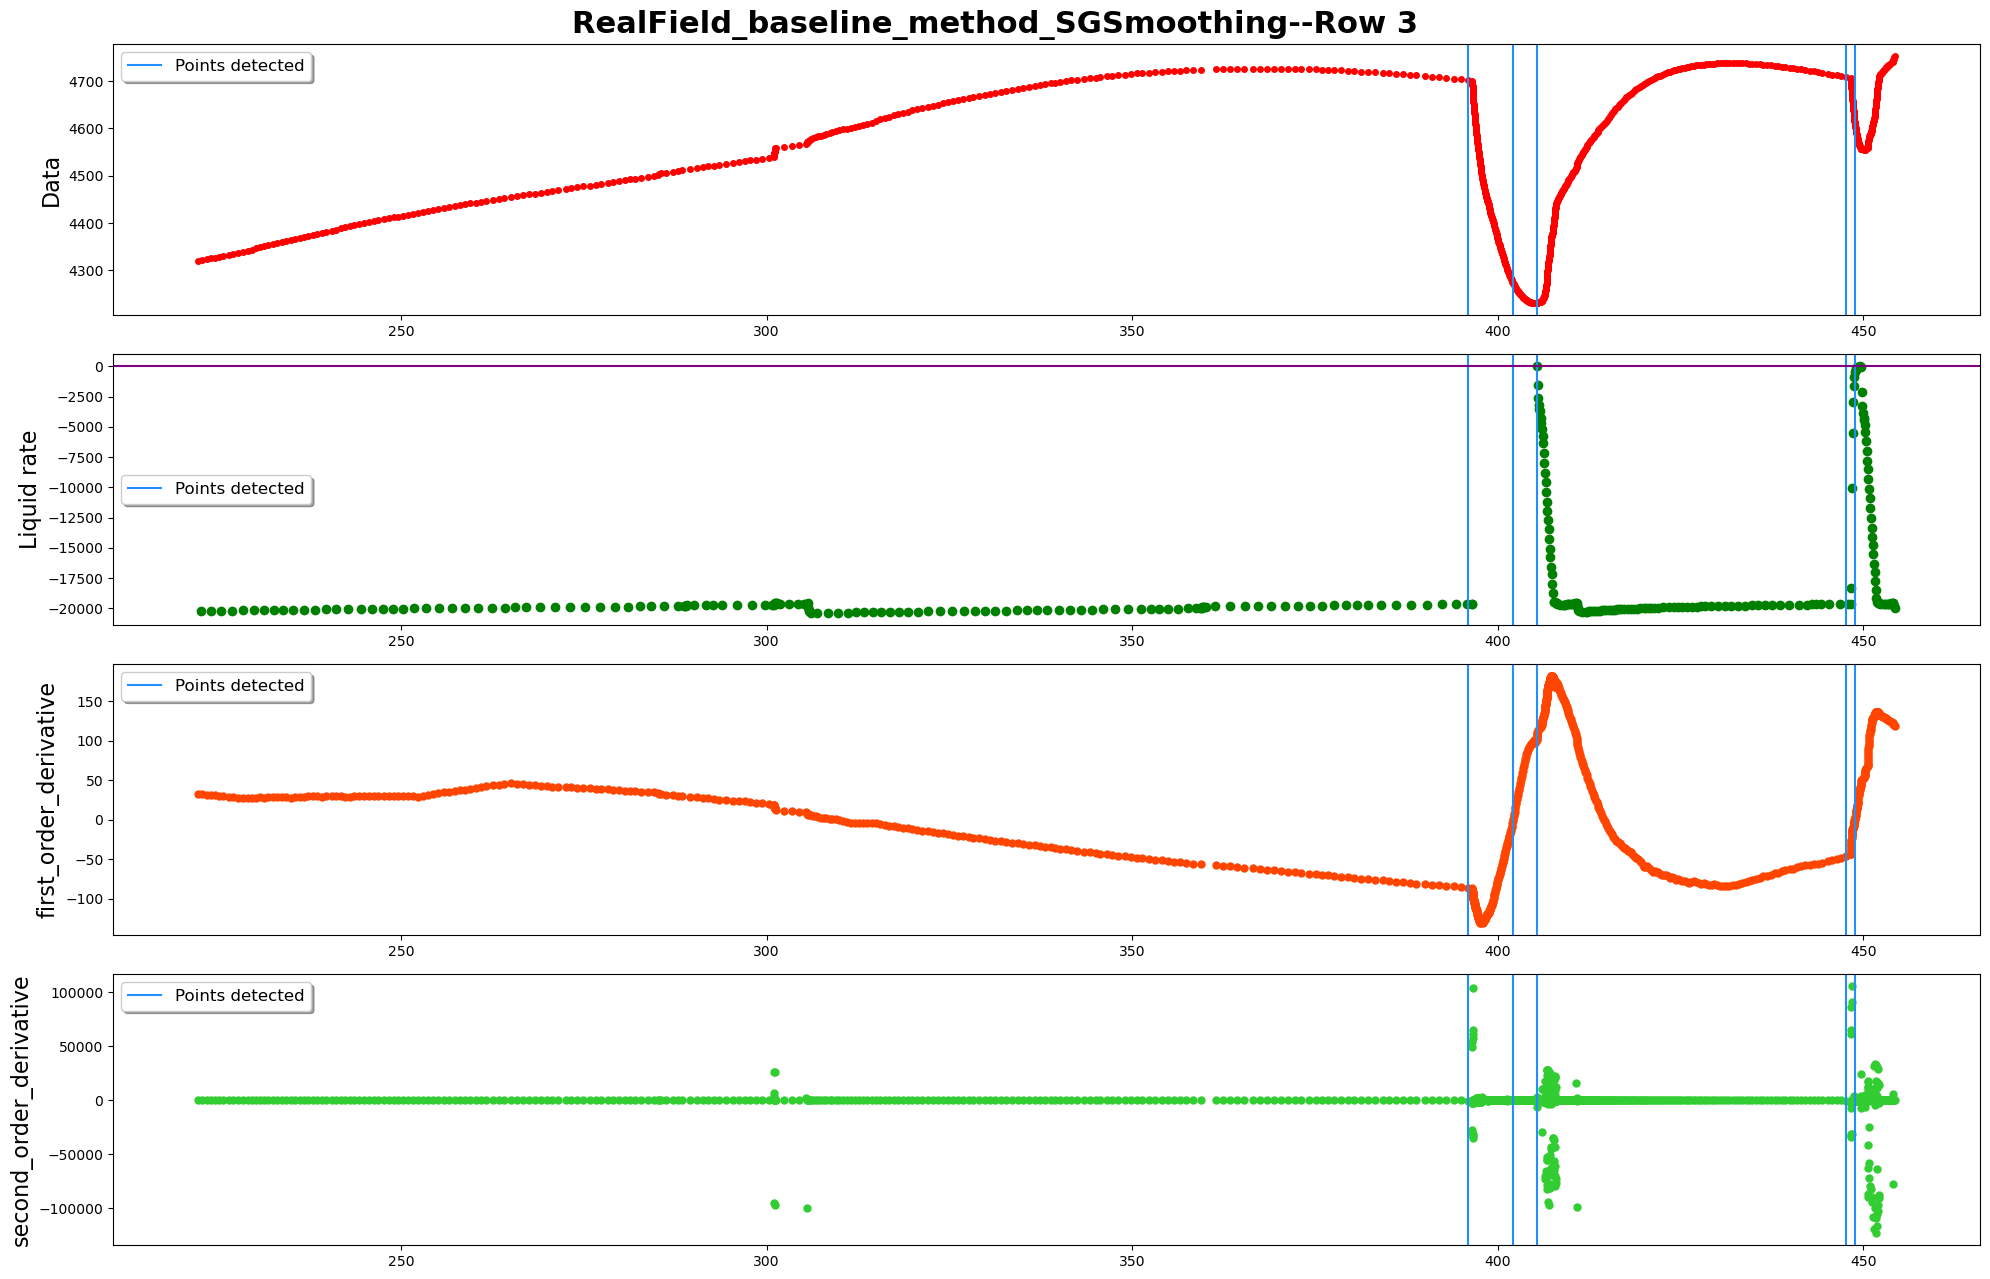

------row 4-----detected points:[3094, 3560, 3881, 3903]


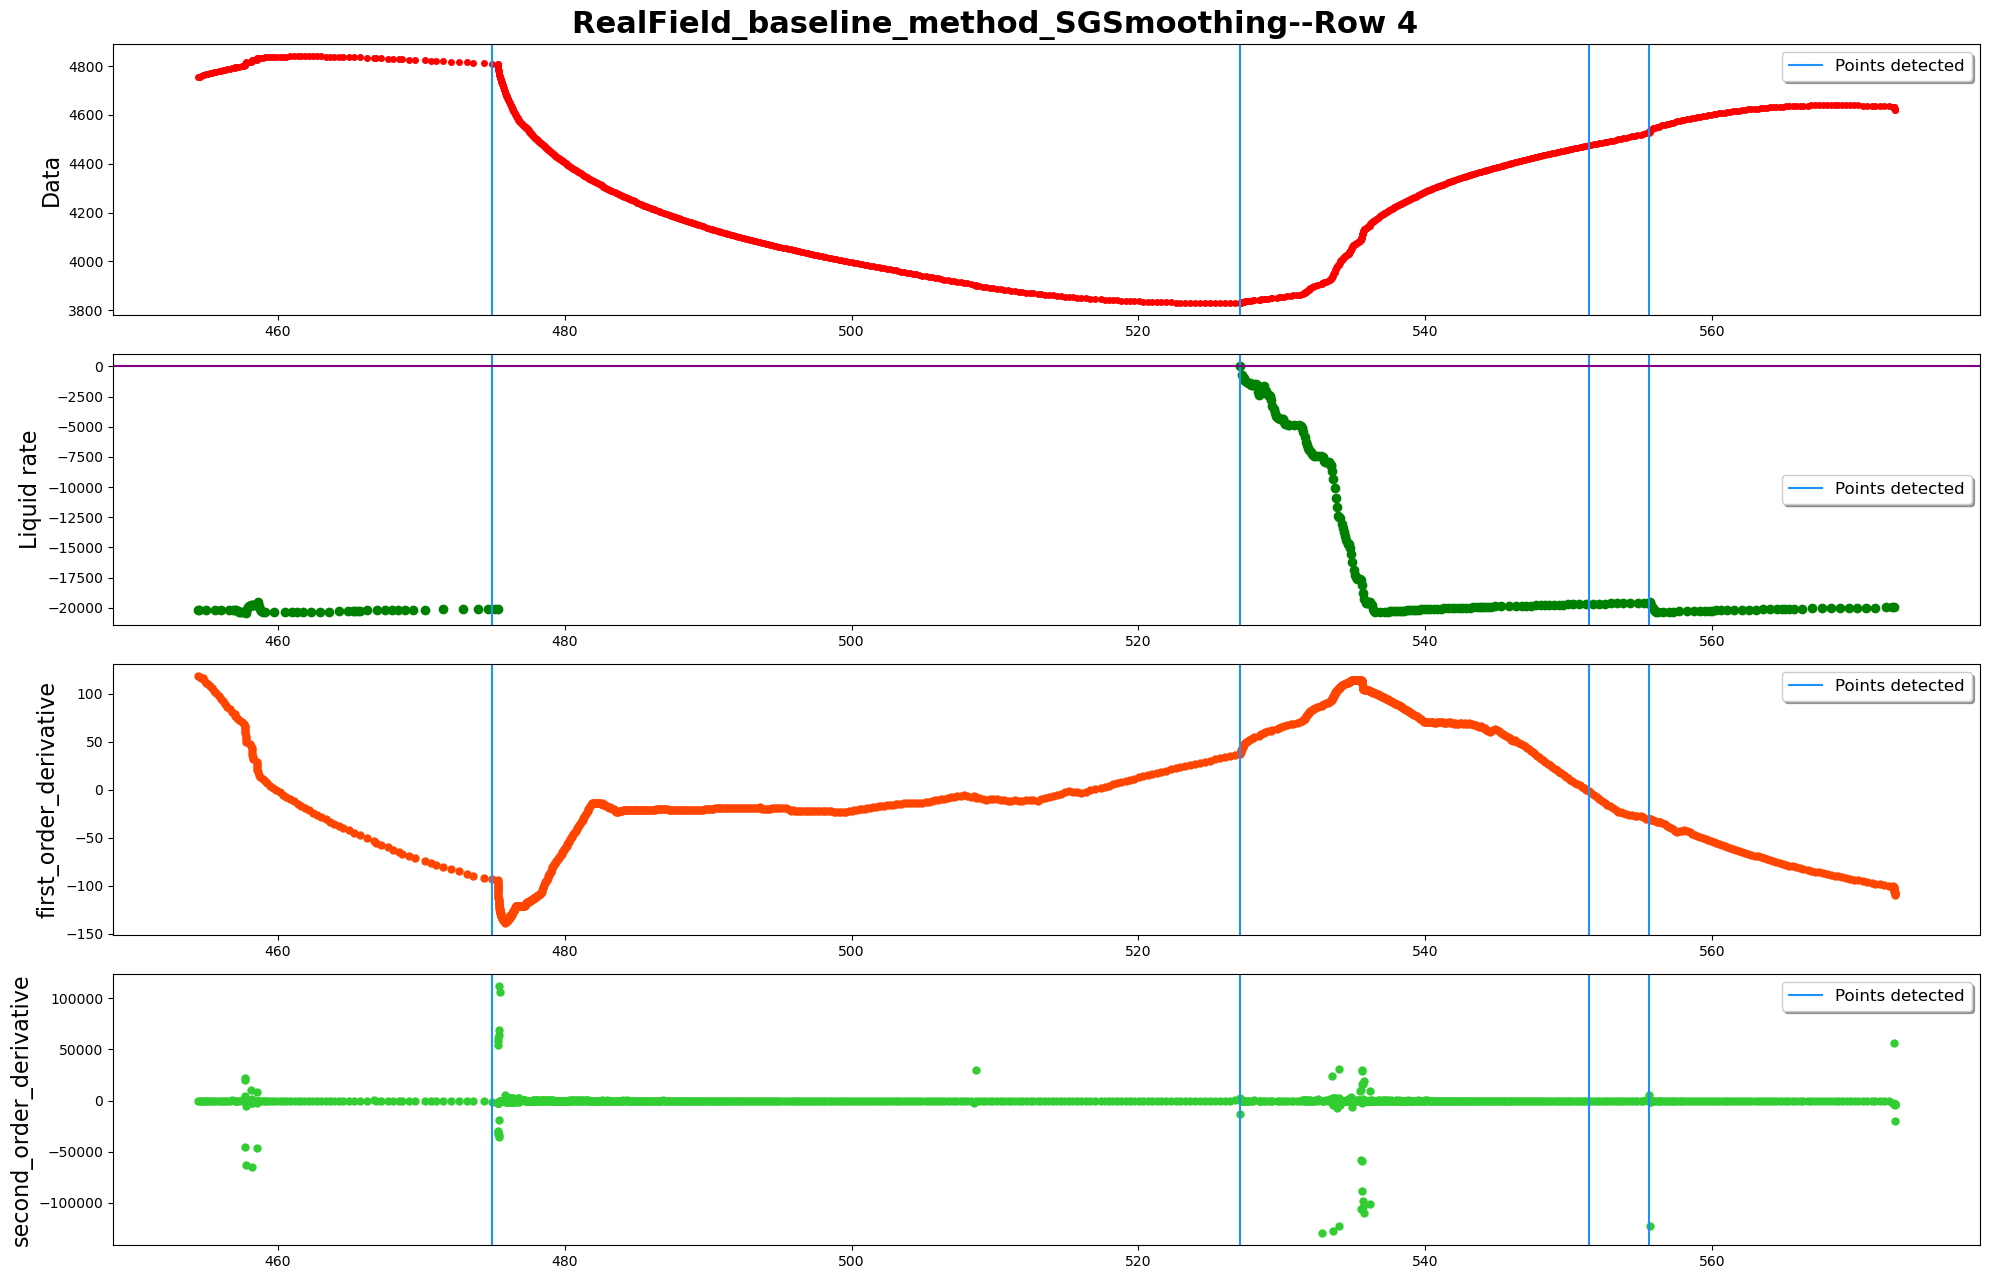

------row 5-----detected points:[4178, 4228, 4654, 4870, 4889]


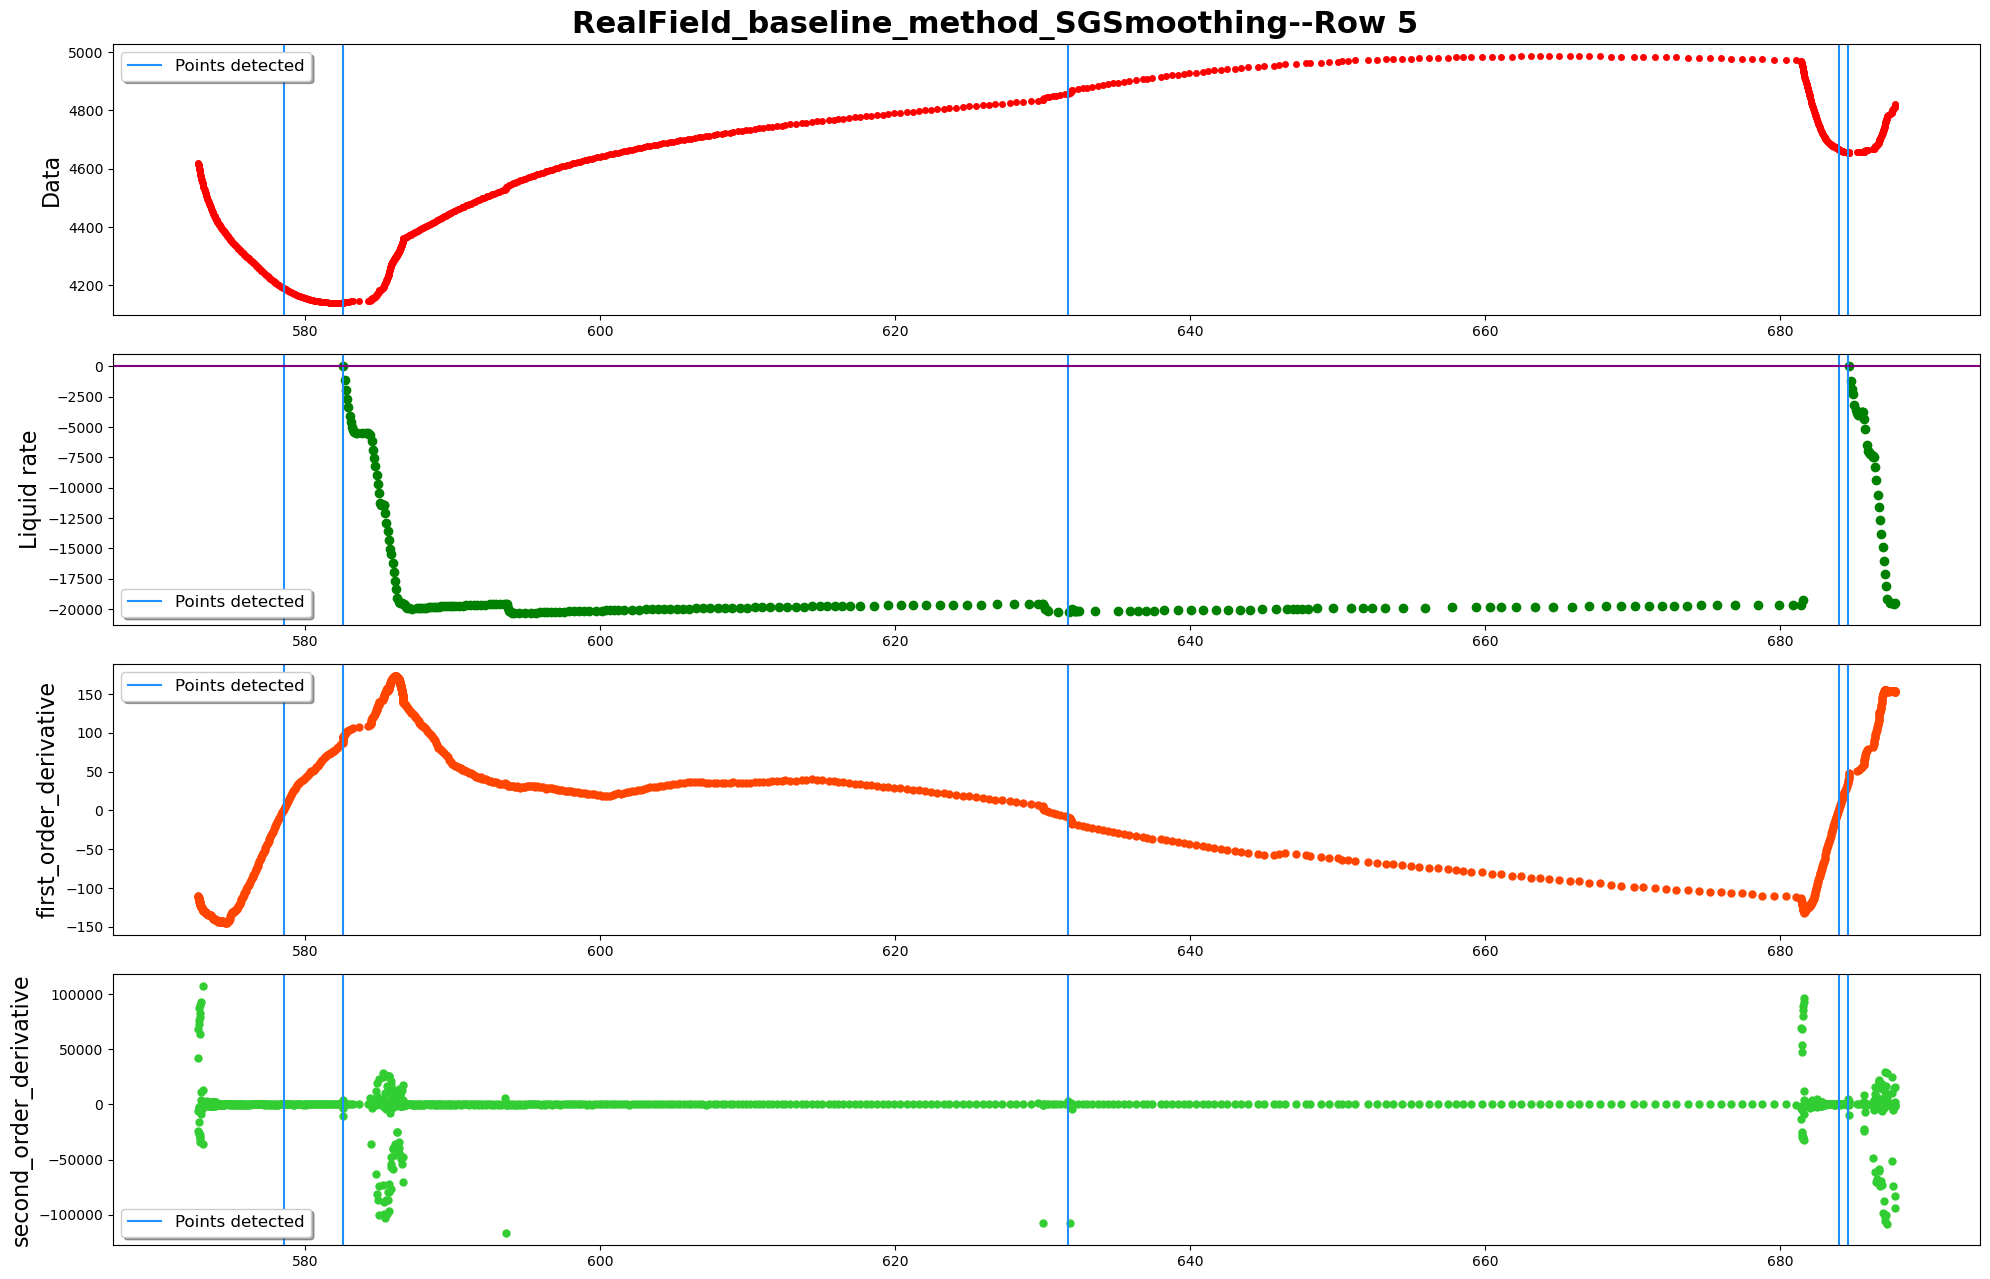

------row 6-----detected points:[5177, 5395, 5694, 5764, 5919]


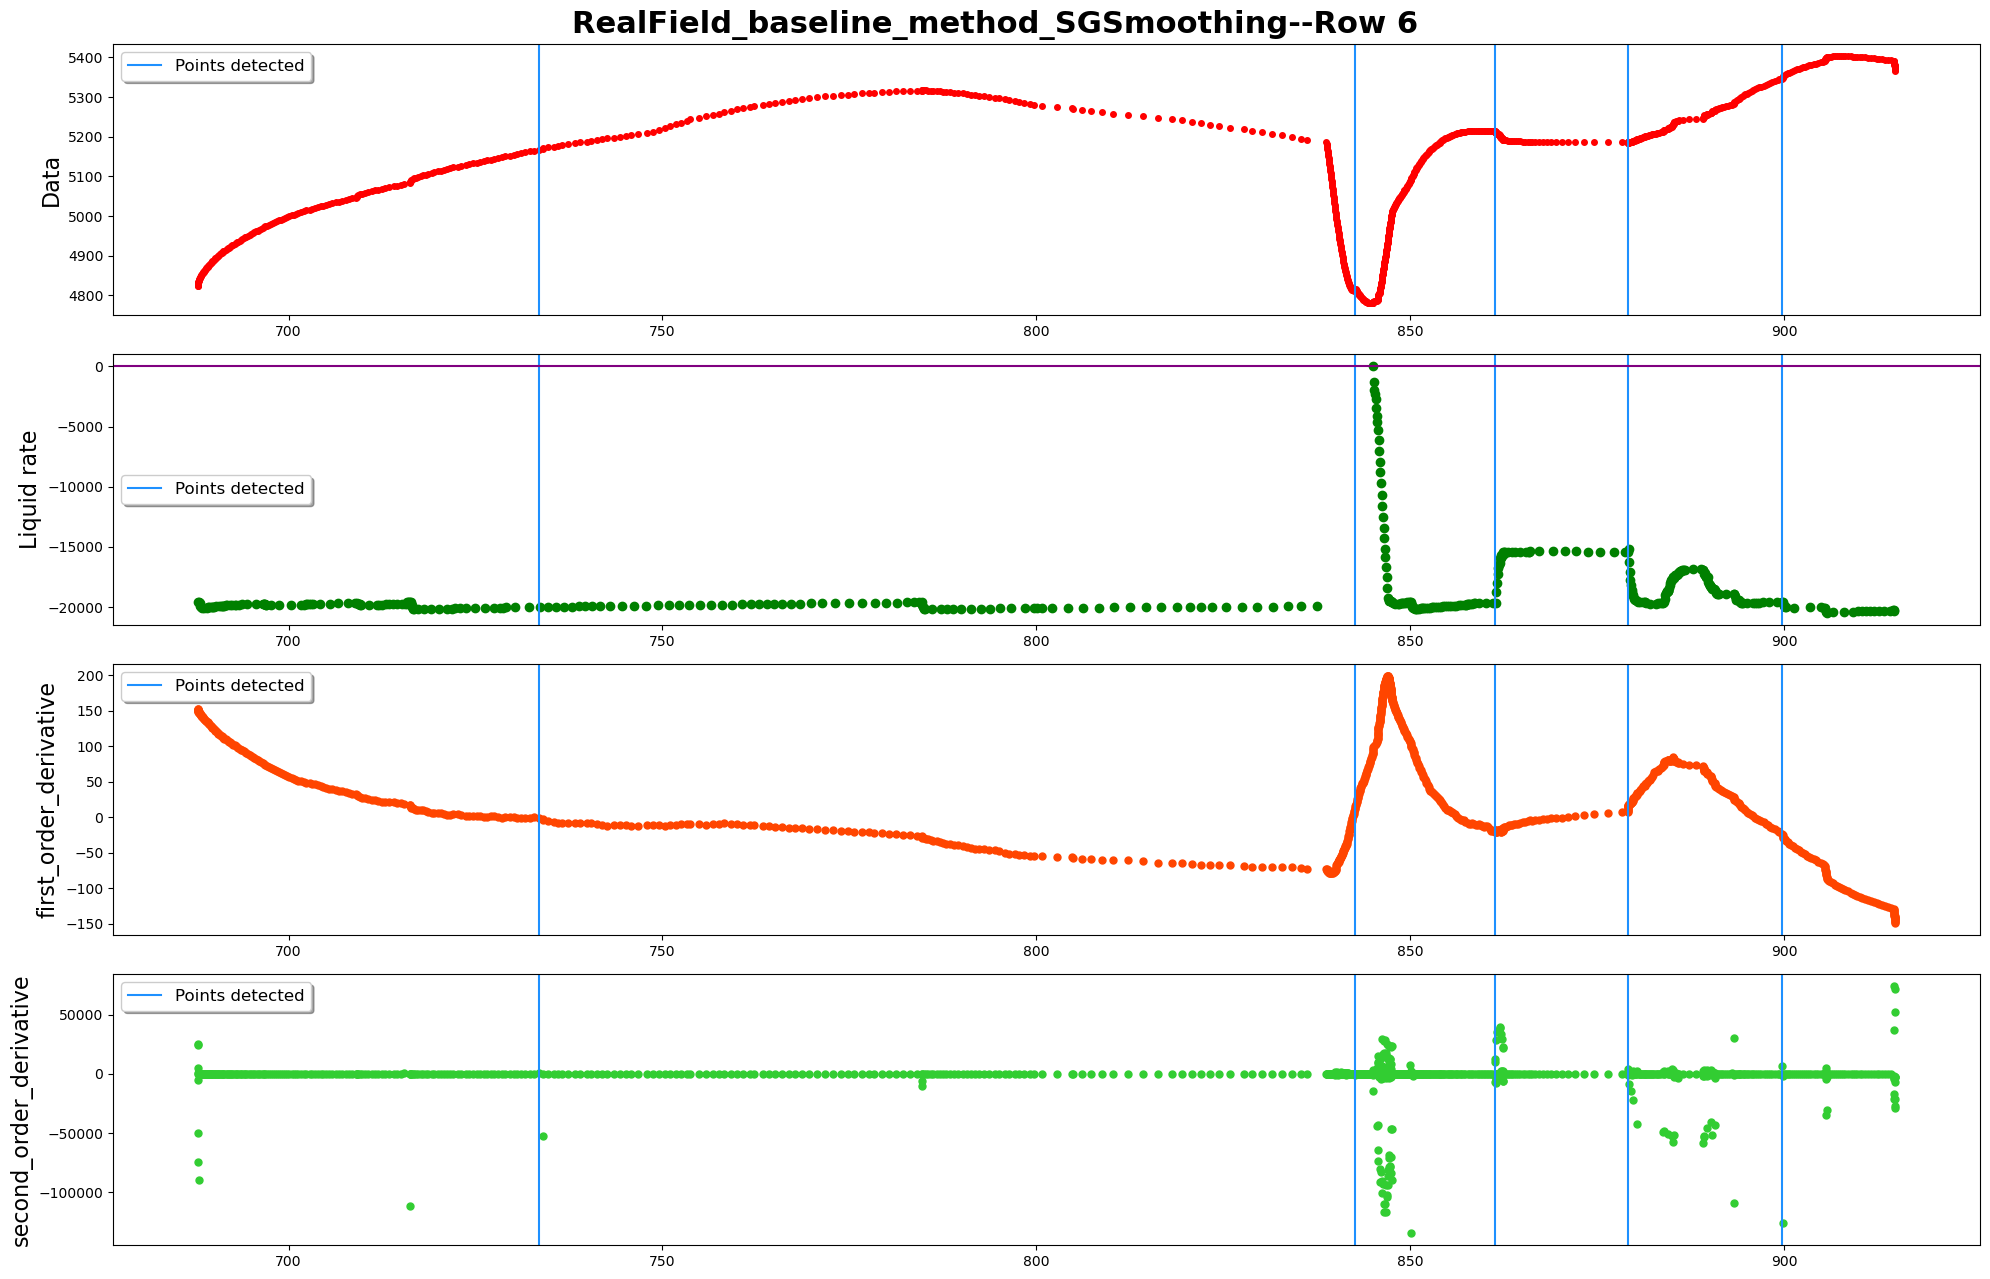

------row 7-----detected points:[6542]


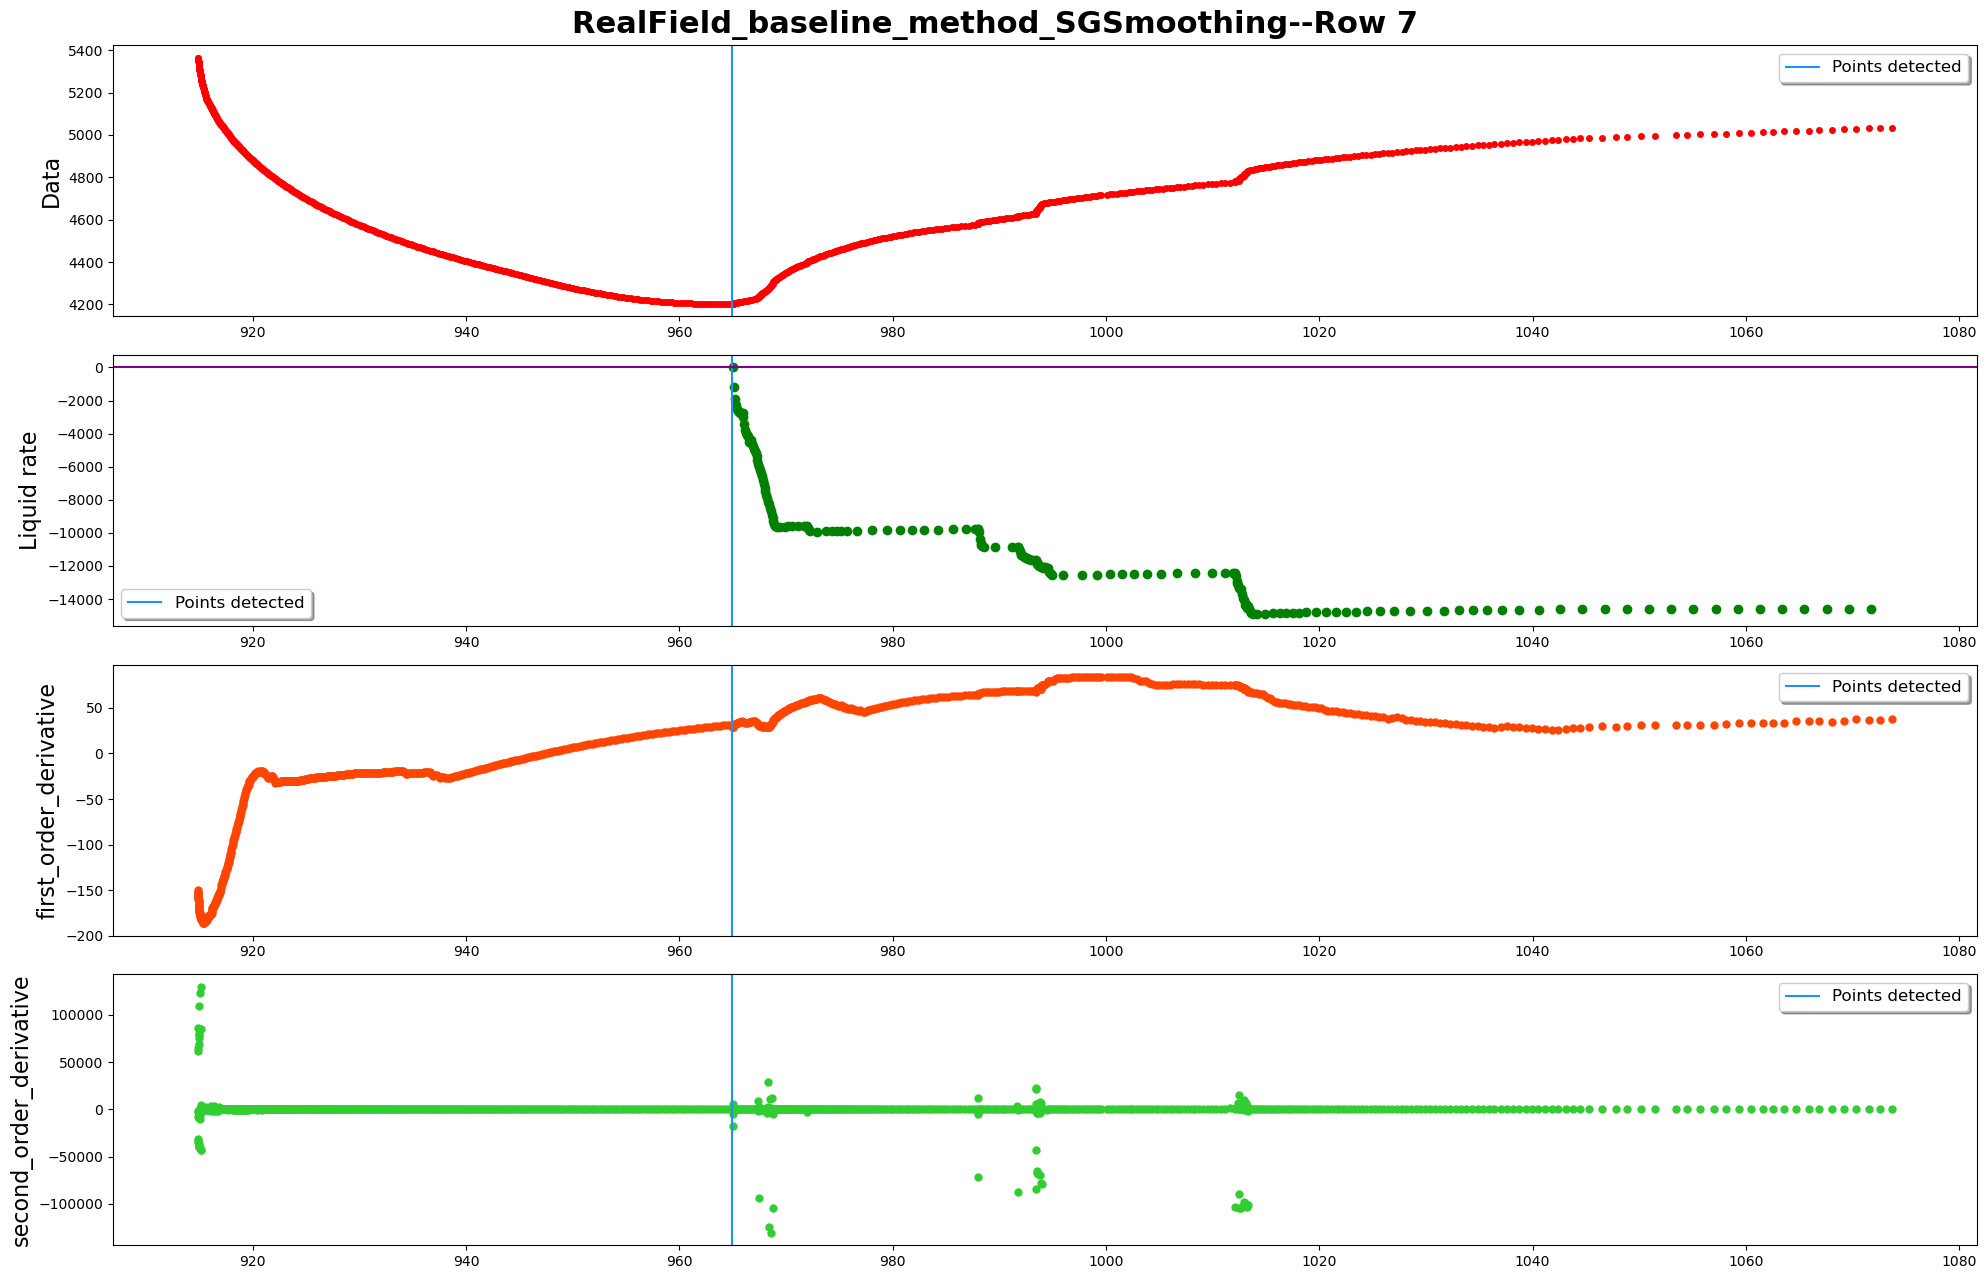

------row 8-----detected points:[7219, 7543, 7944]


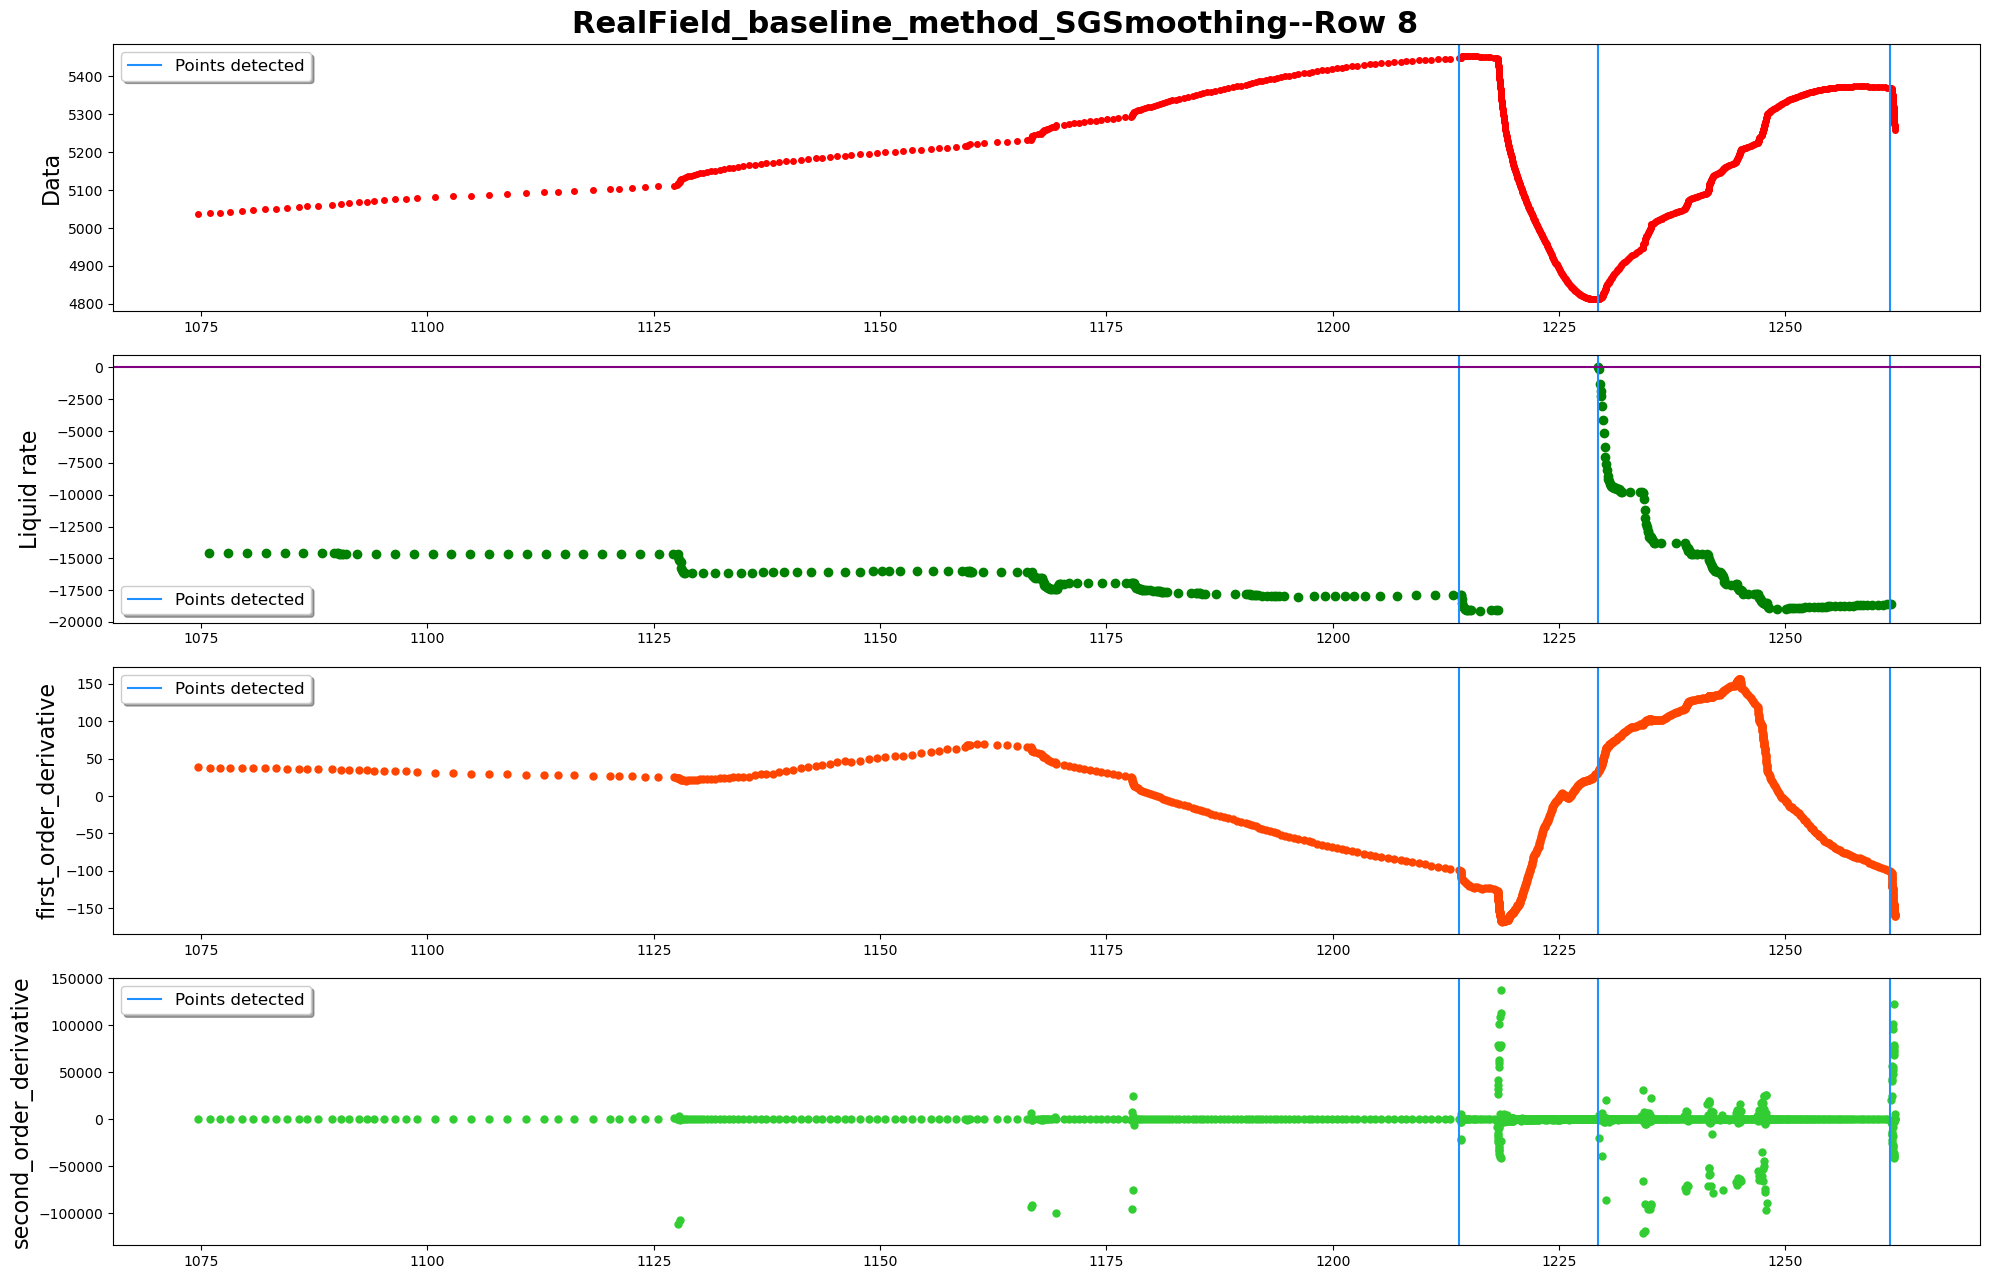

------row 9-----detected points:[8360, 8940, 8942]


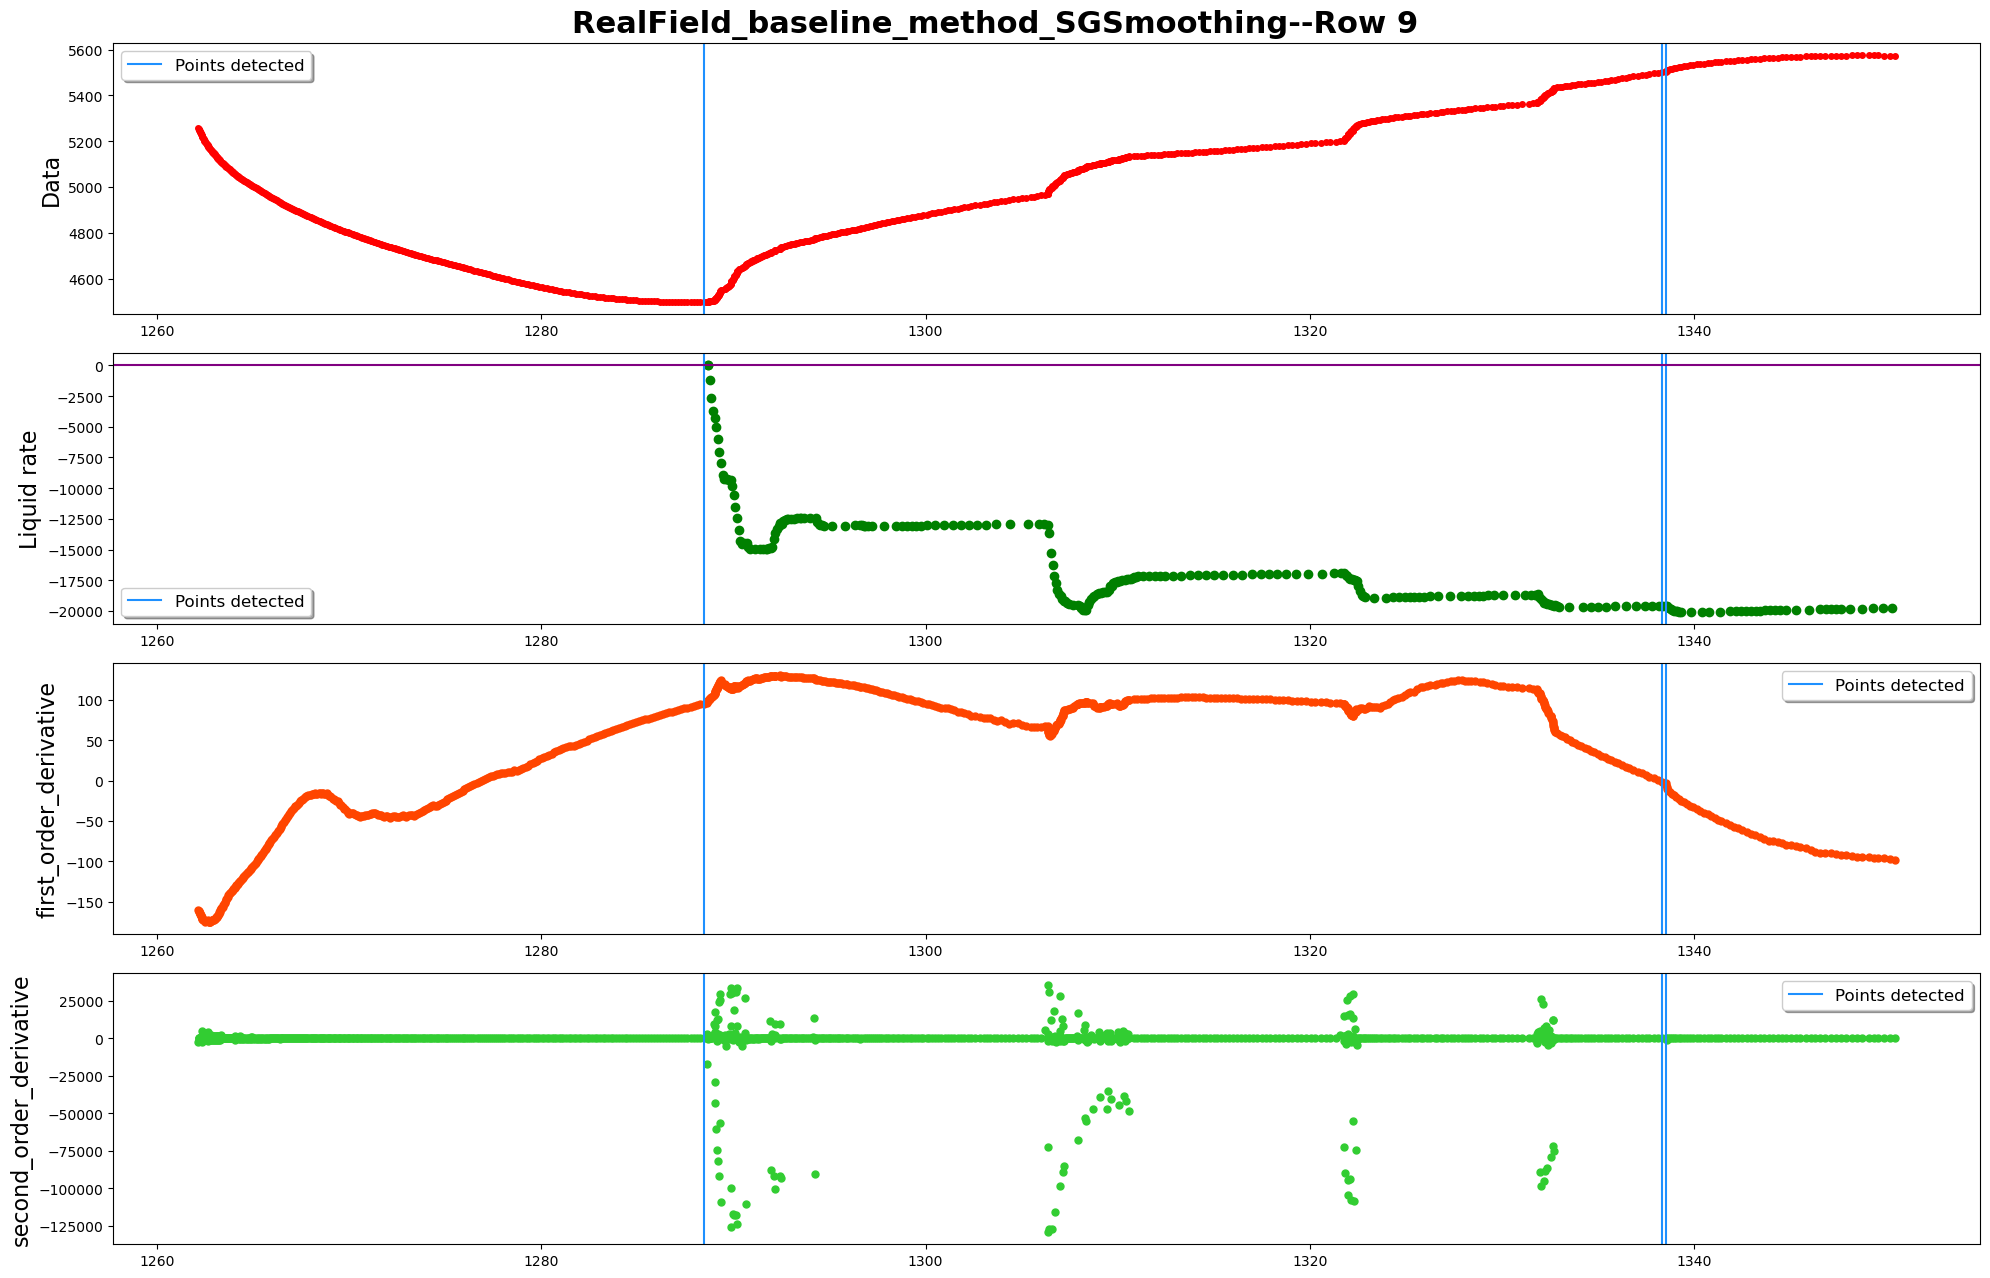

------row 10-----detected points:[9606]


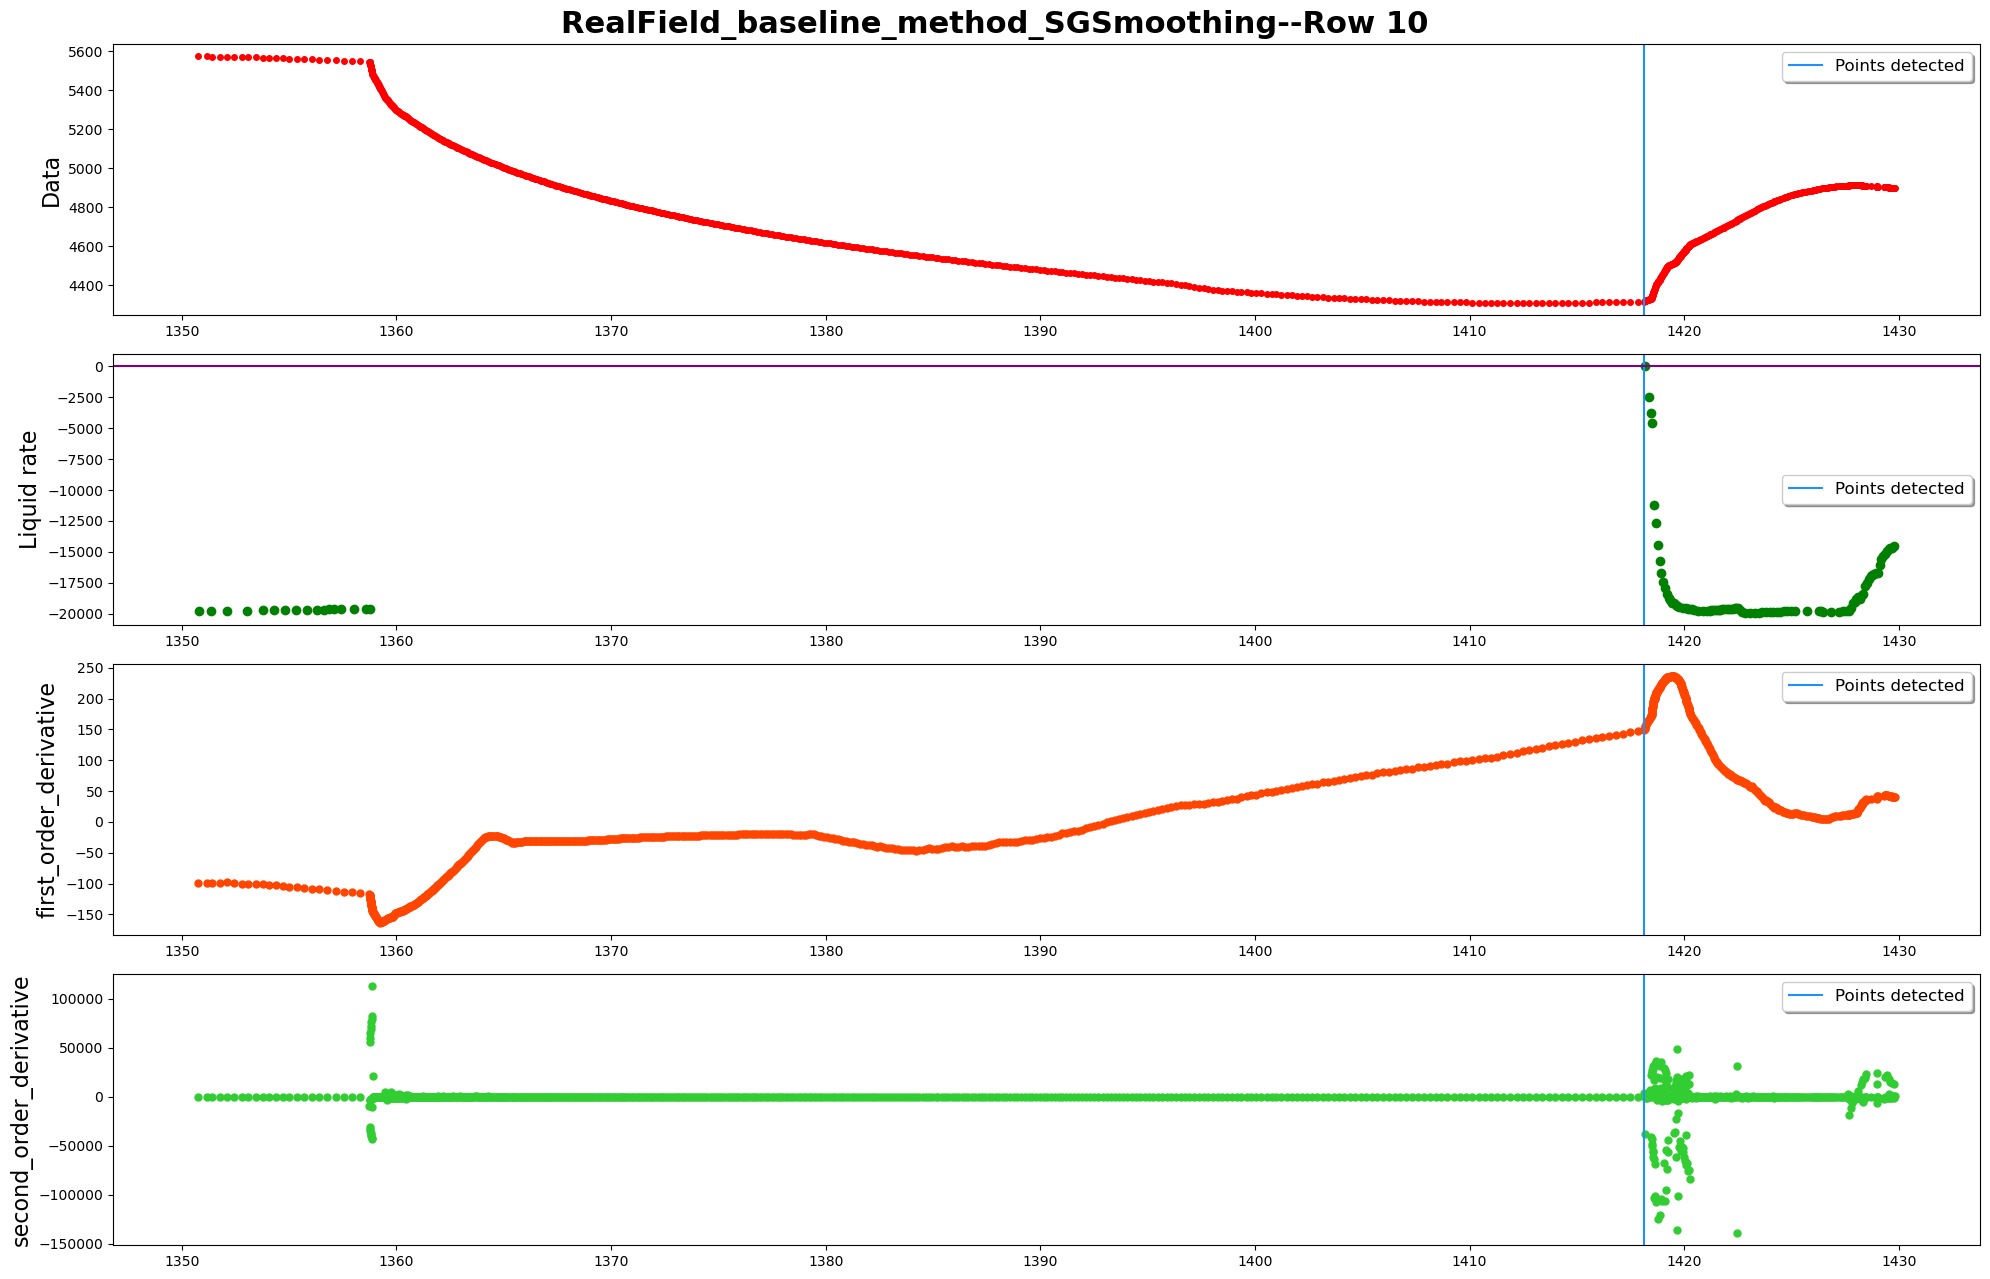

------row 11-----detected points:[10086, 10121, 10452, 10799]


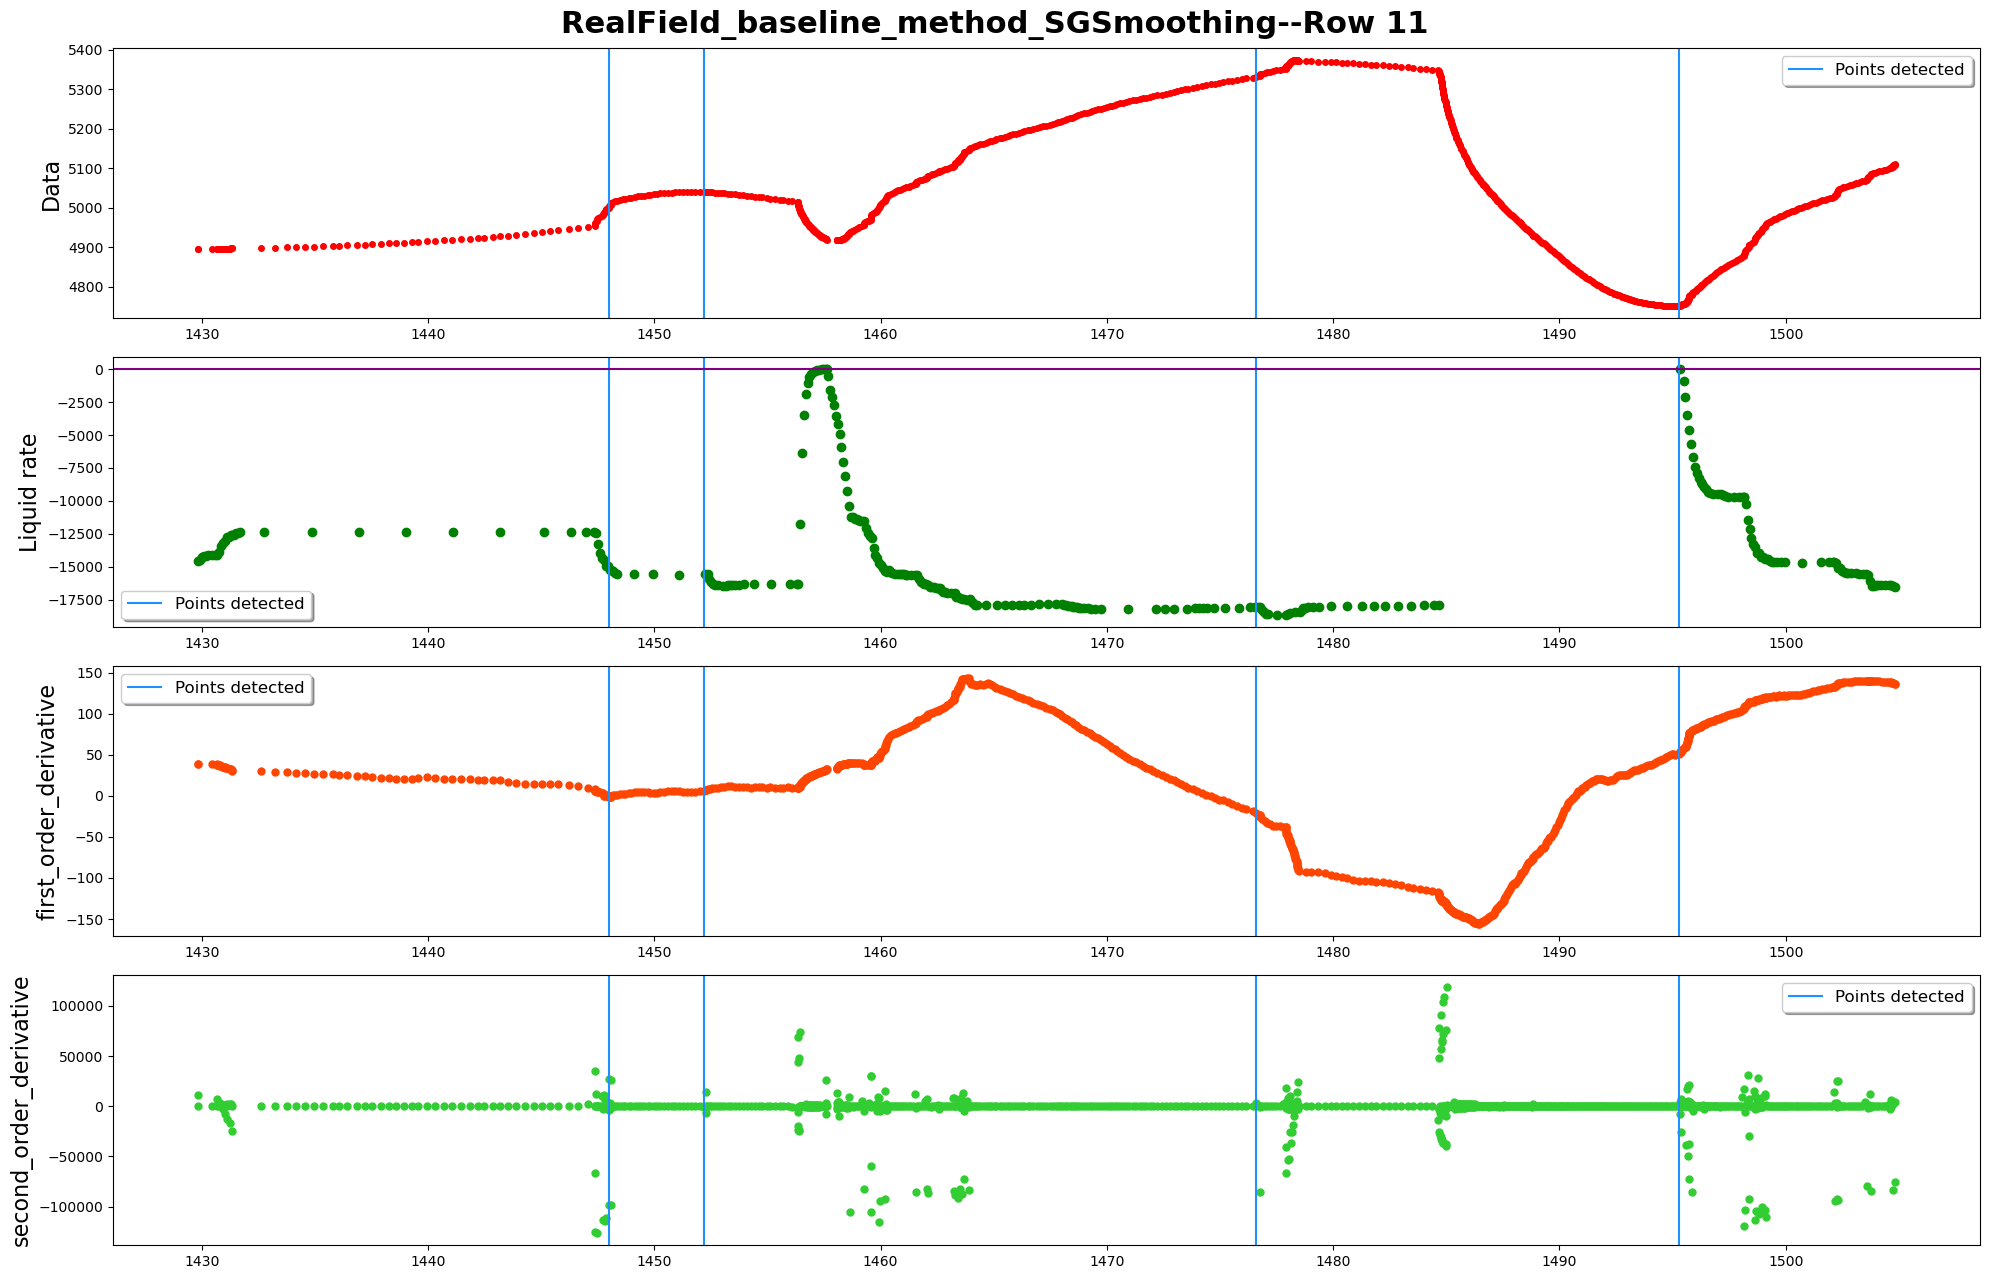

------row 12-----detected points:[11240, 11492]


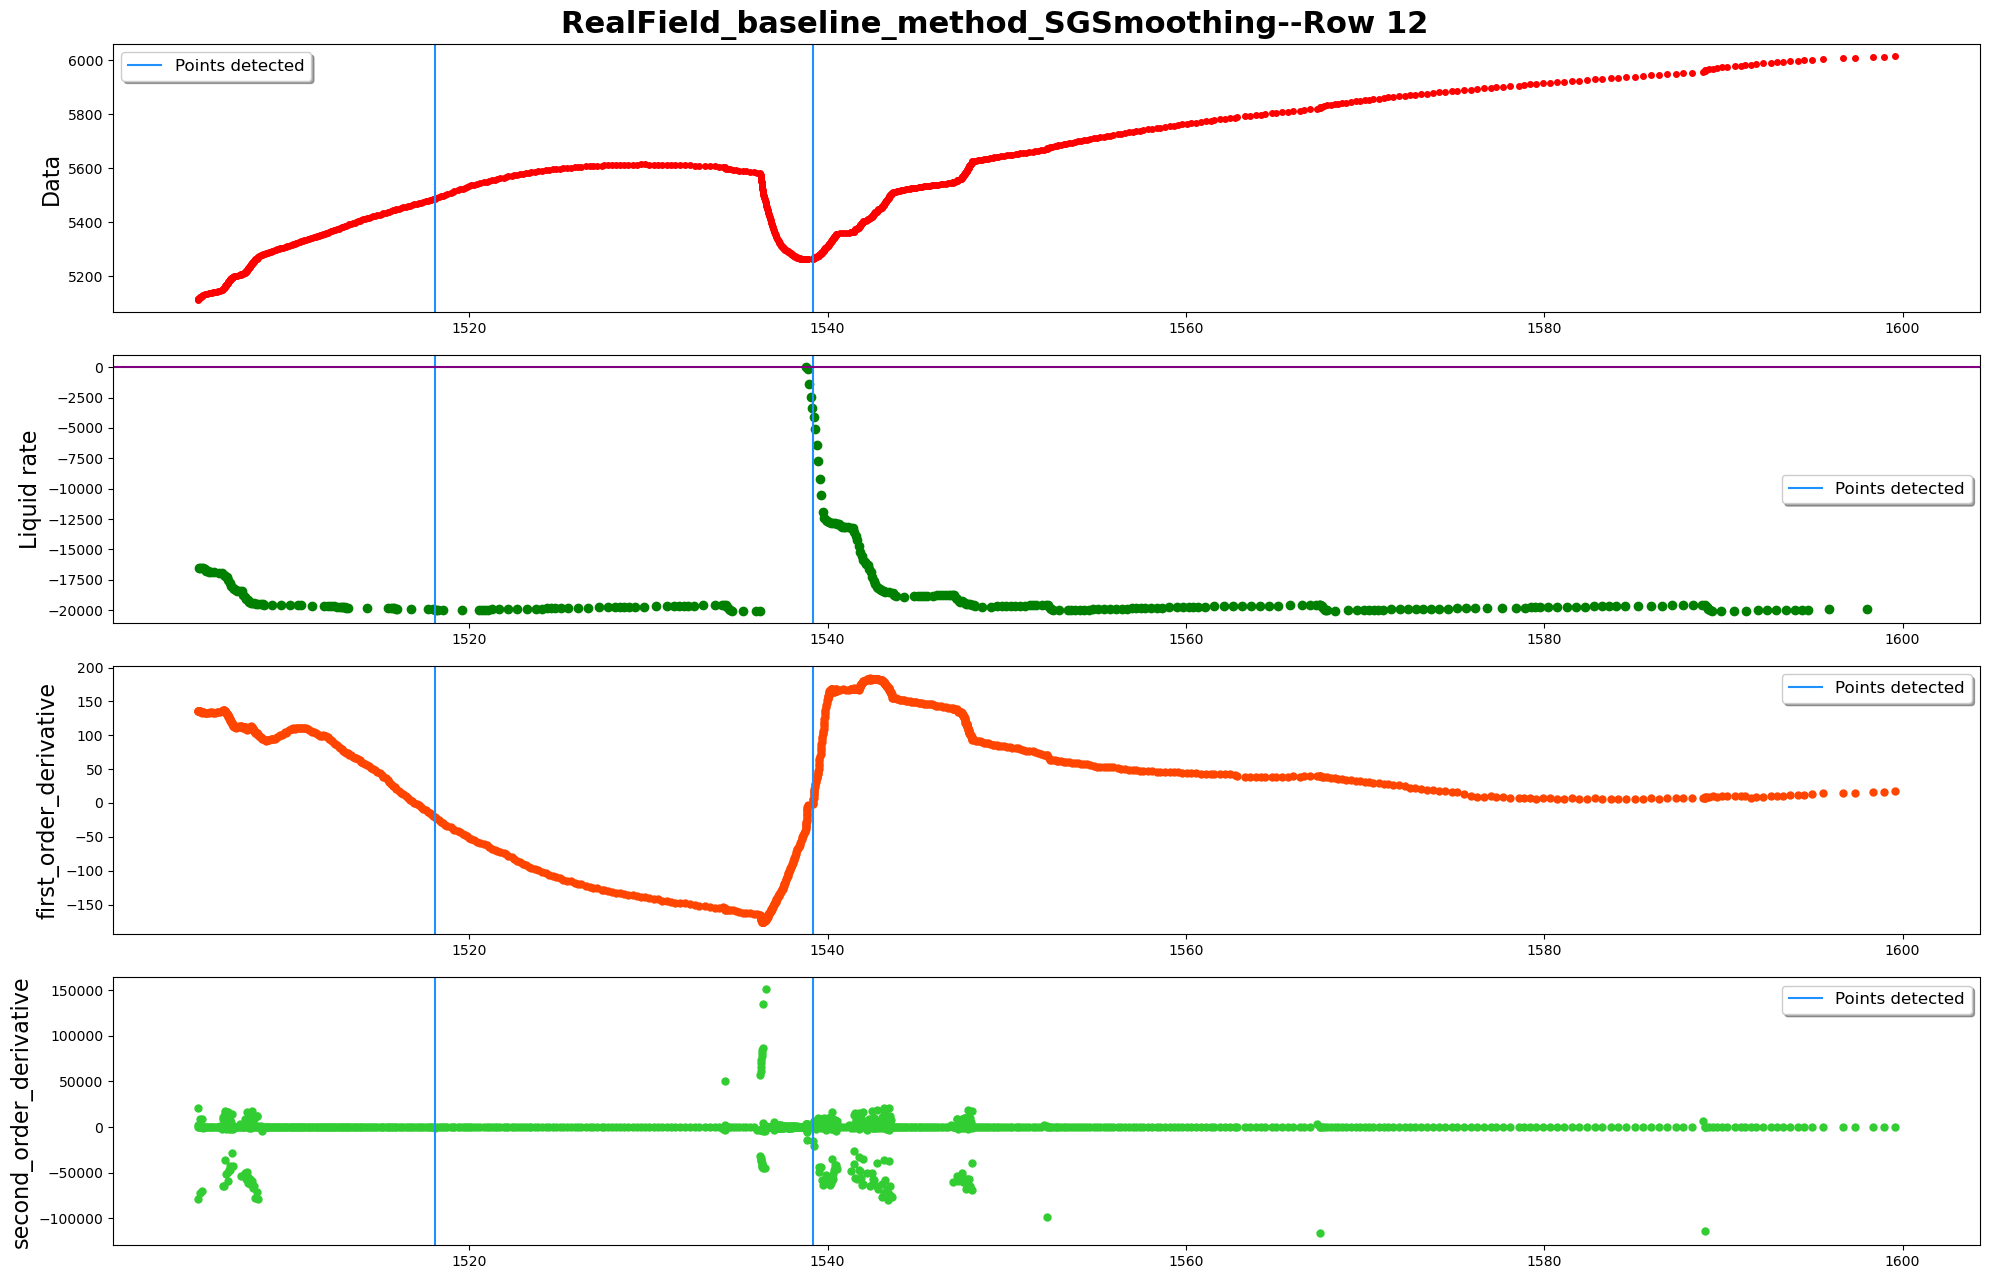

------row 13-----detected points:[12262, 12263]


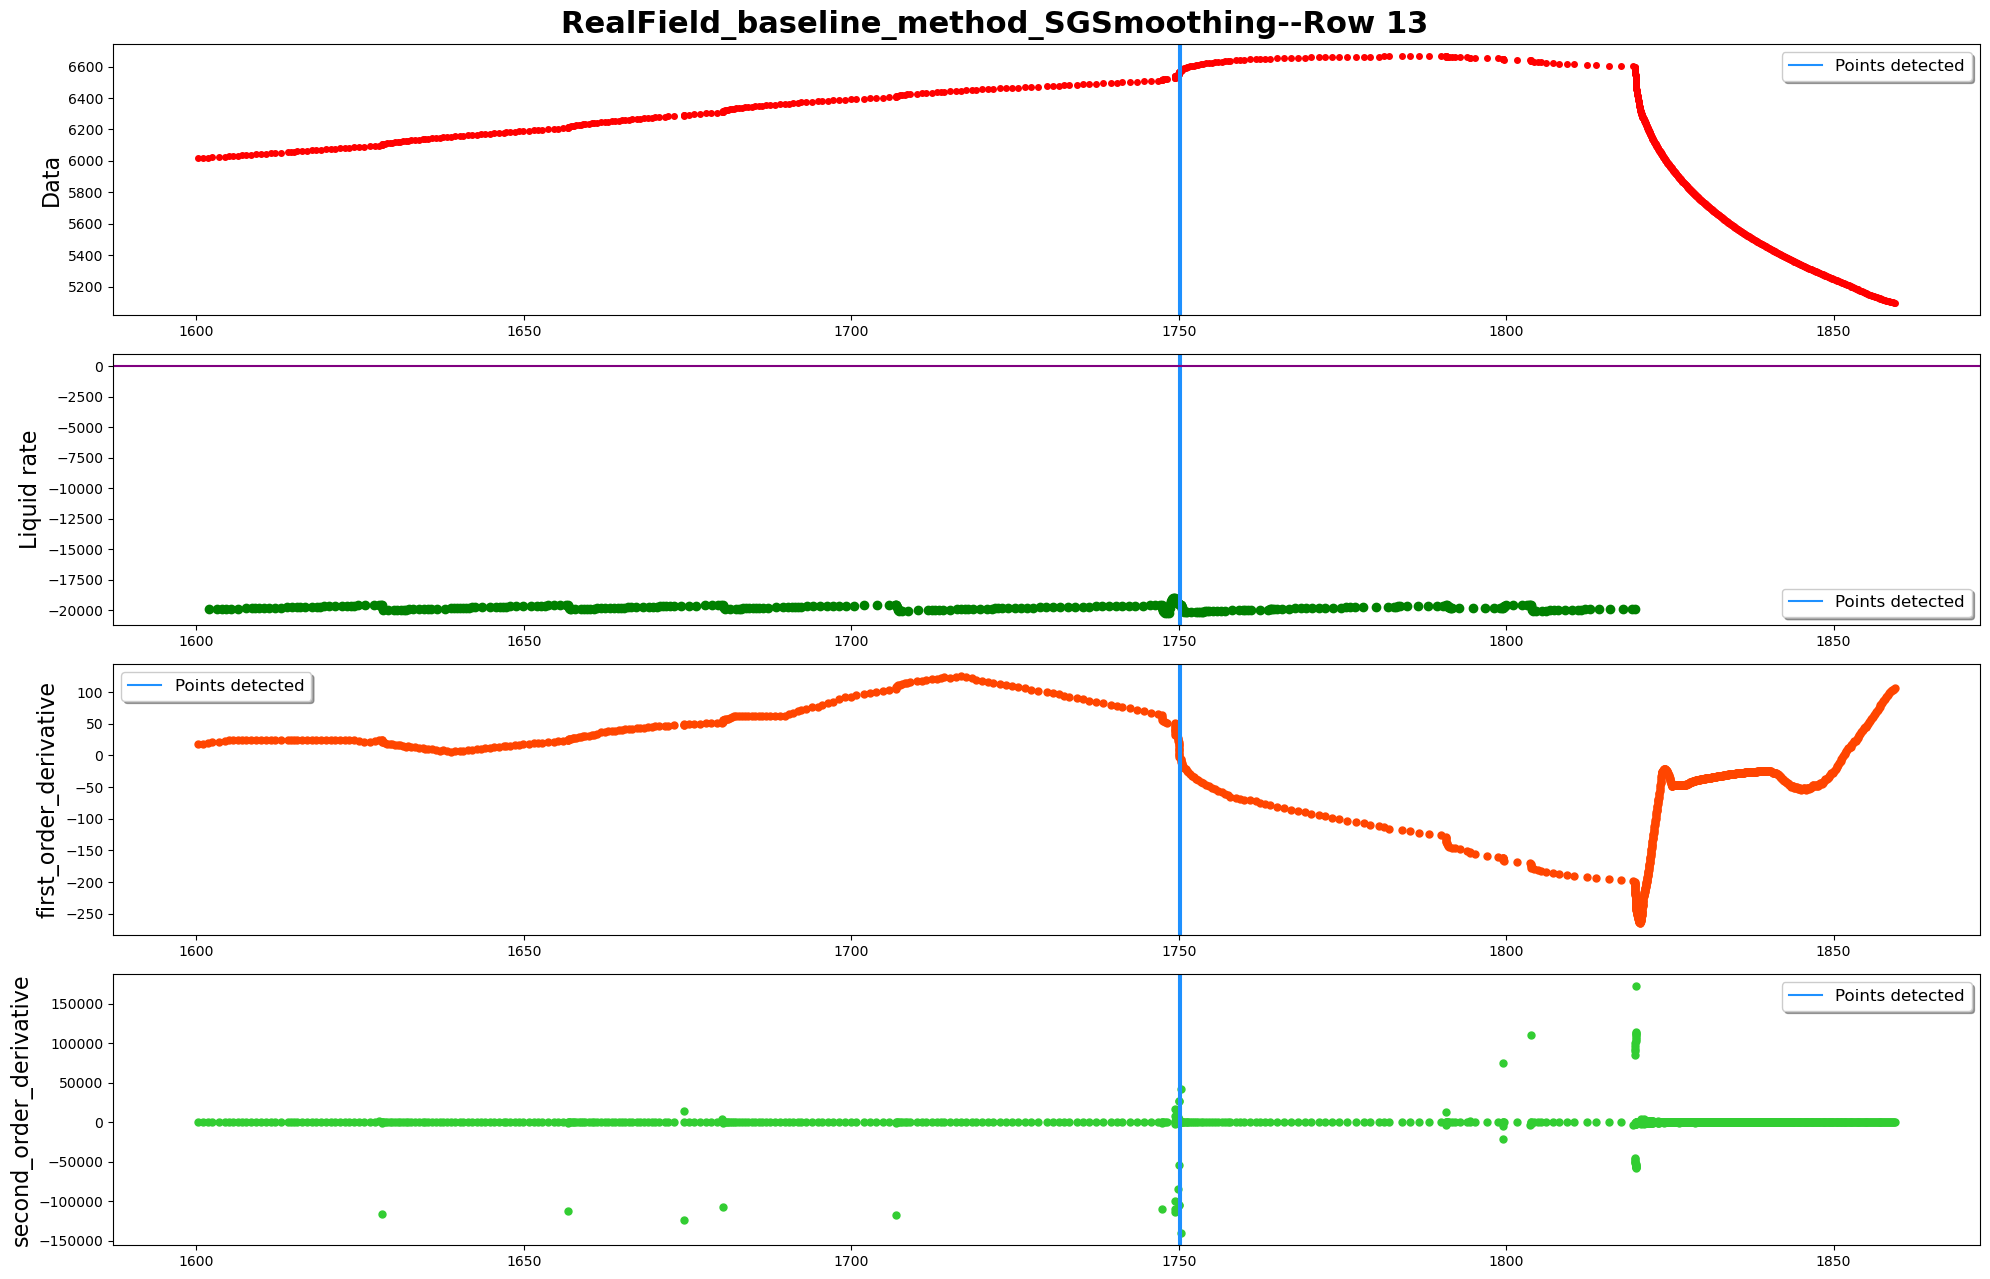

------row 14-----detected points:[13038, 13759]


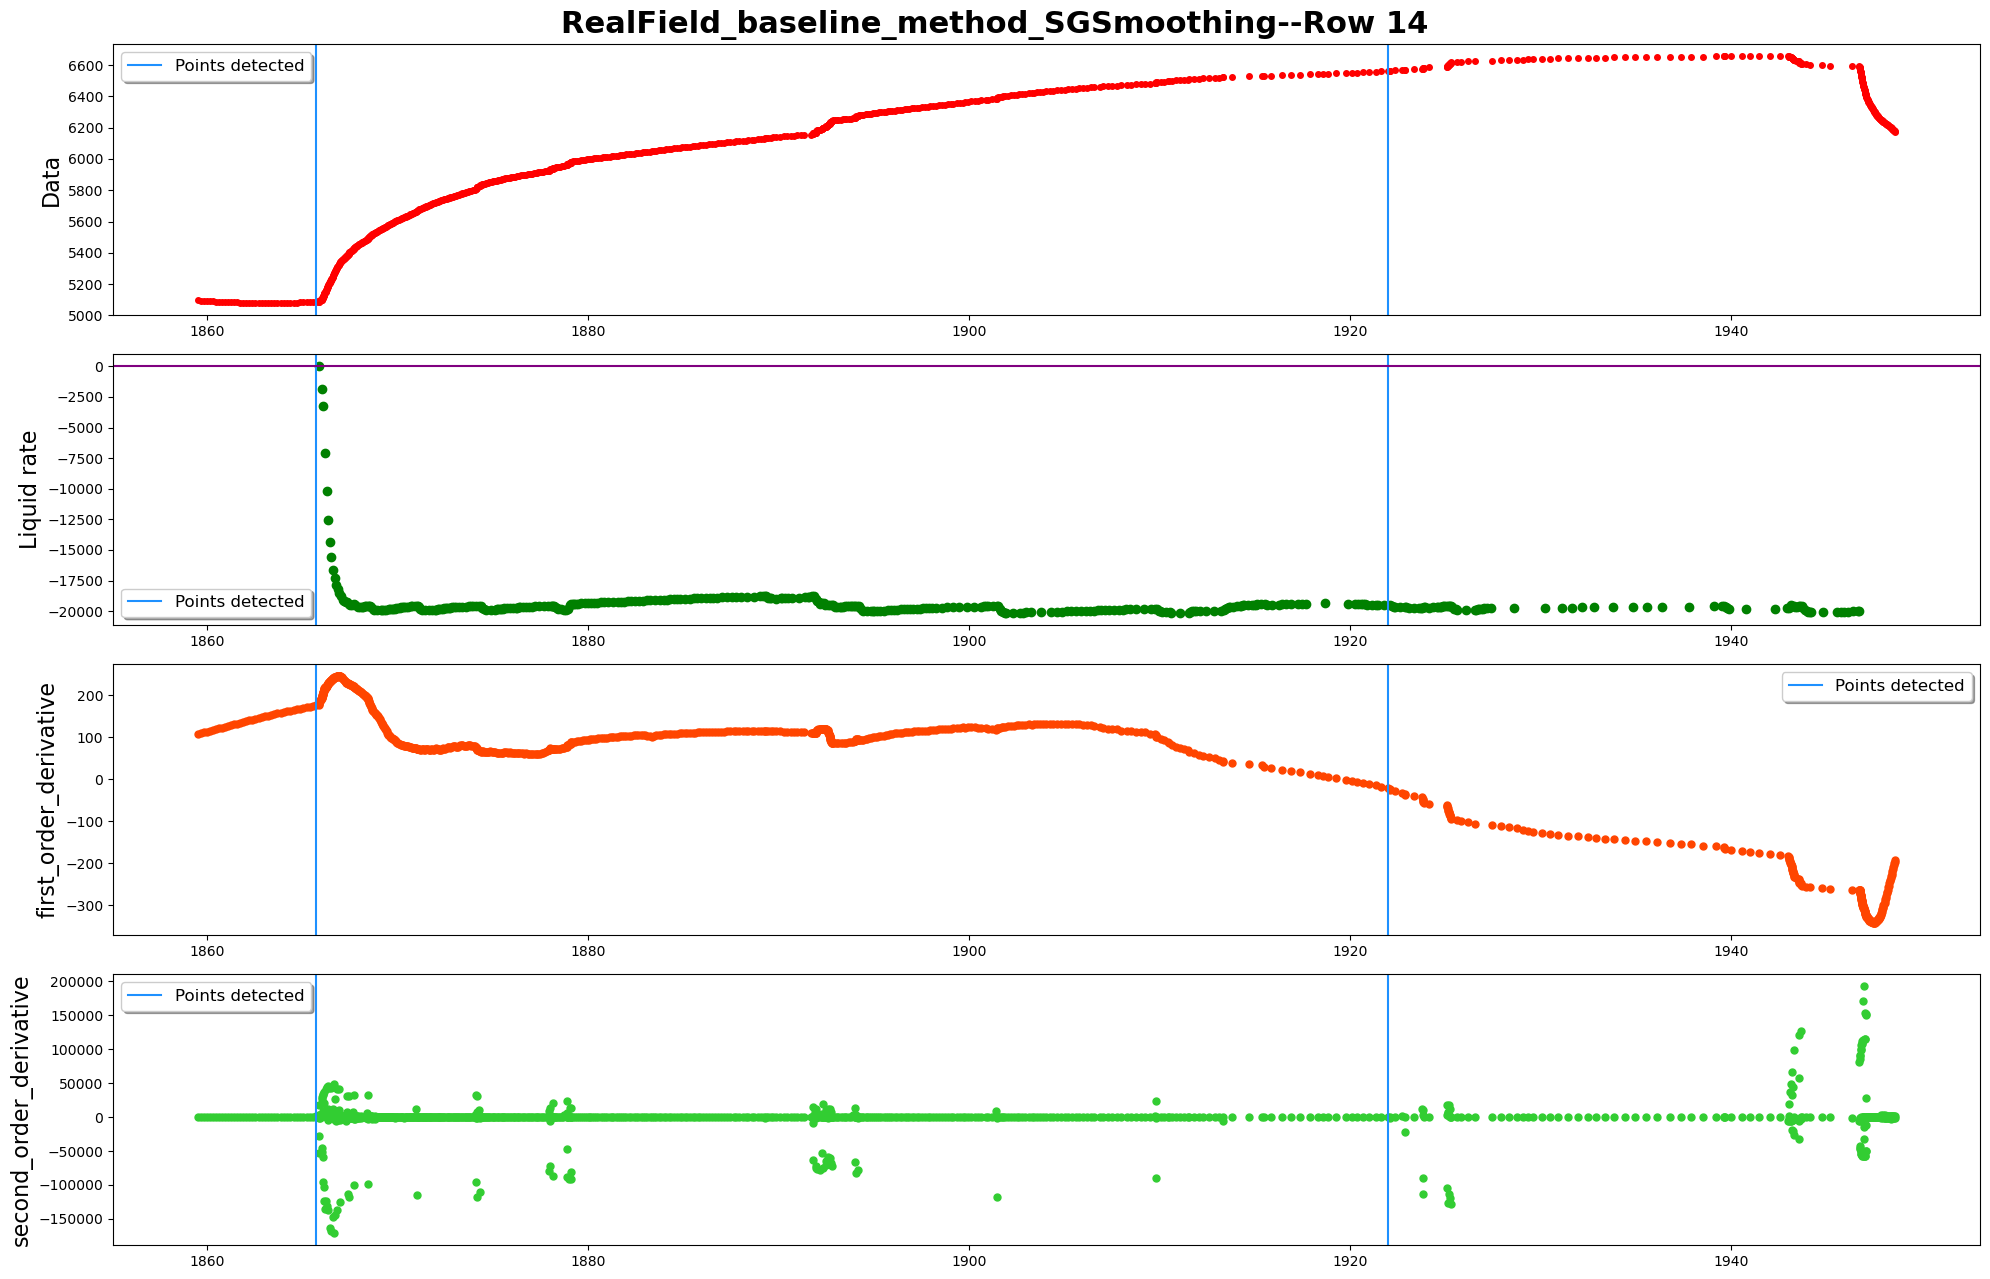

------row 15-----detected points:[14039, 14040, 14356, 14546, 14708, 14730]


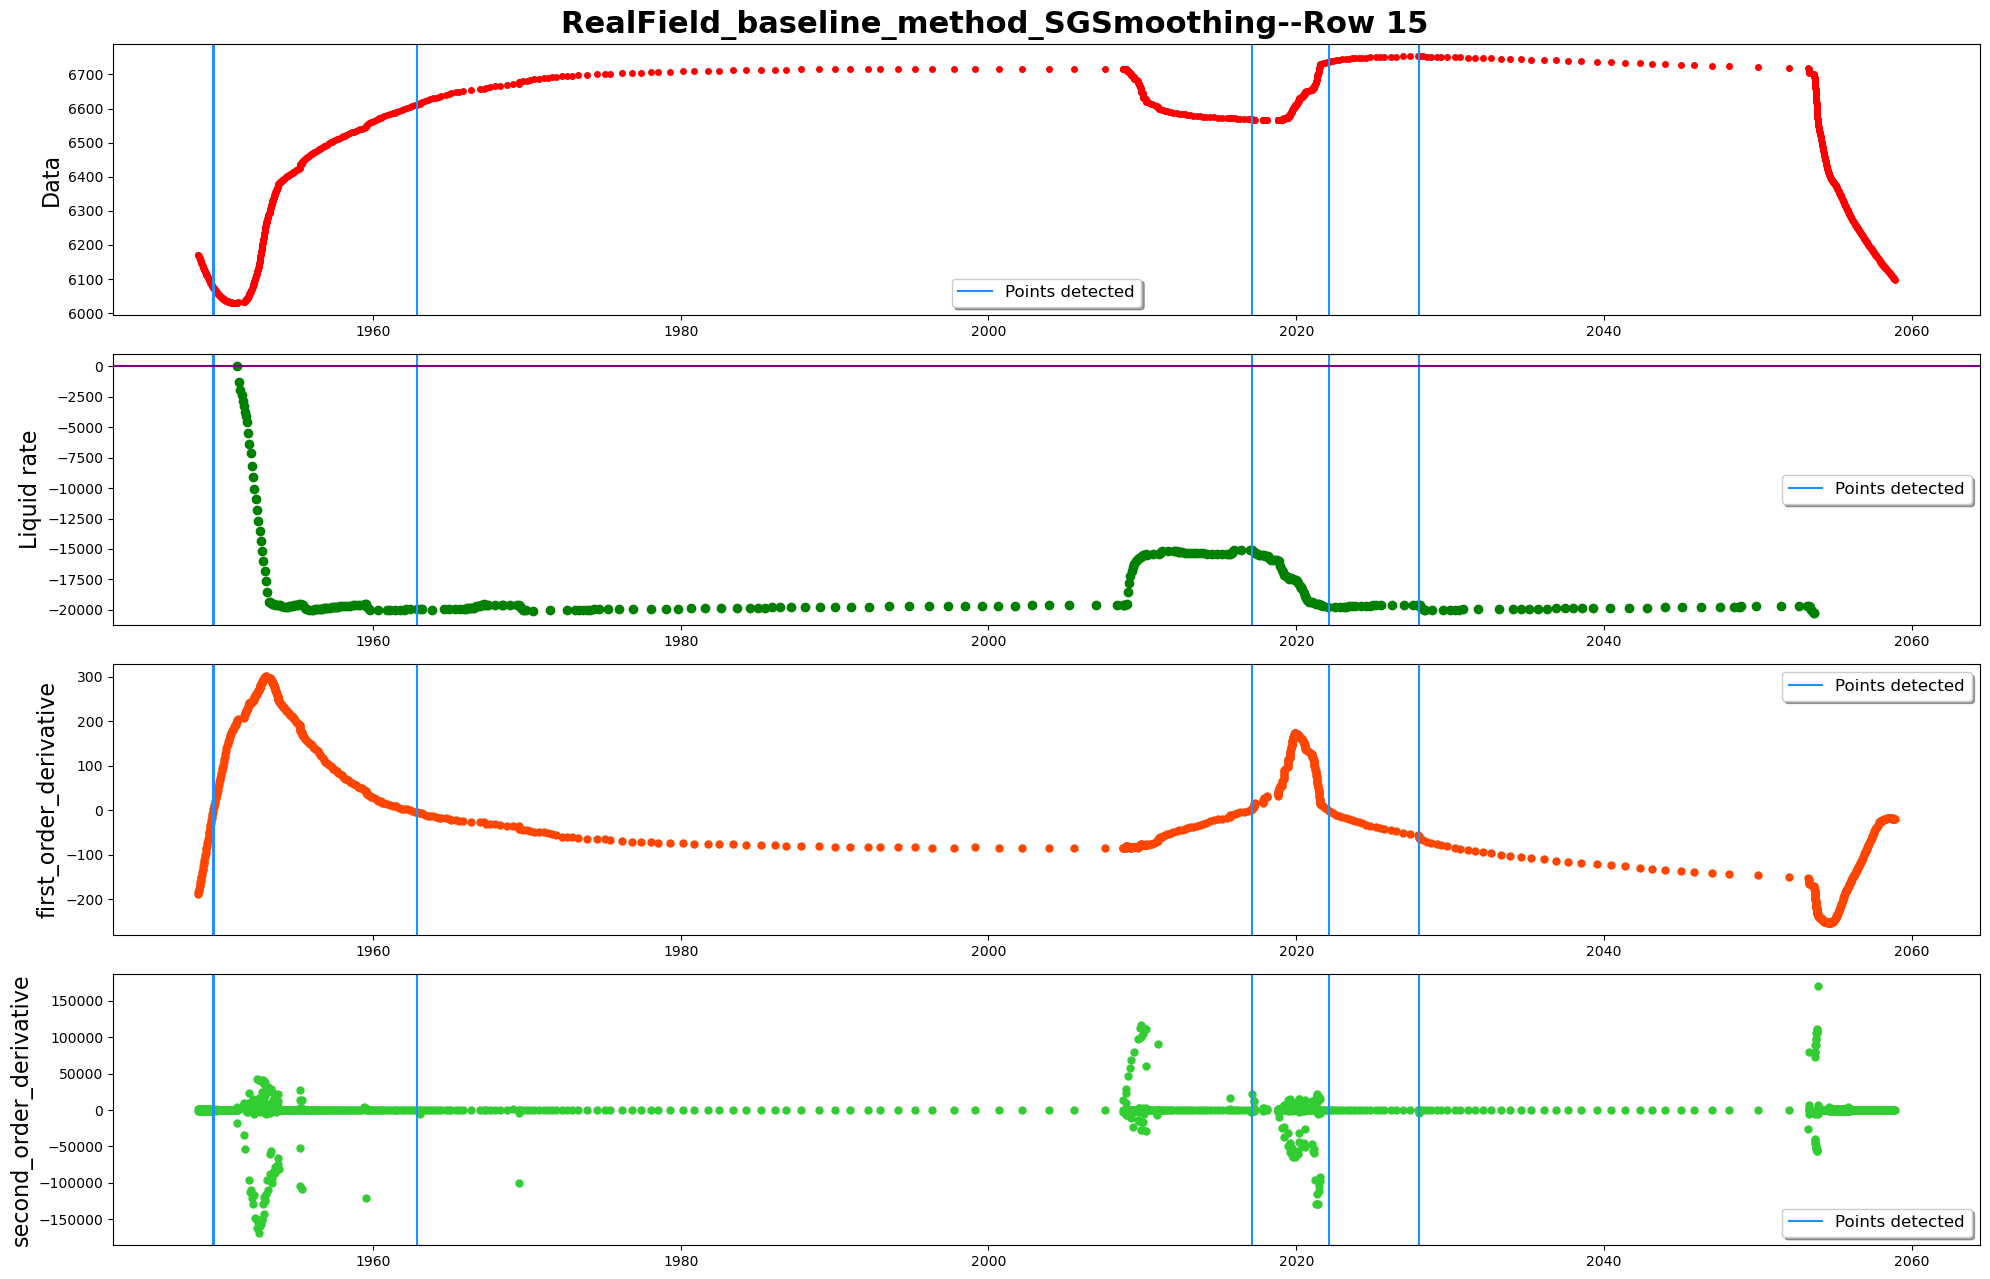

------row 16-----detected points:[15329]


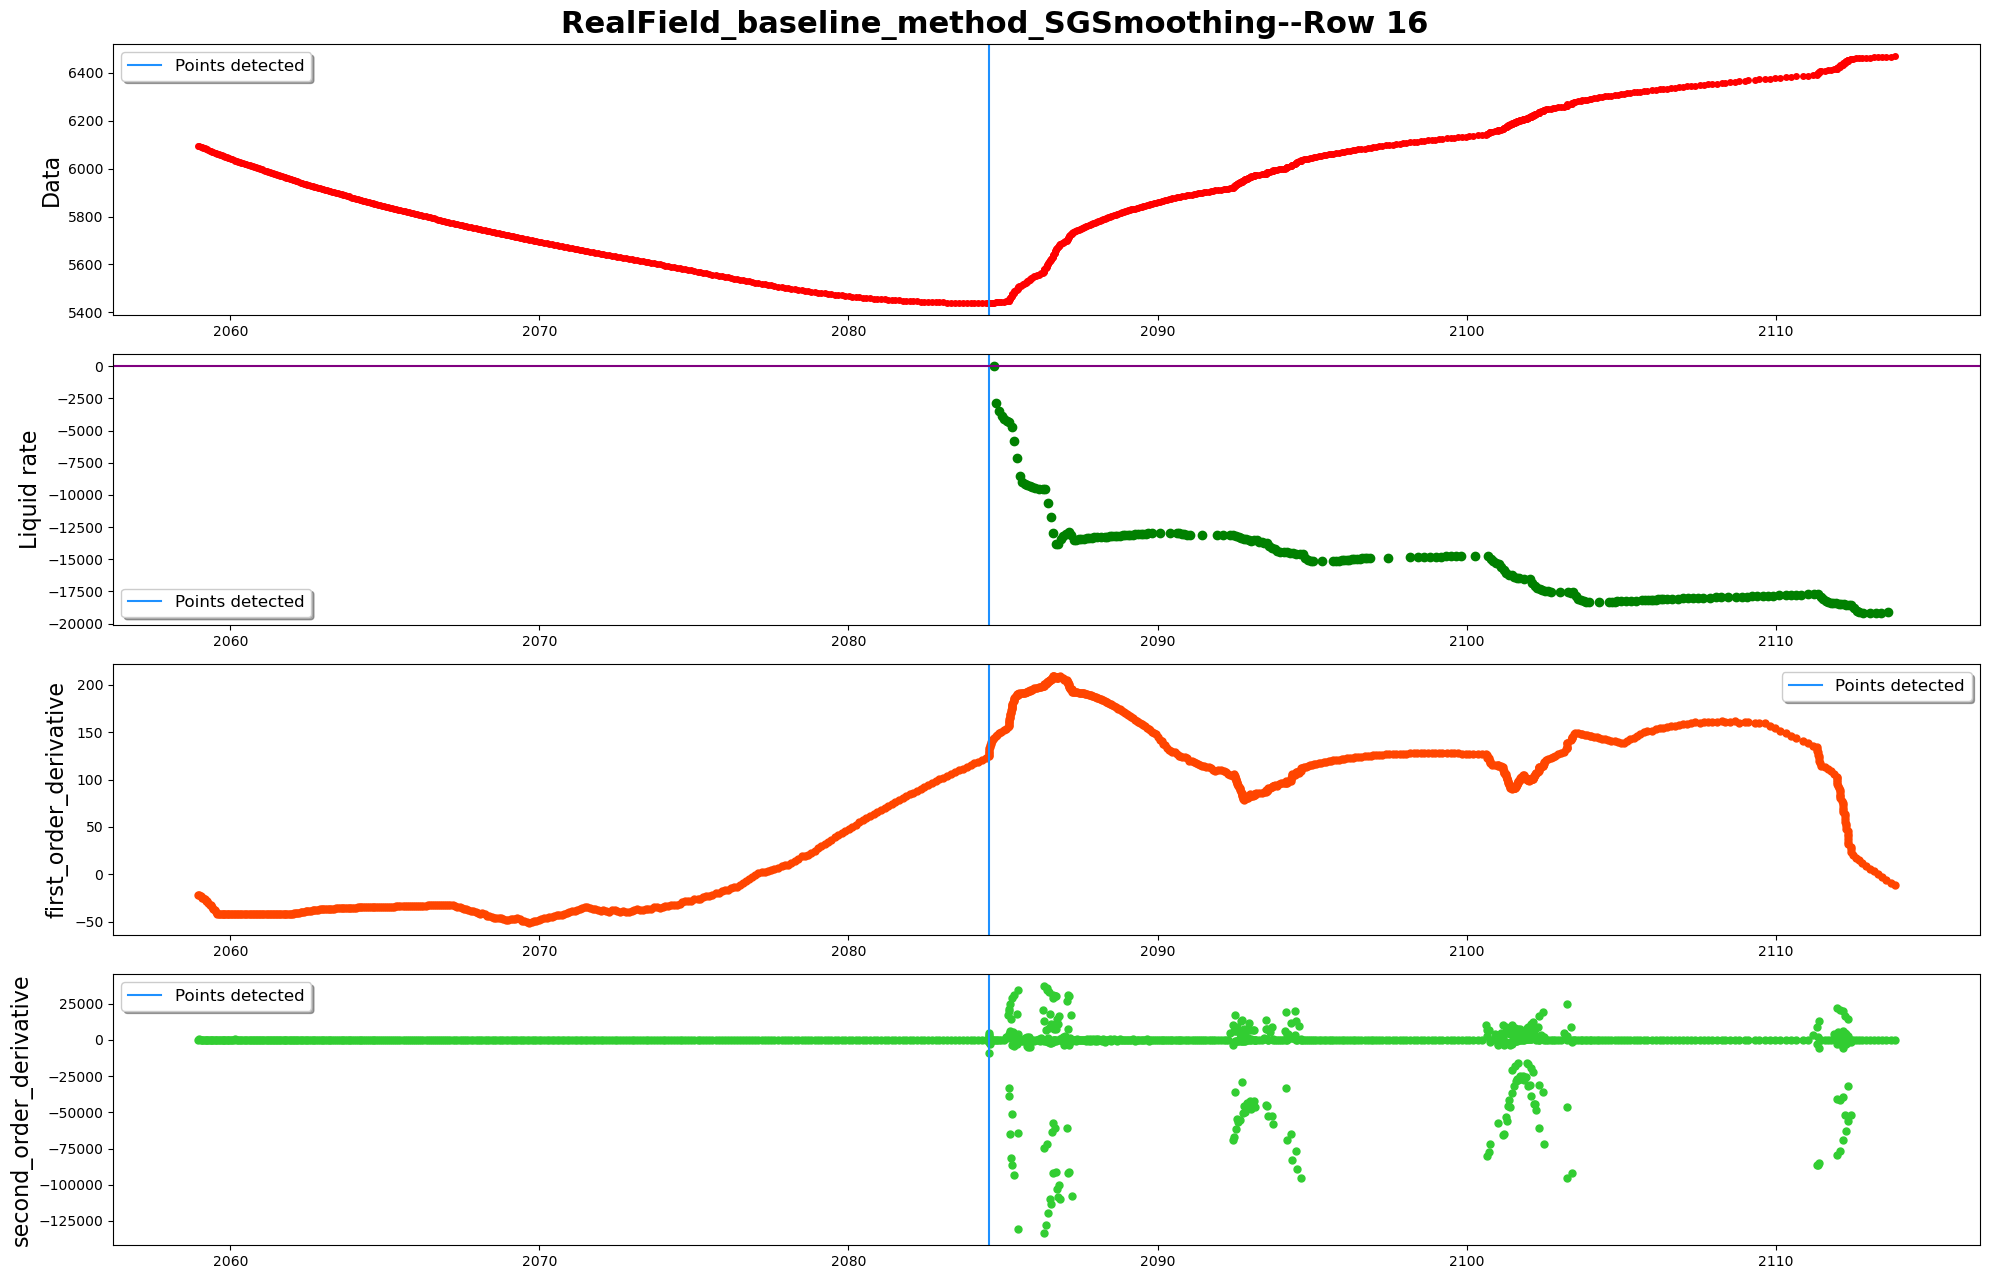

------row 17-----detected points:[16008, 16517, 16571]


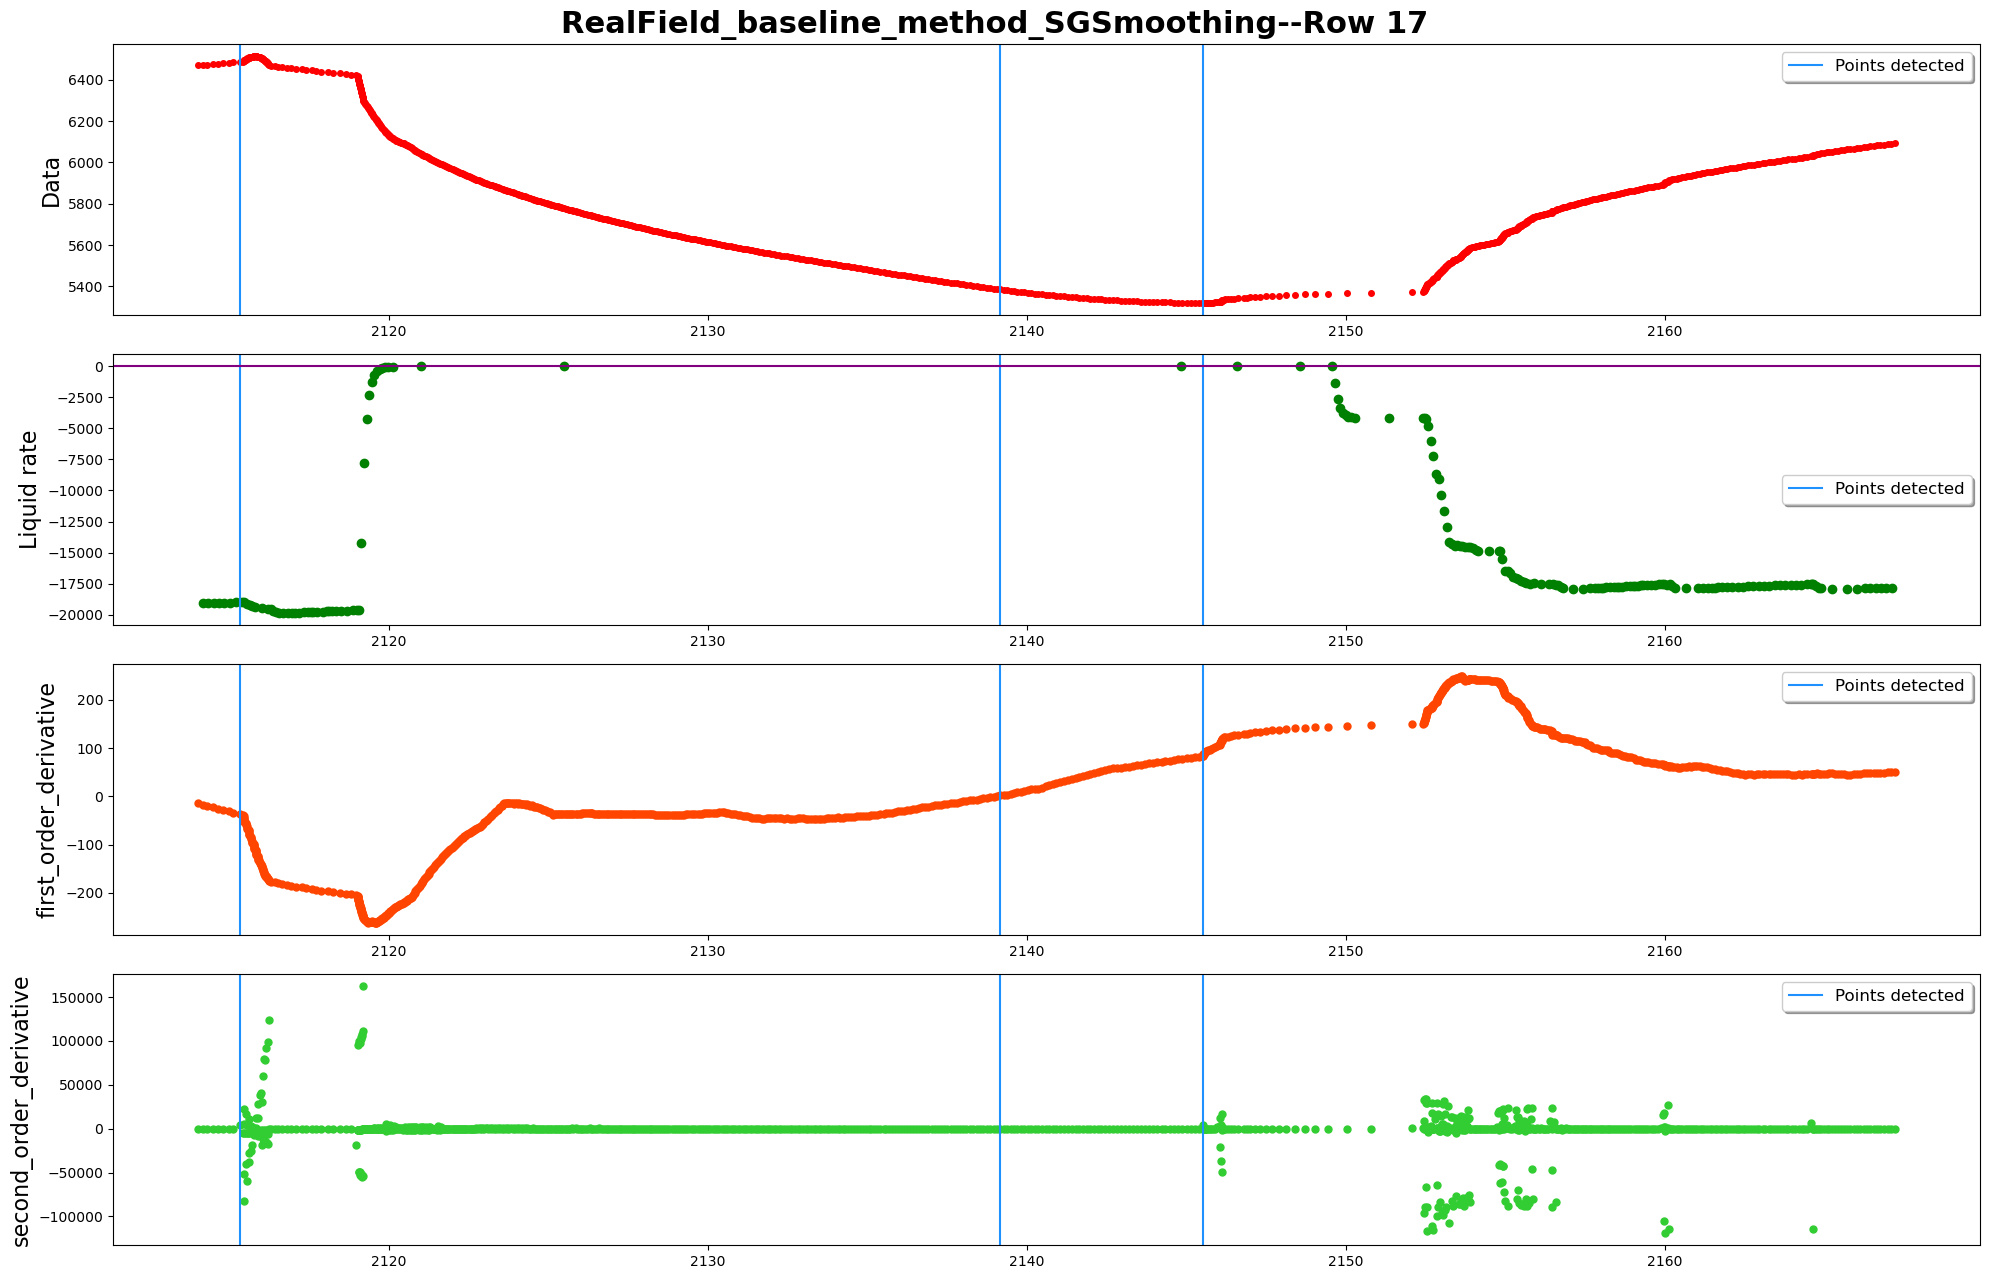

------row 18-----detected points:[17477]


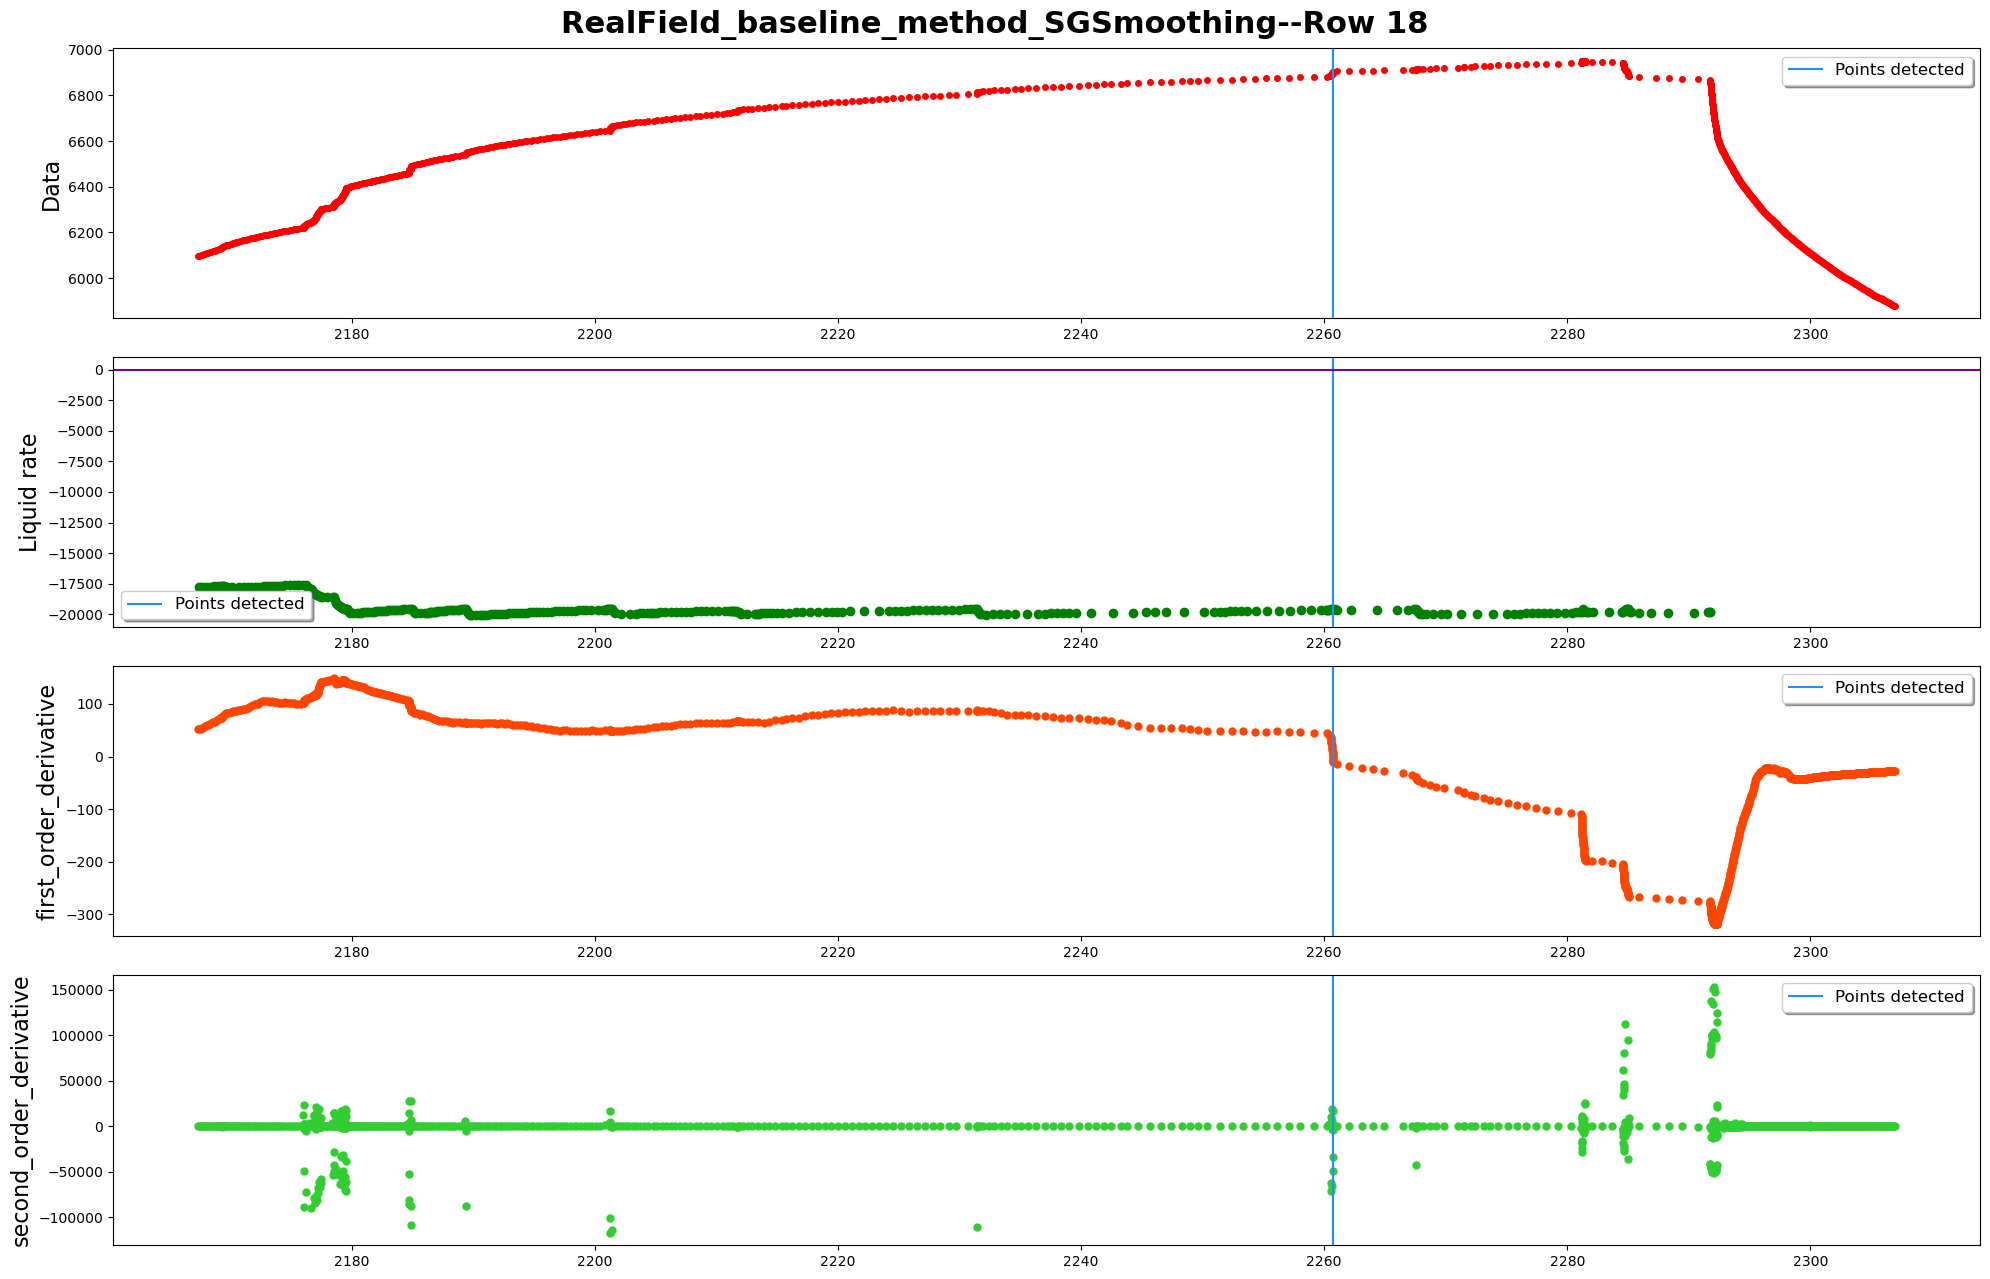

------row 19-----detected points:[18433]


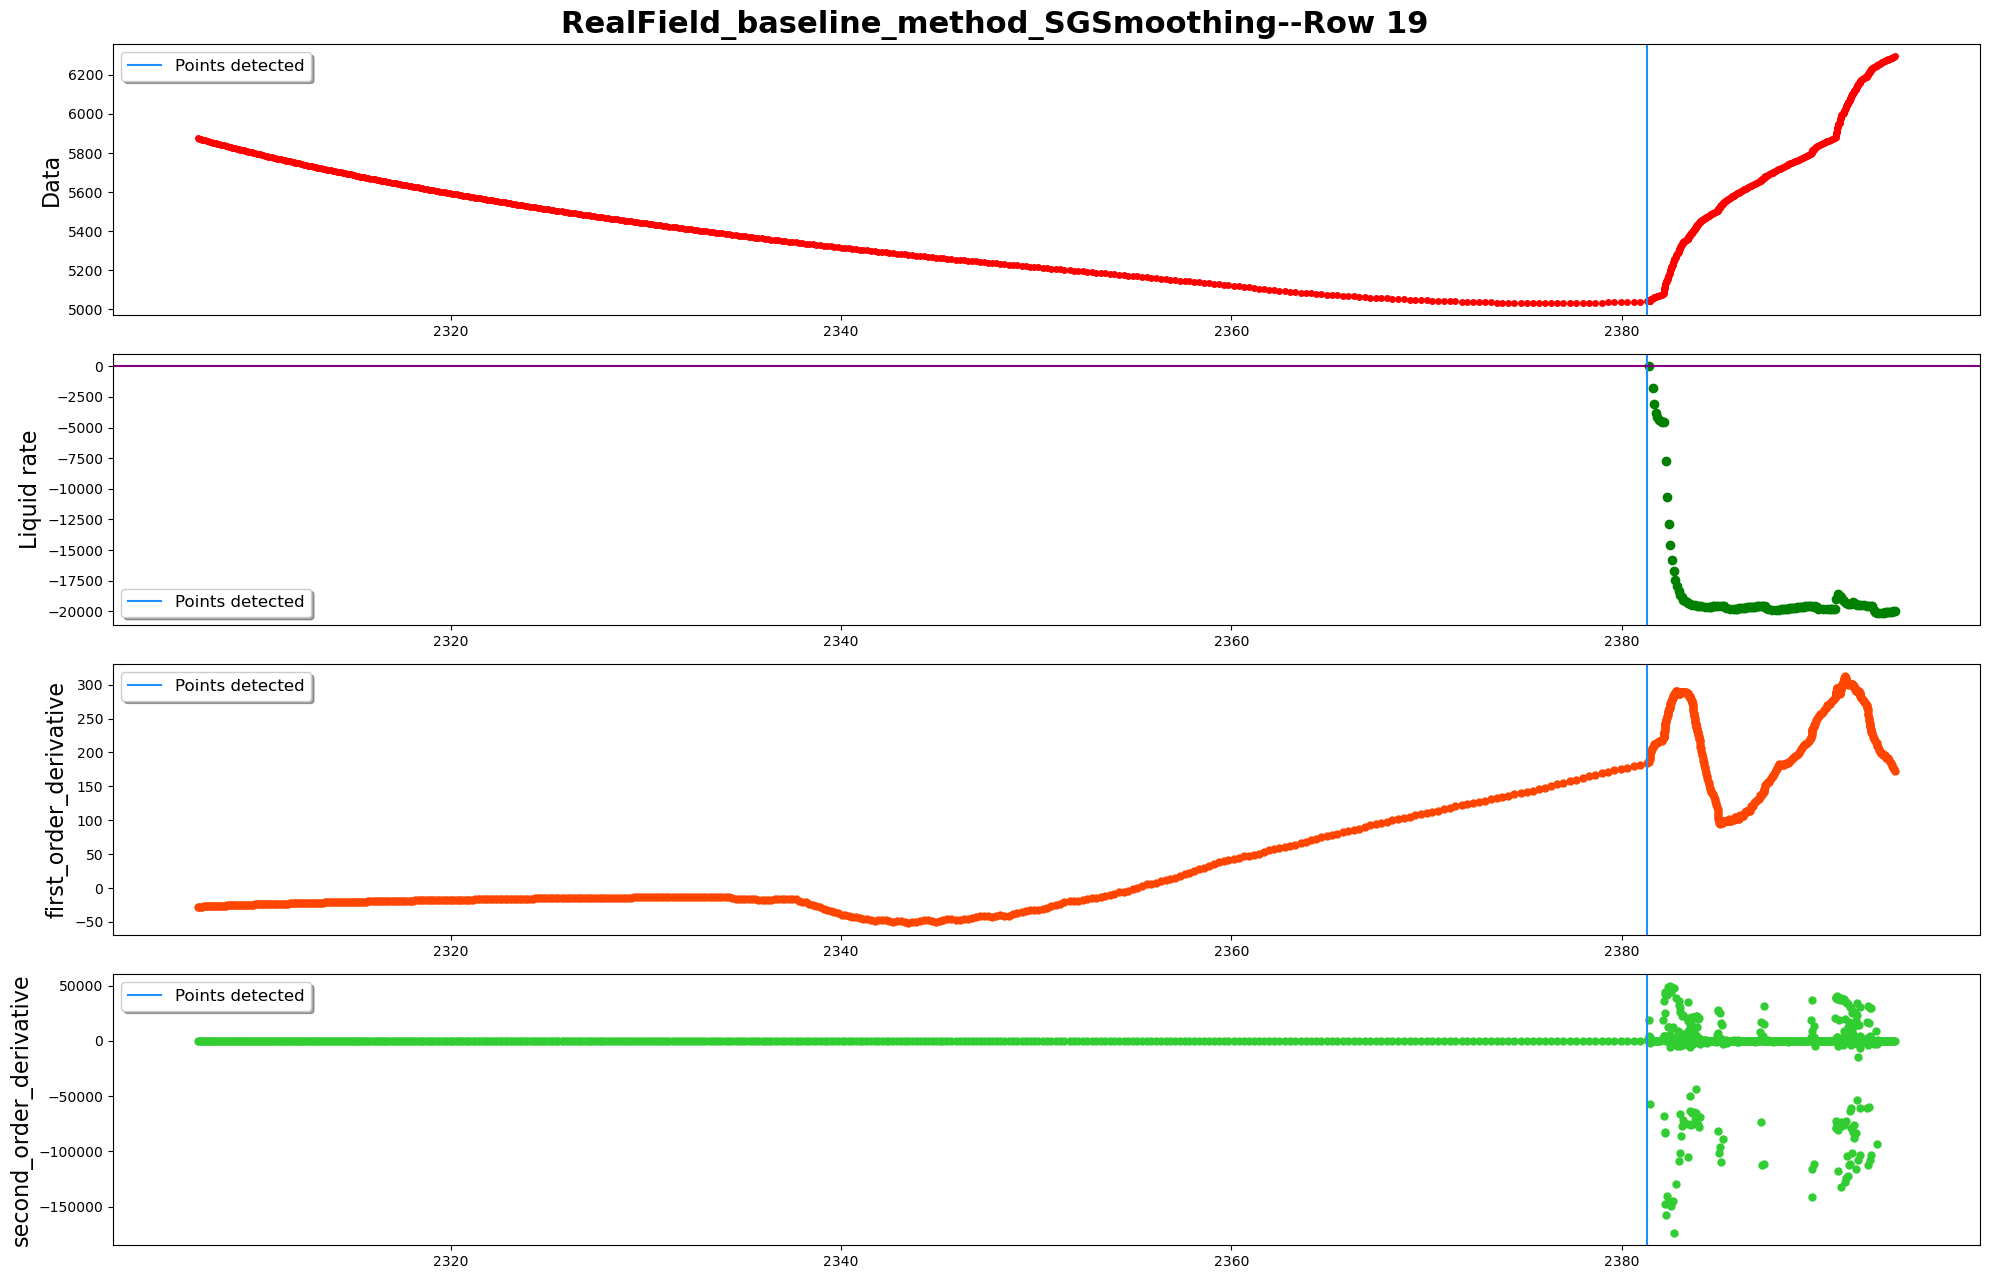

------row 20-----detected points:[19559, 19782, 19783, 19954, 19959]


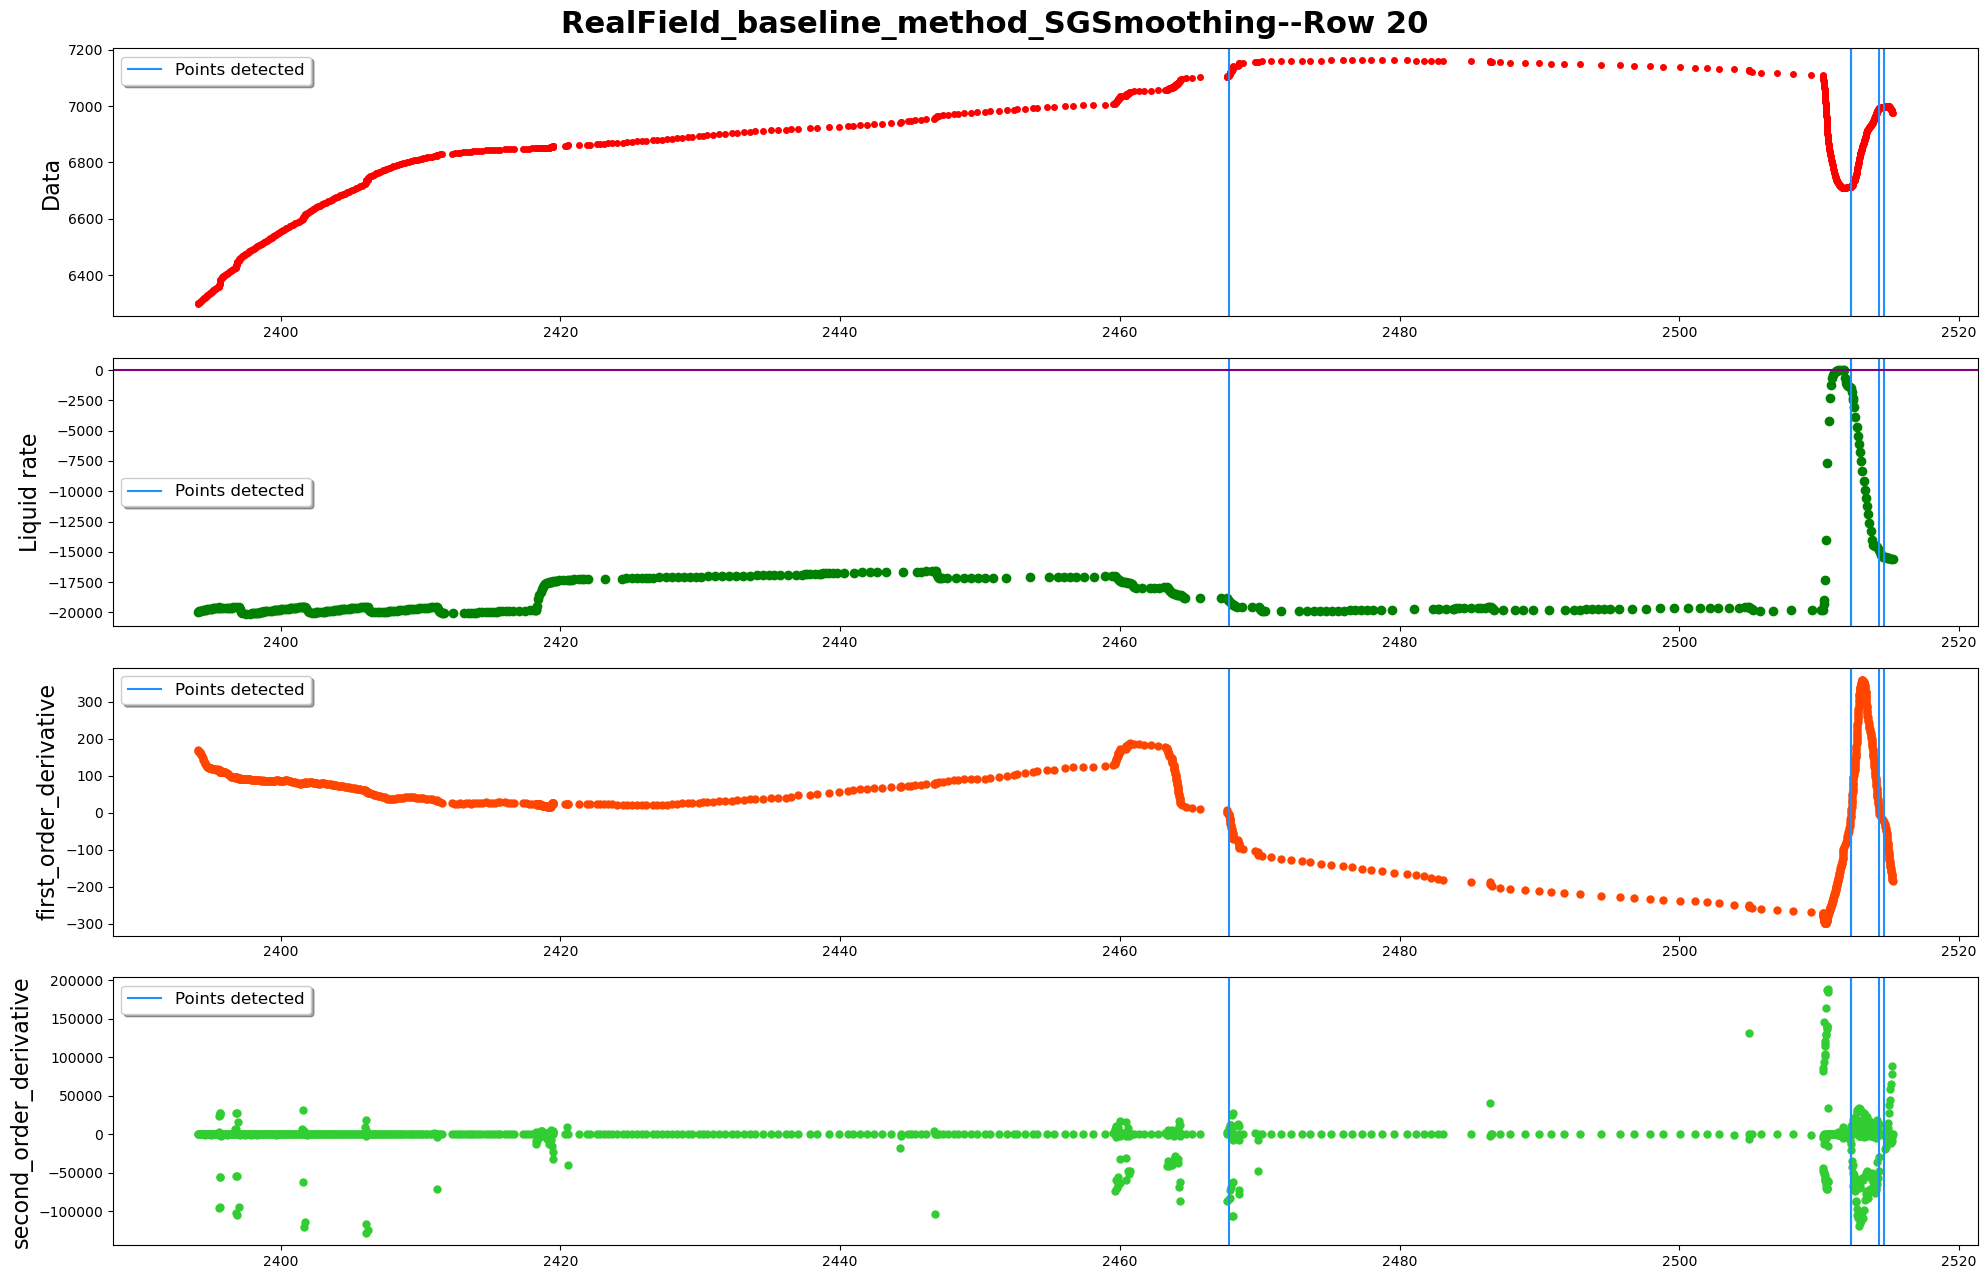

------row 21-----detected points:[20252, 20269, 20598, 20603, 20960, 20964]


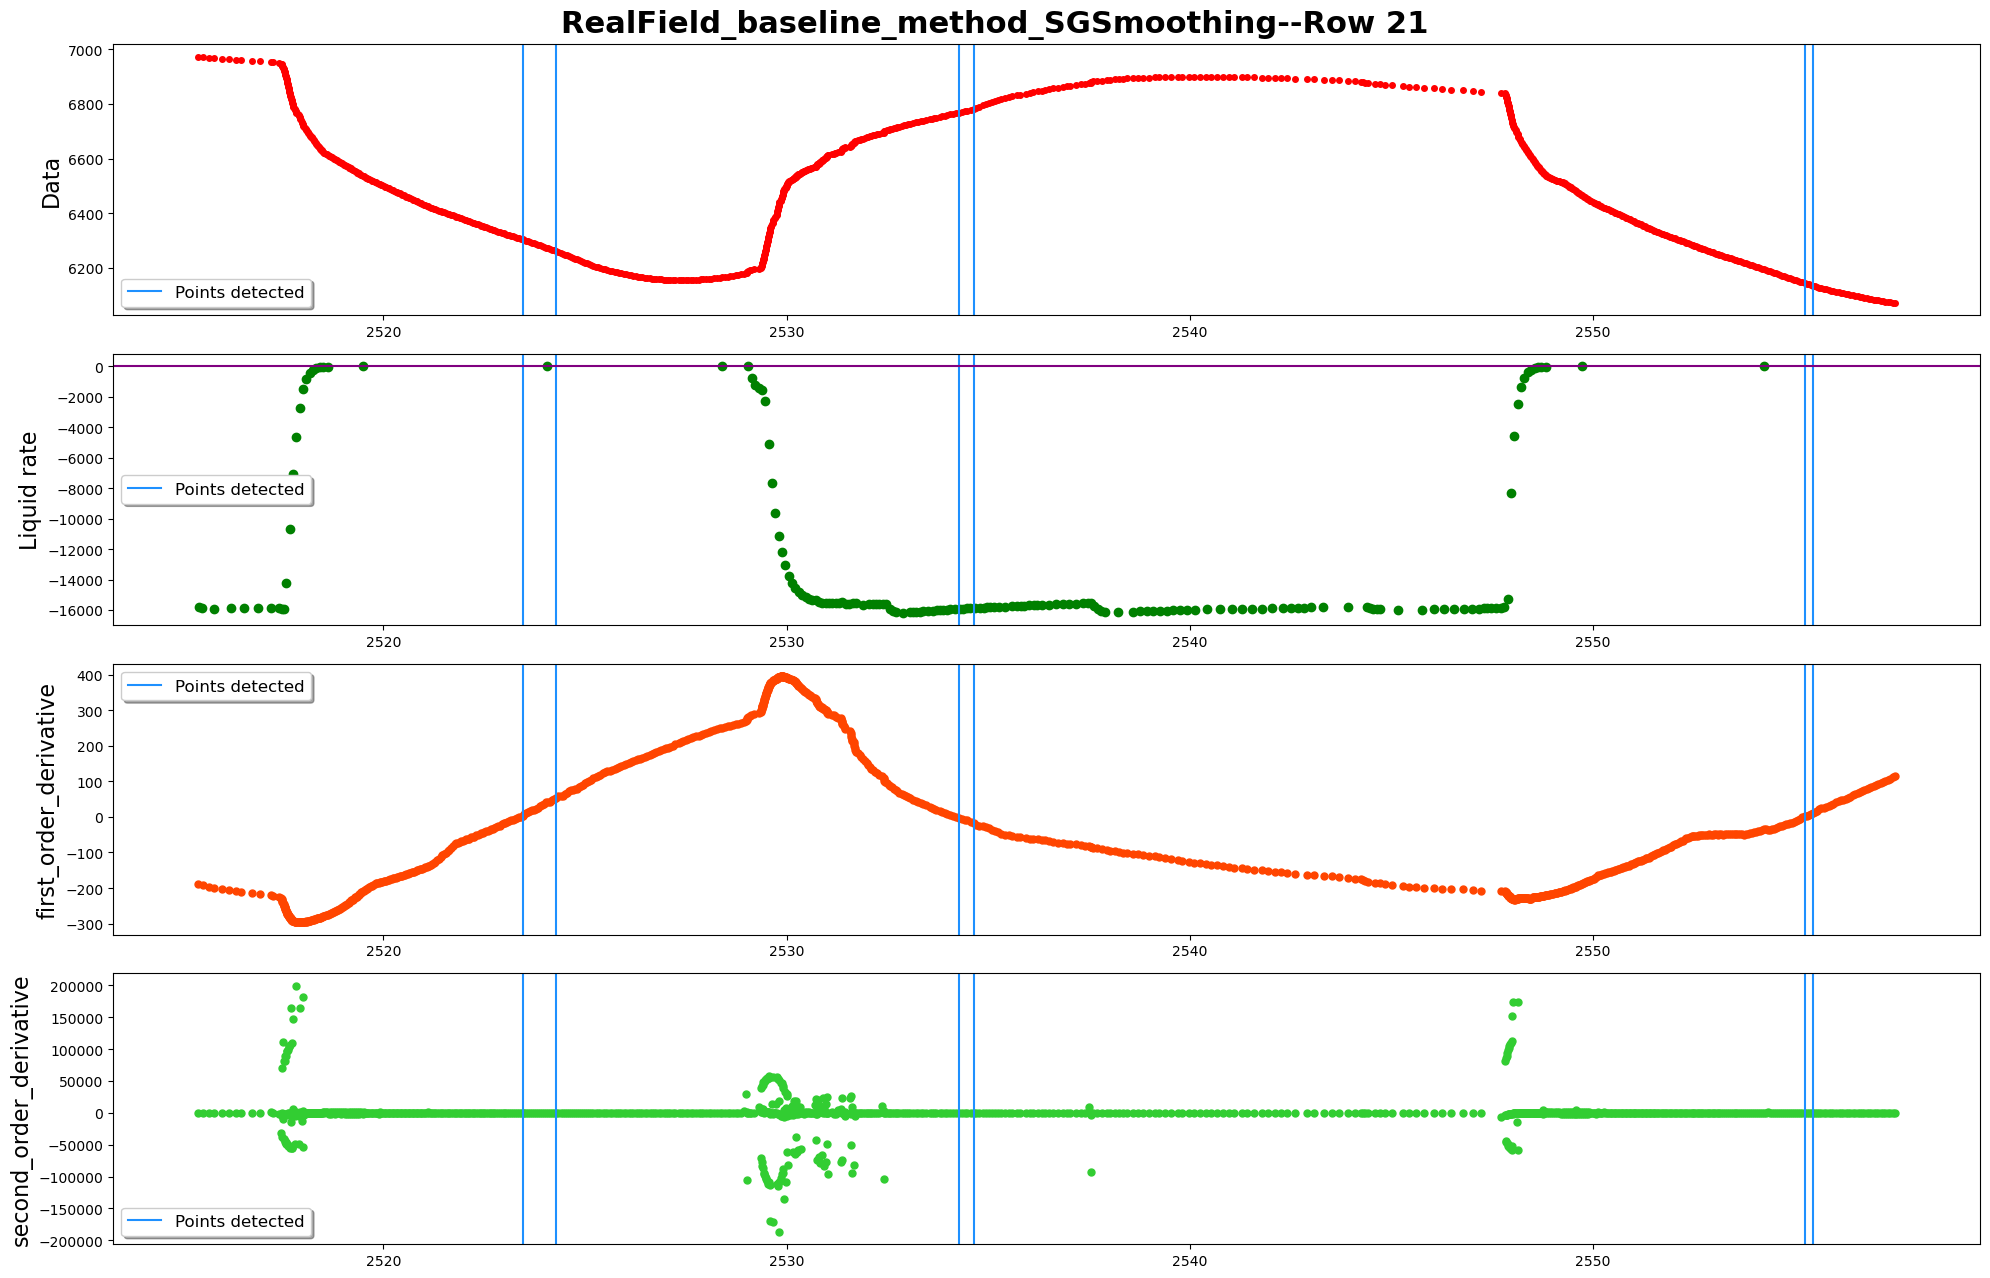

------row 22-----detected points:[21851]


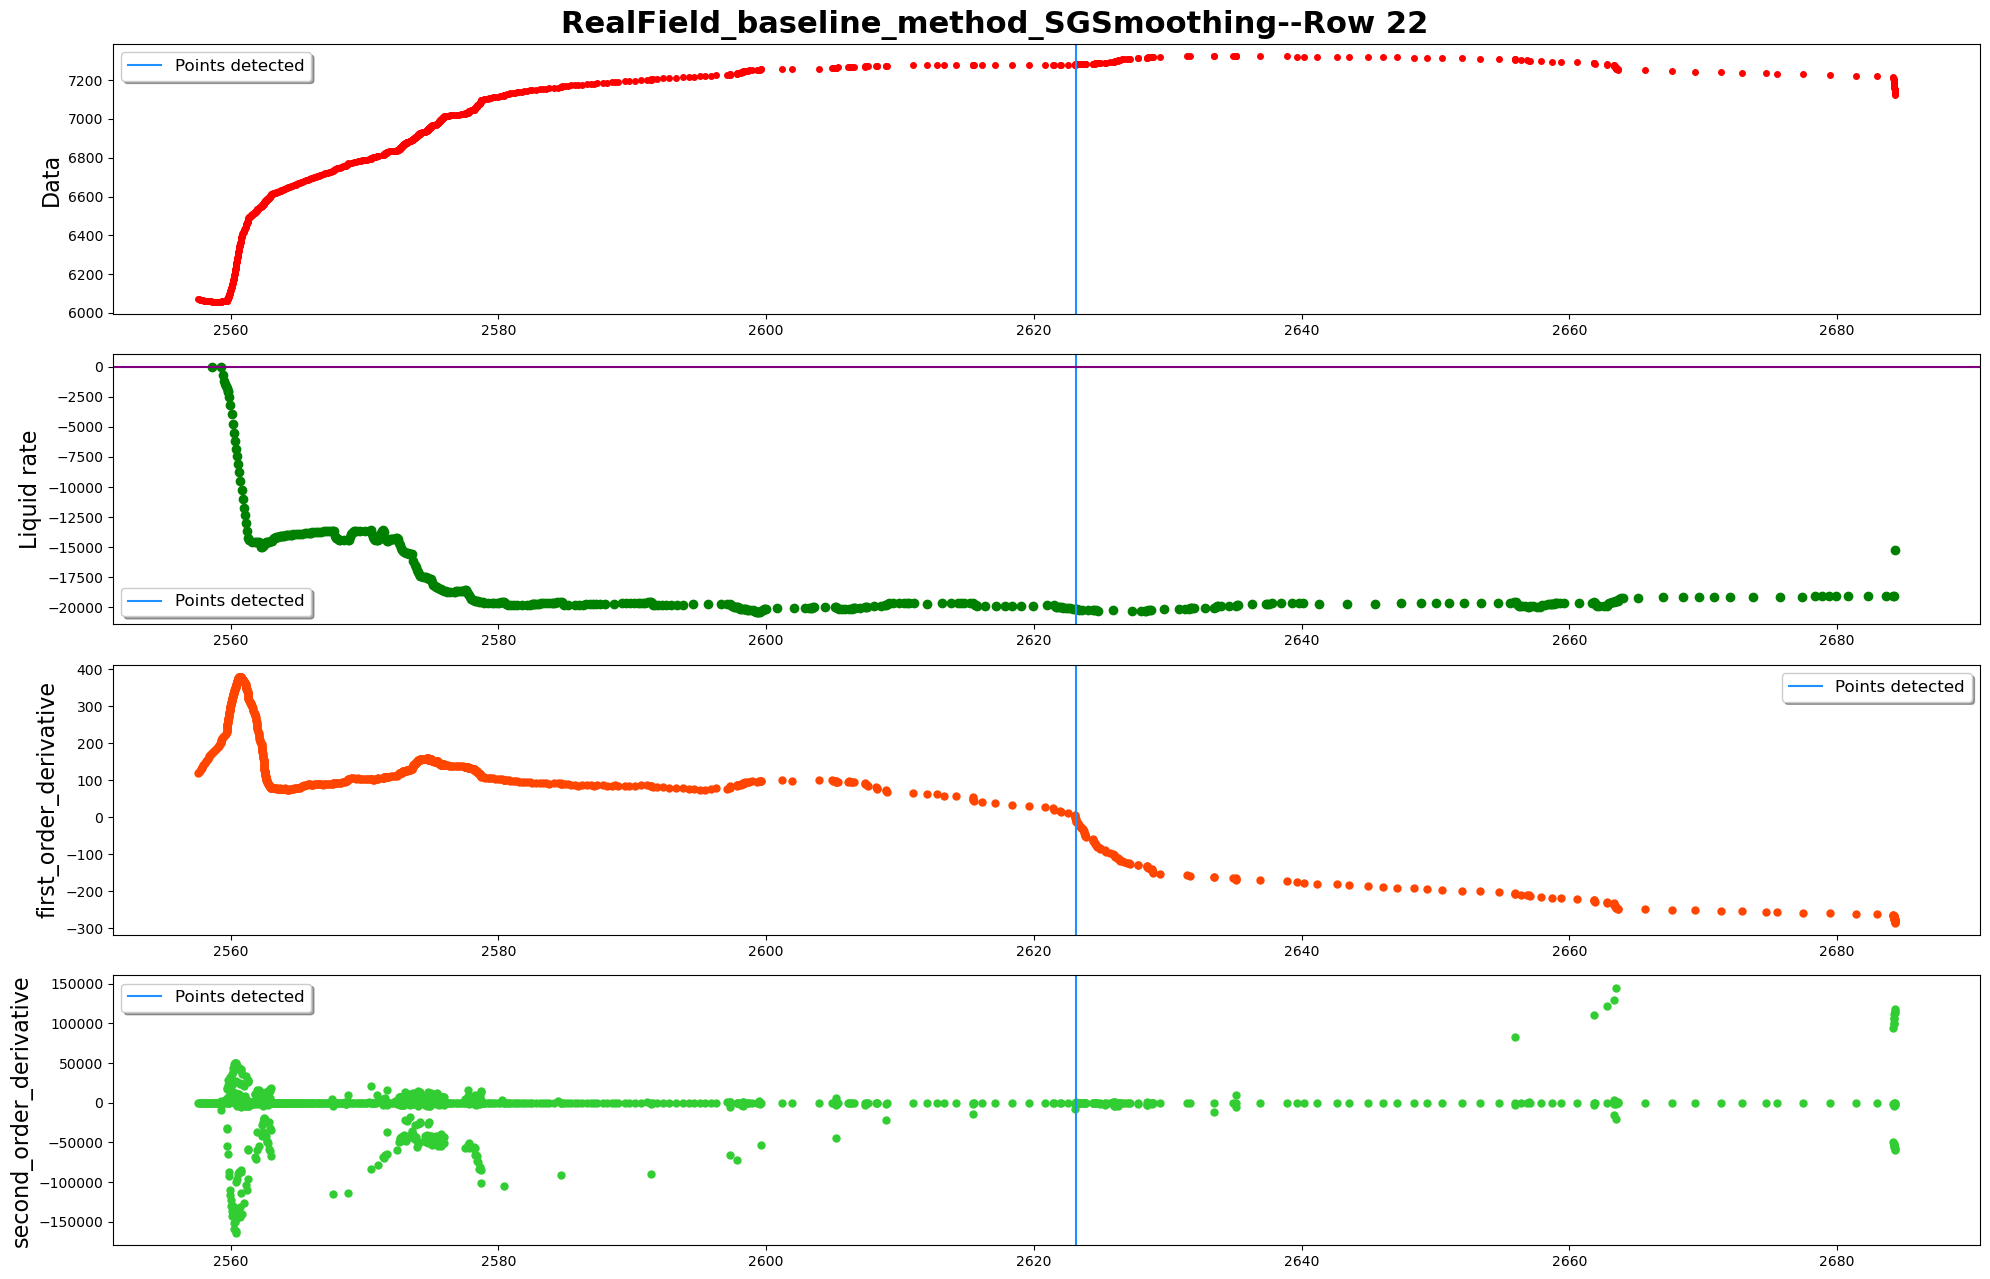

------row 23-----detected points:[22145, 22622, 22623]


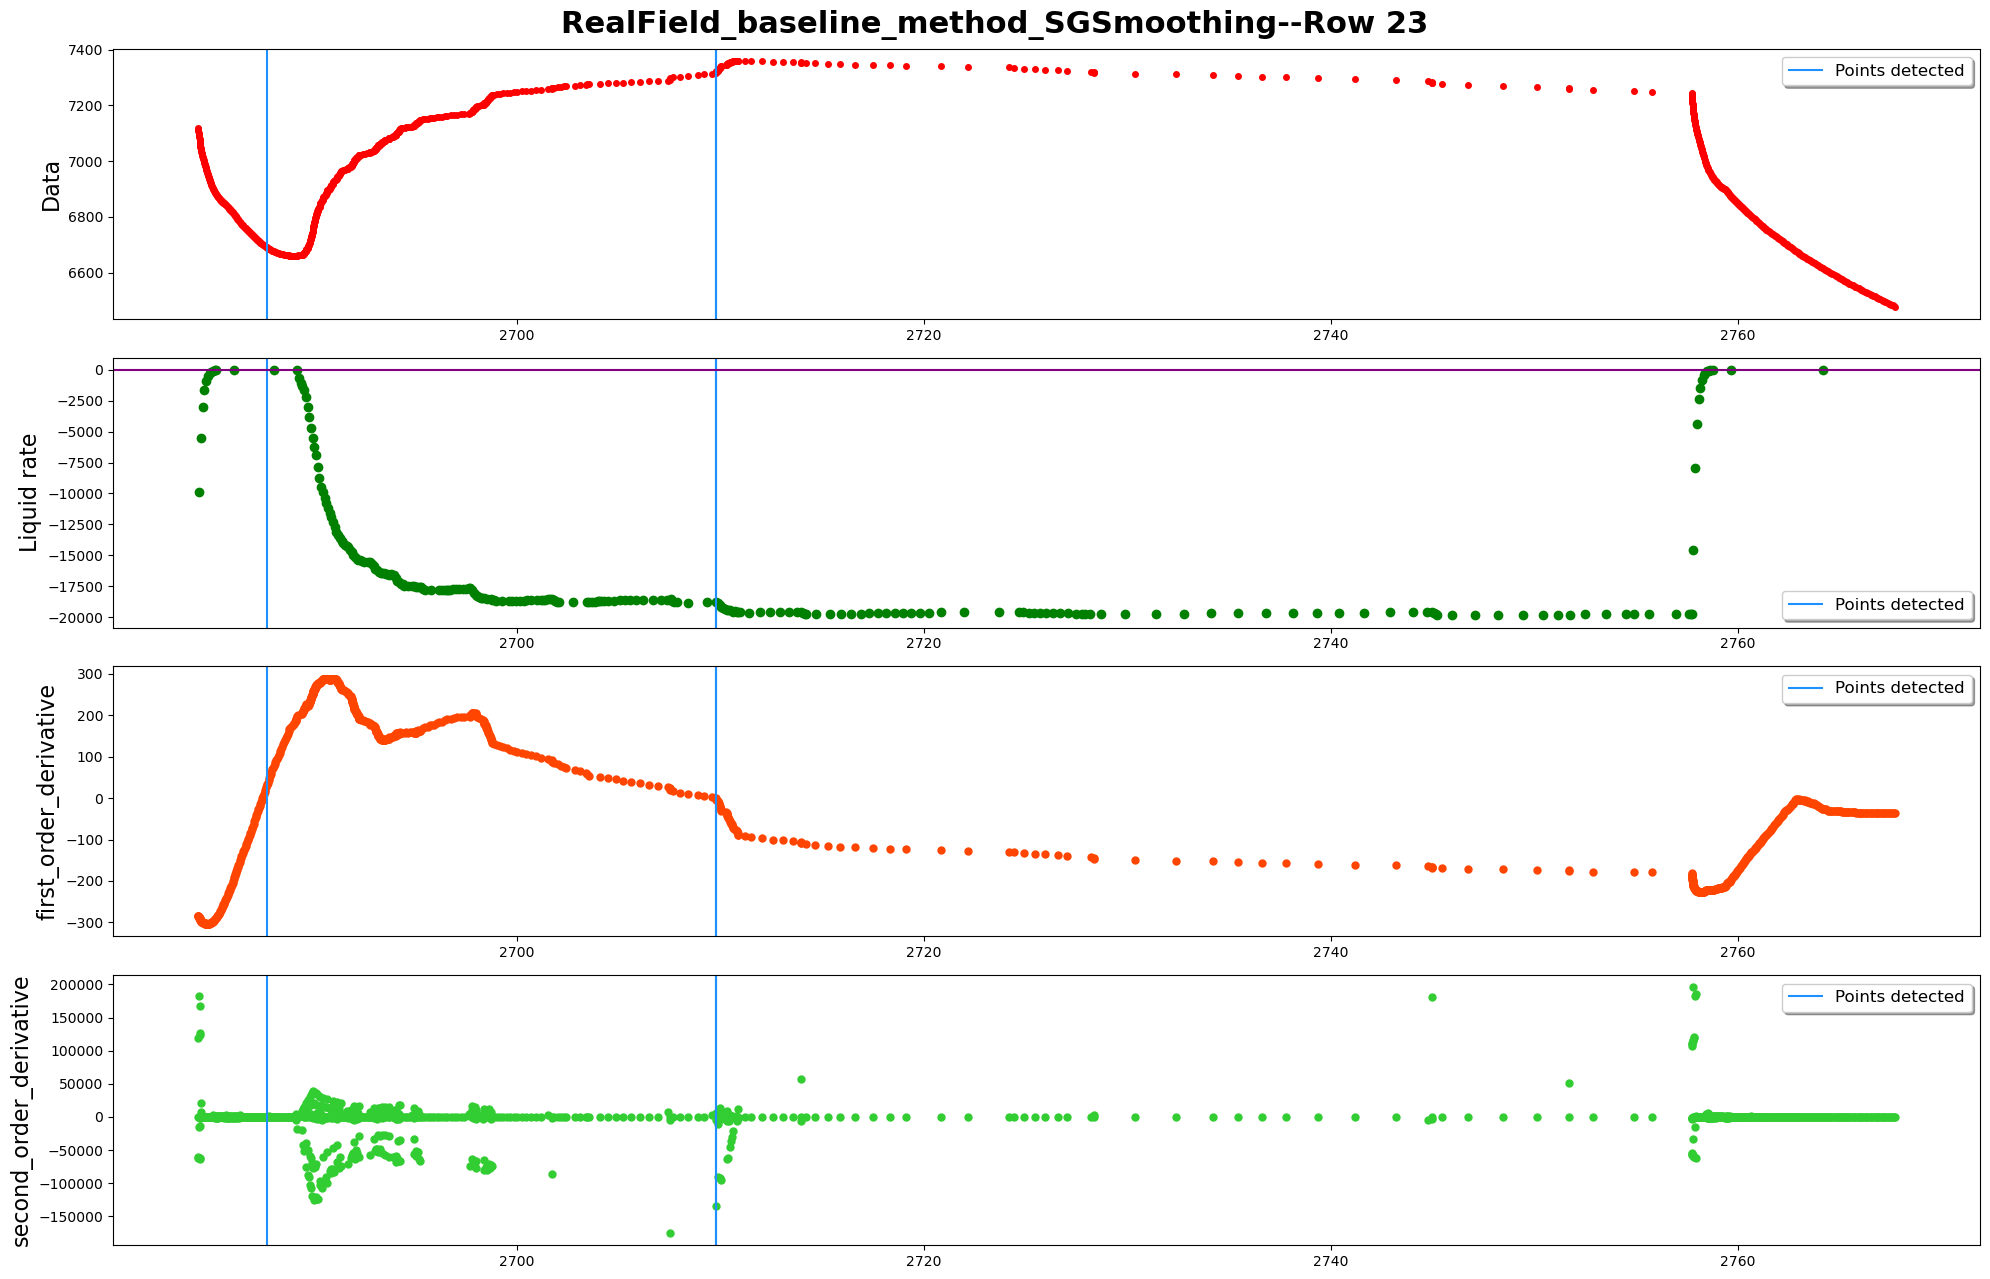

------row 24-----detected points:[23218]


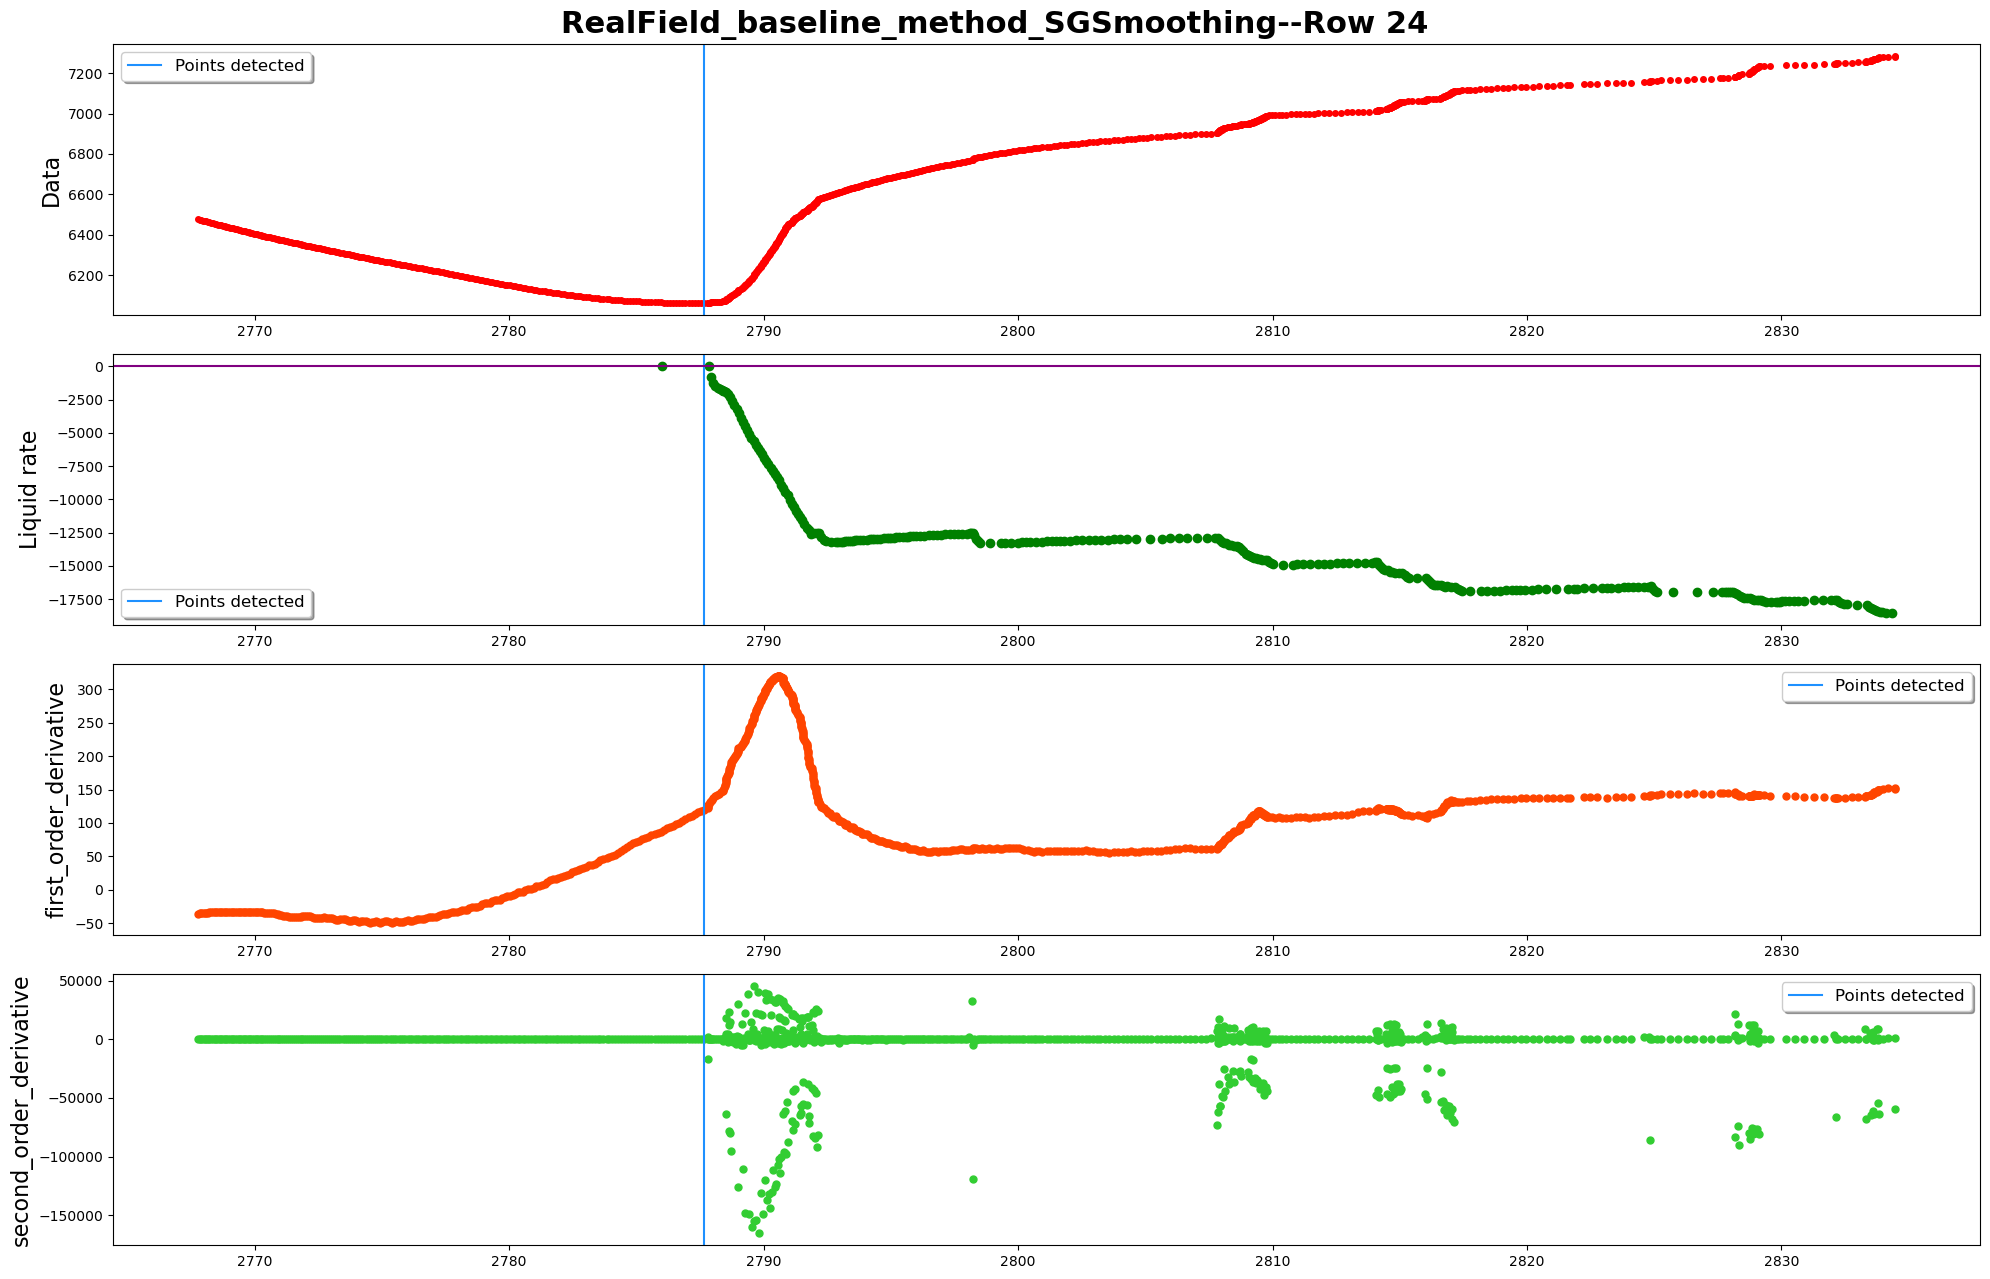

------row 25-----detected points:[24118, 24122, 24672]


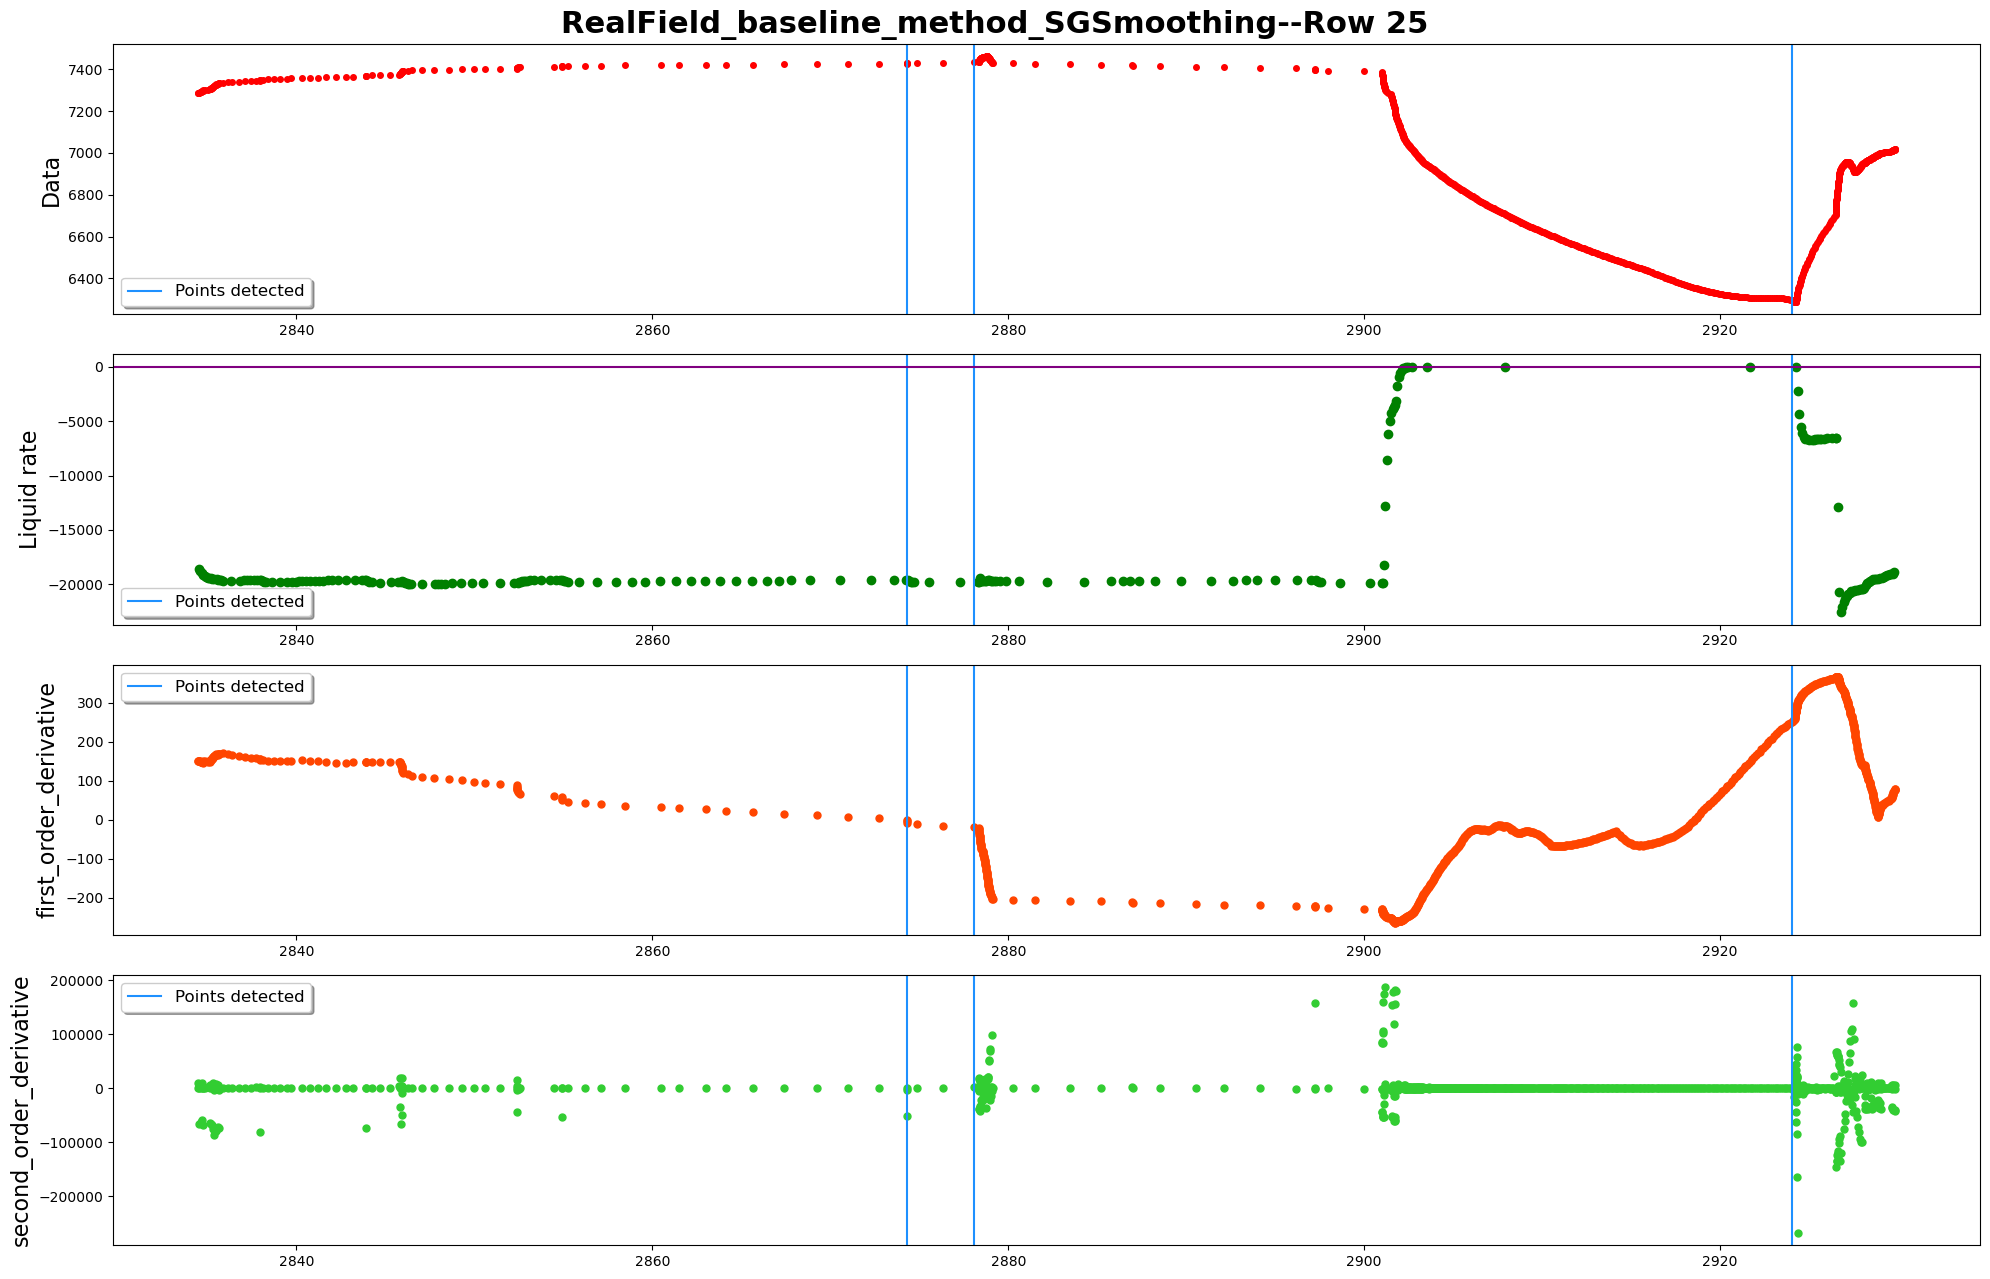

------row 26-----detected points:[25600, 25915, 25922]


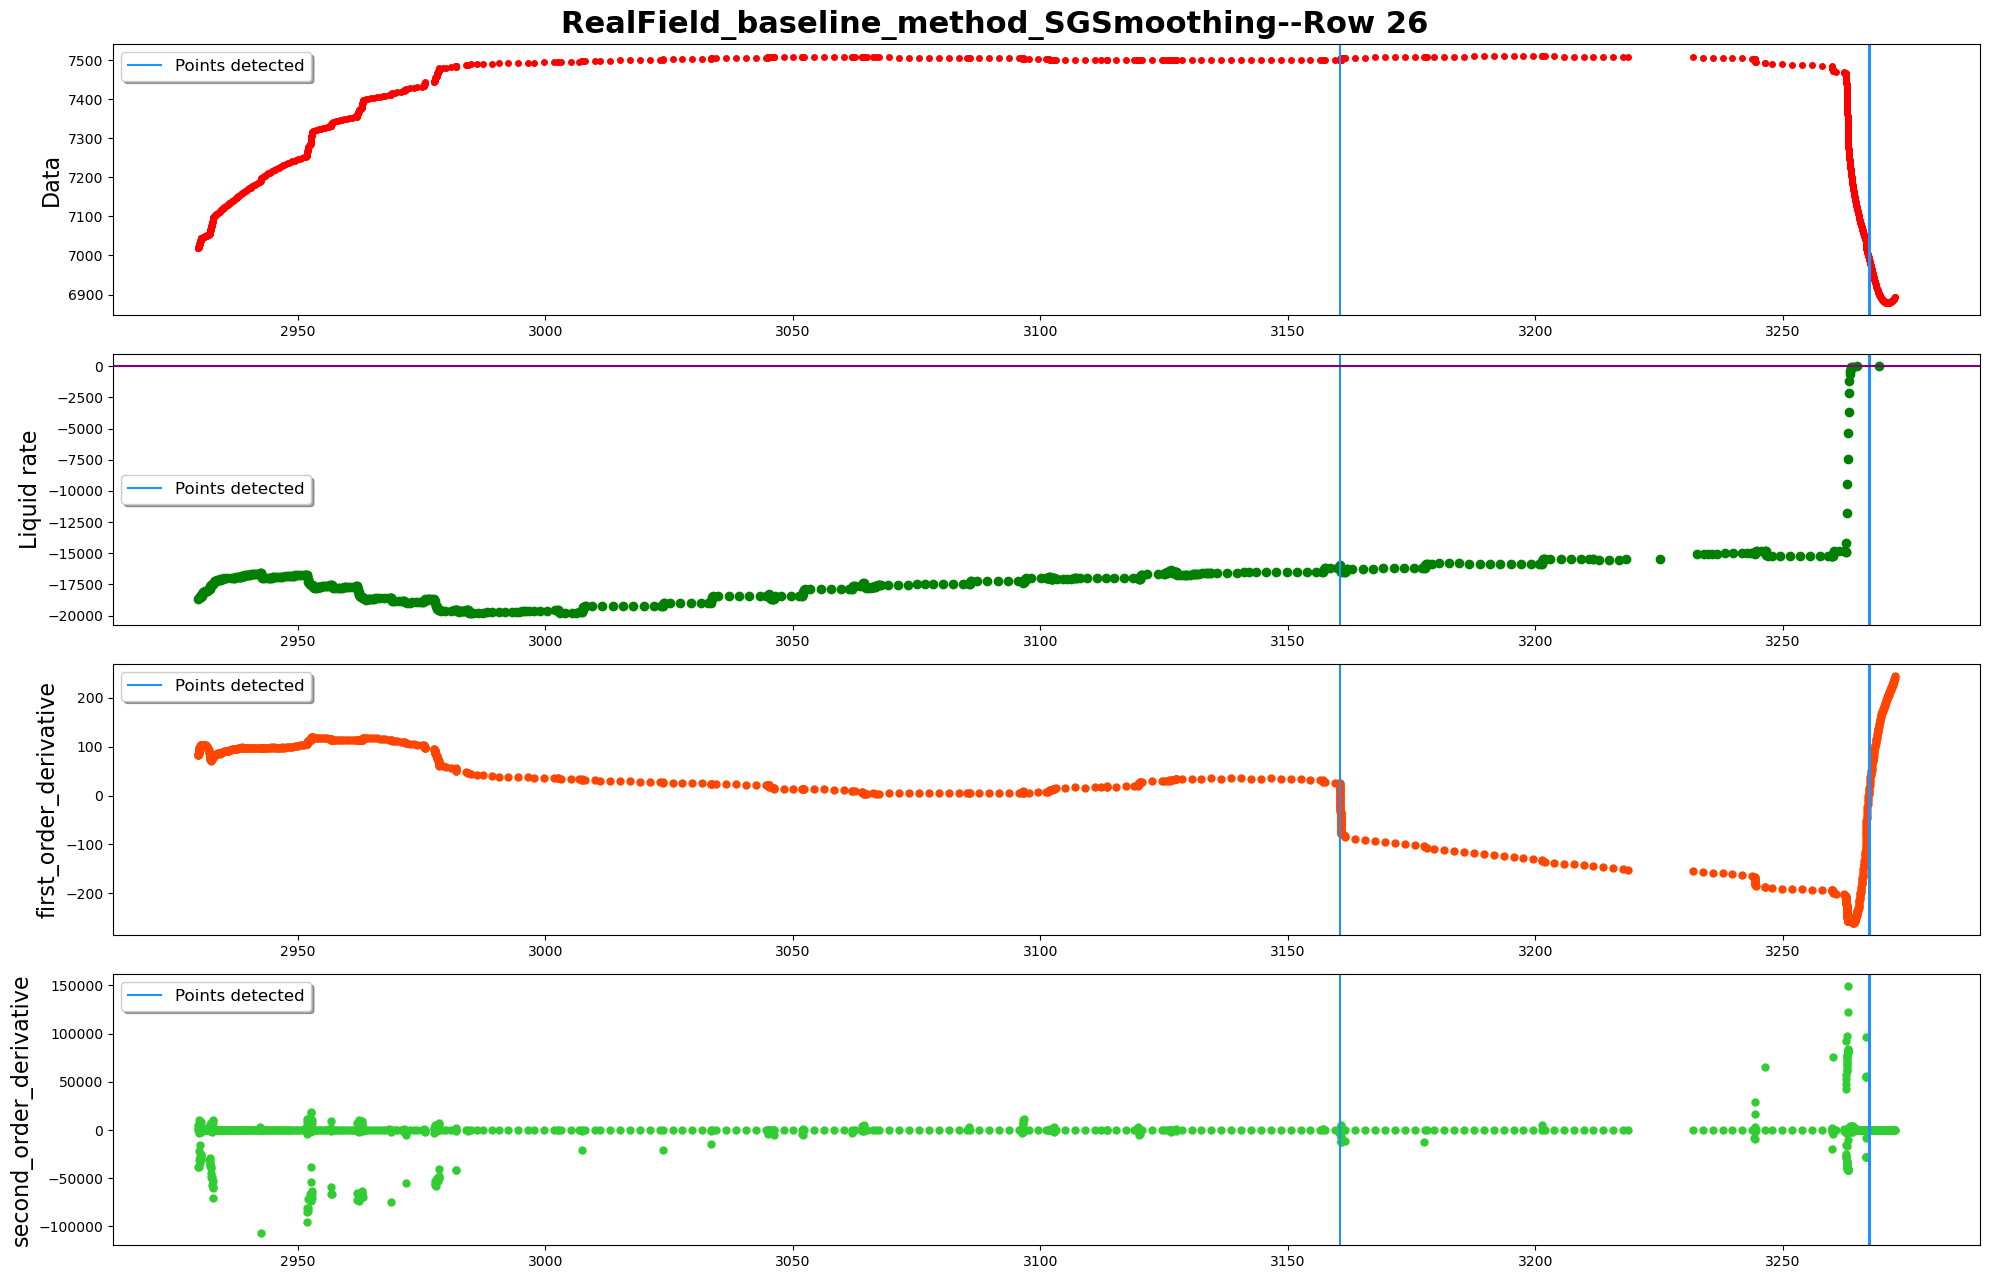

------row 27-----detected points:[26312, 26376, 26604, 26764, 26771, 26933, 26934]


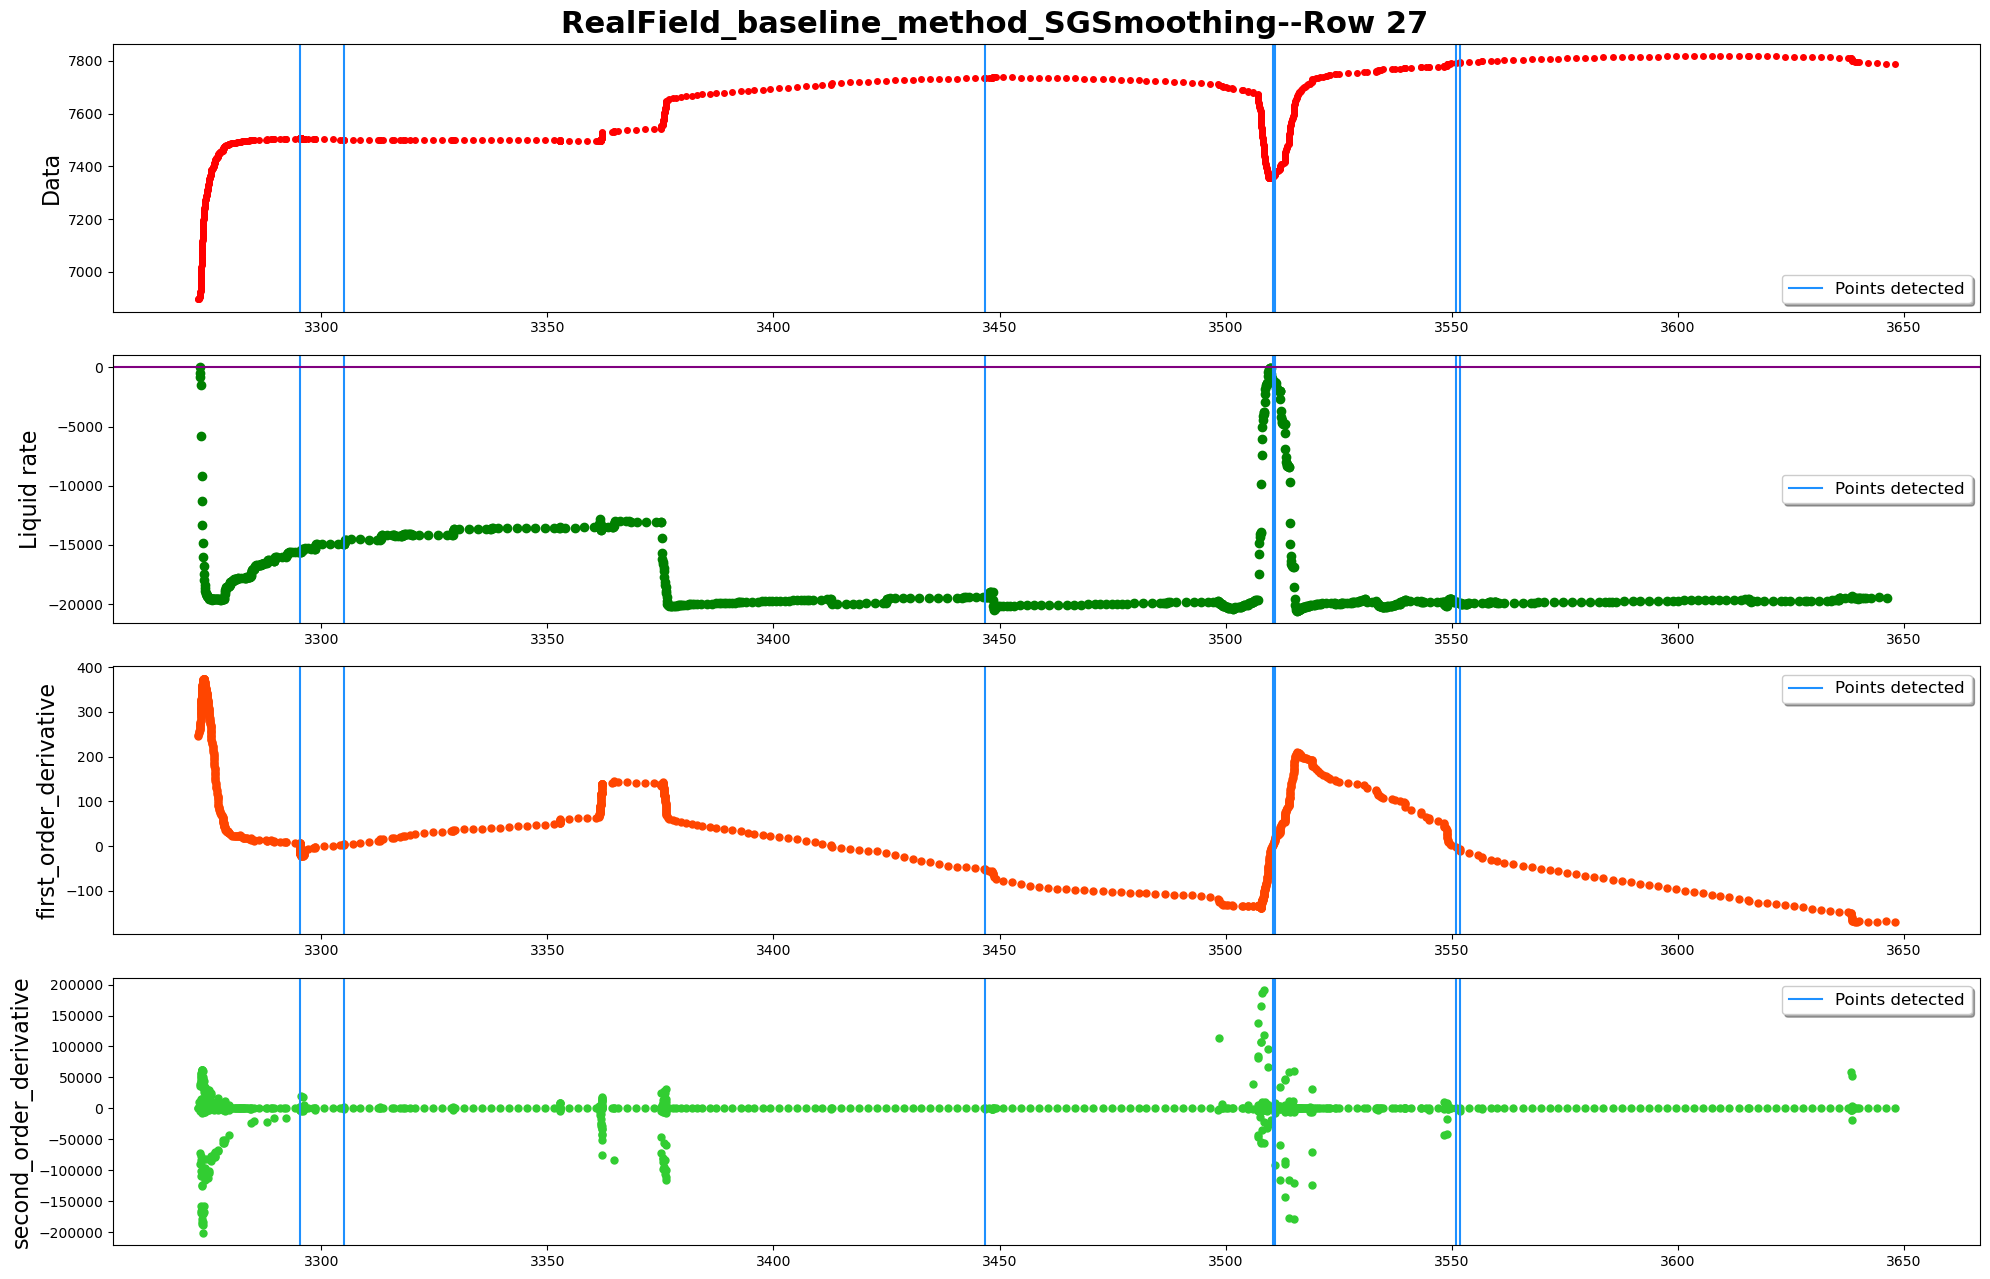

------row 28-----detected points:[27315, 27649, 27681, 27962]


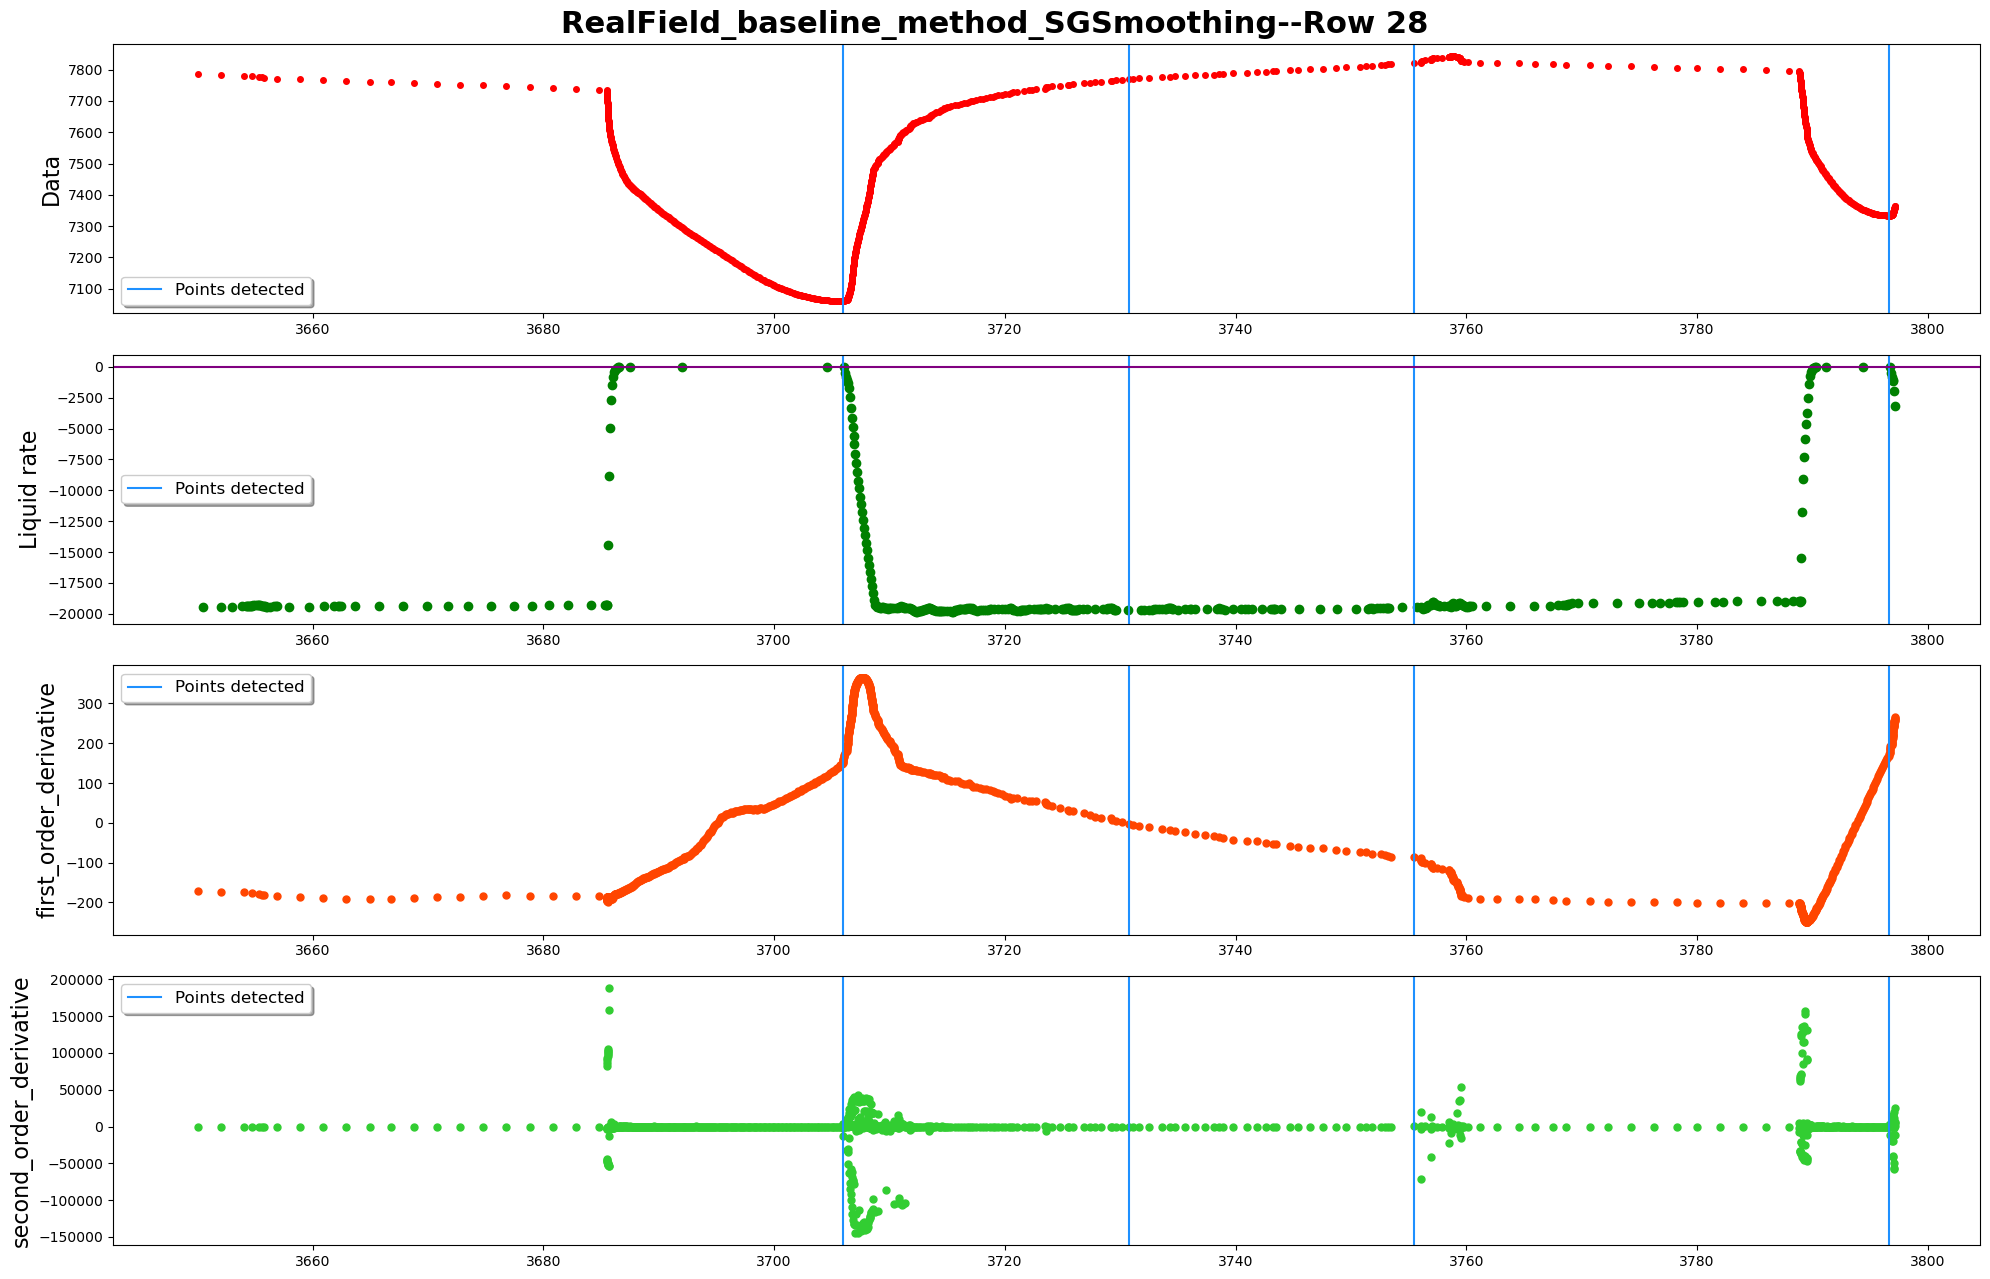

------row 29-----detected points:[28195, 28199, 28487, 28747]


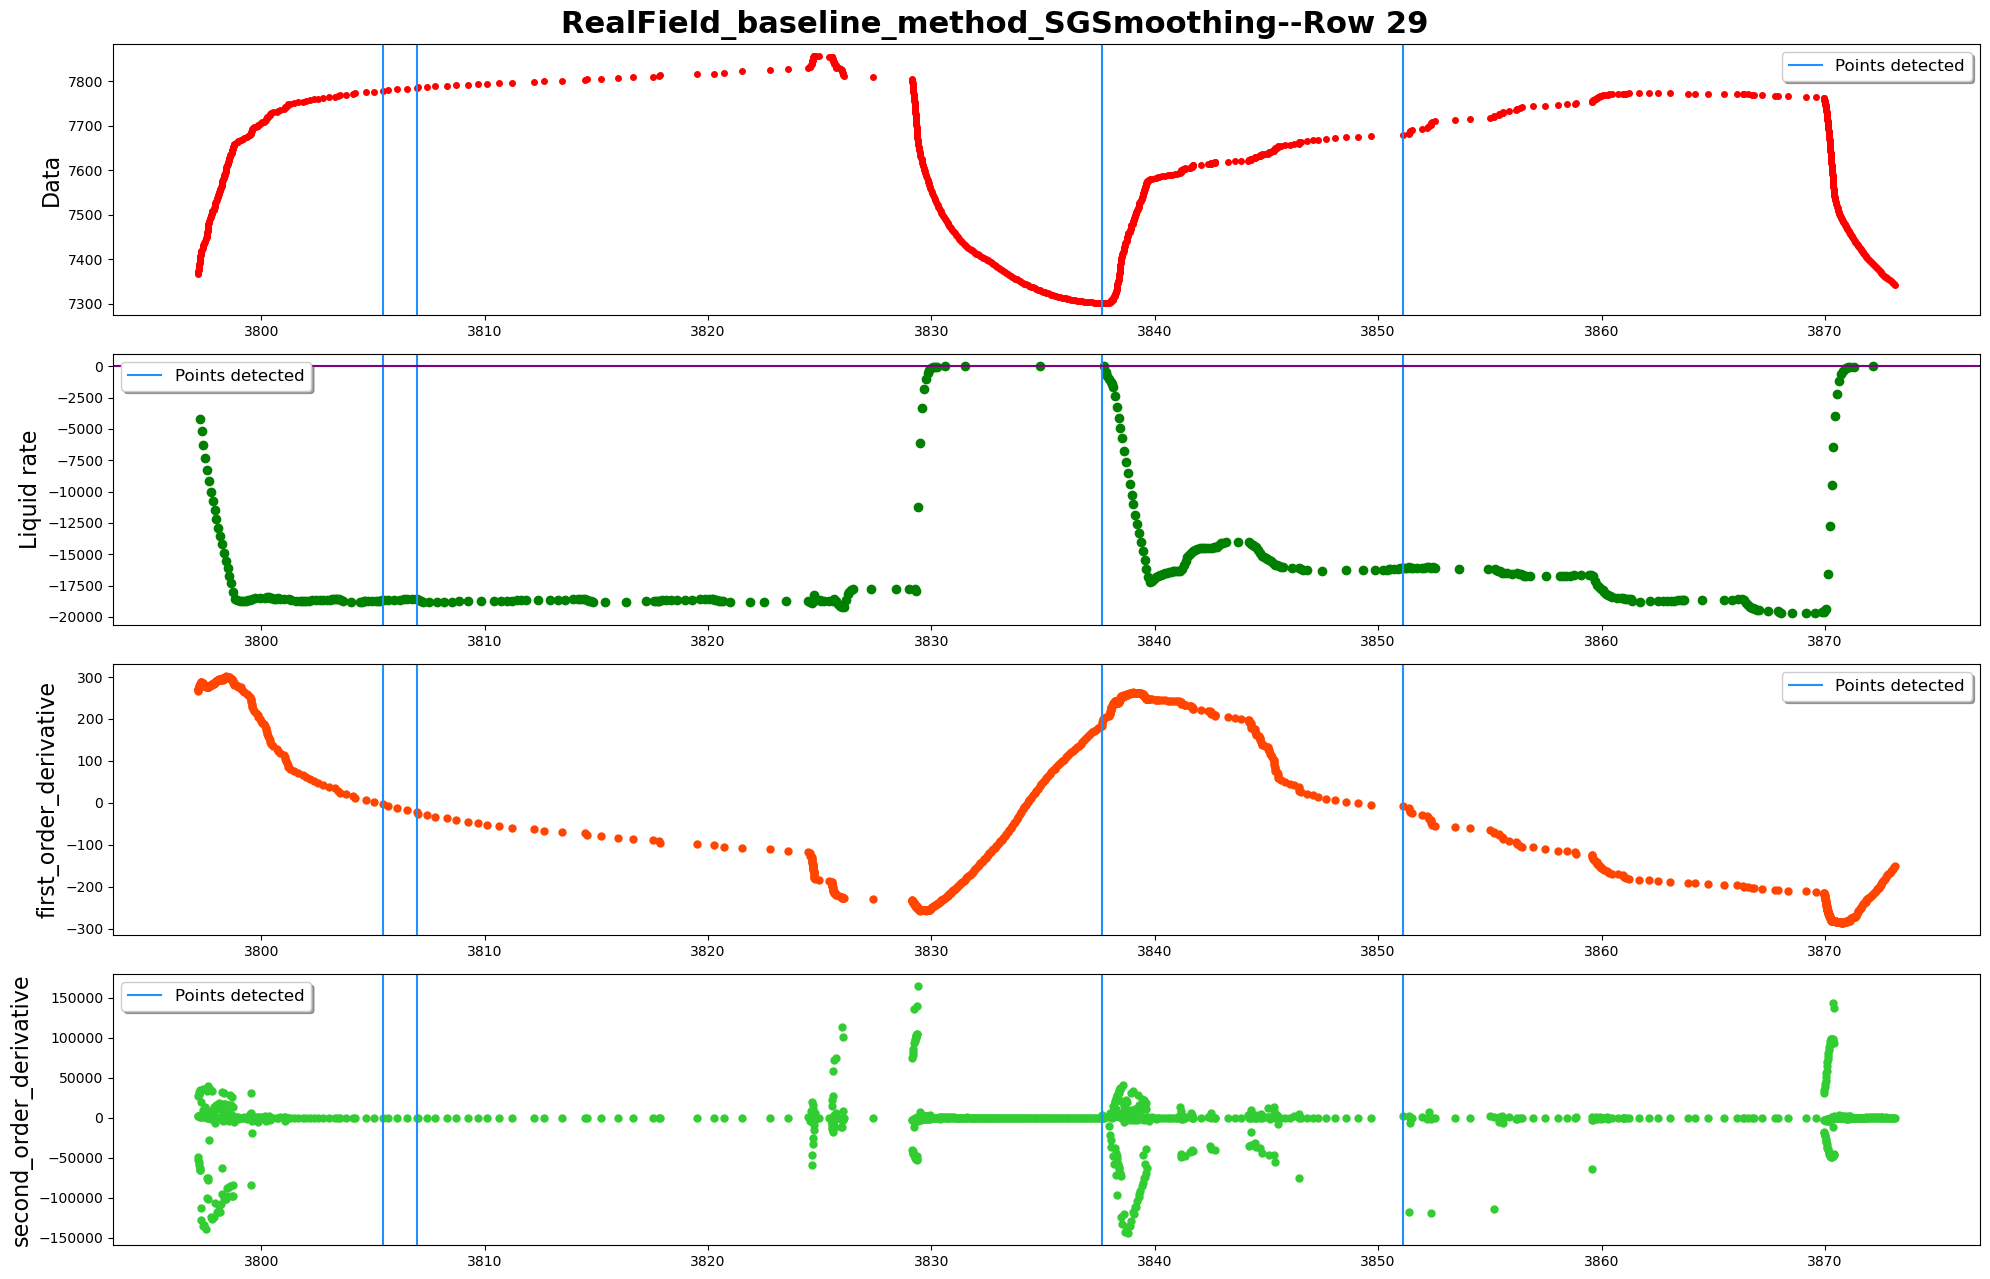

------row 30-----detected points:[29034, 29113]


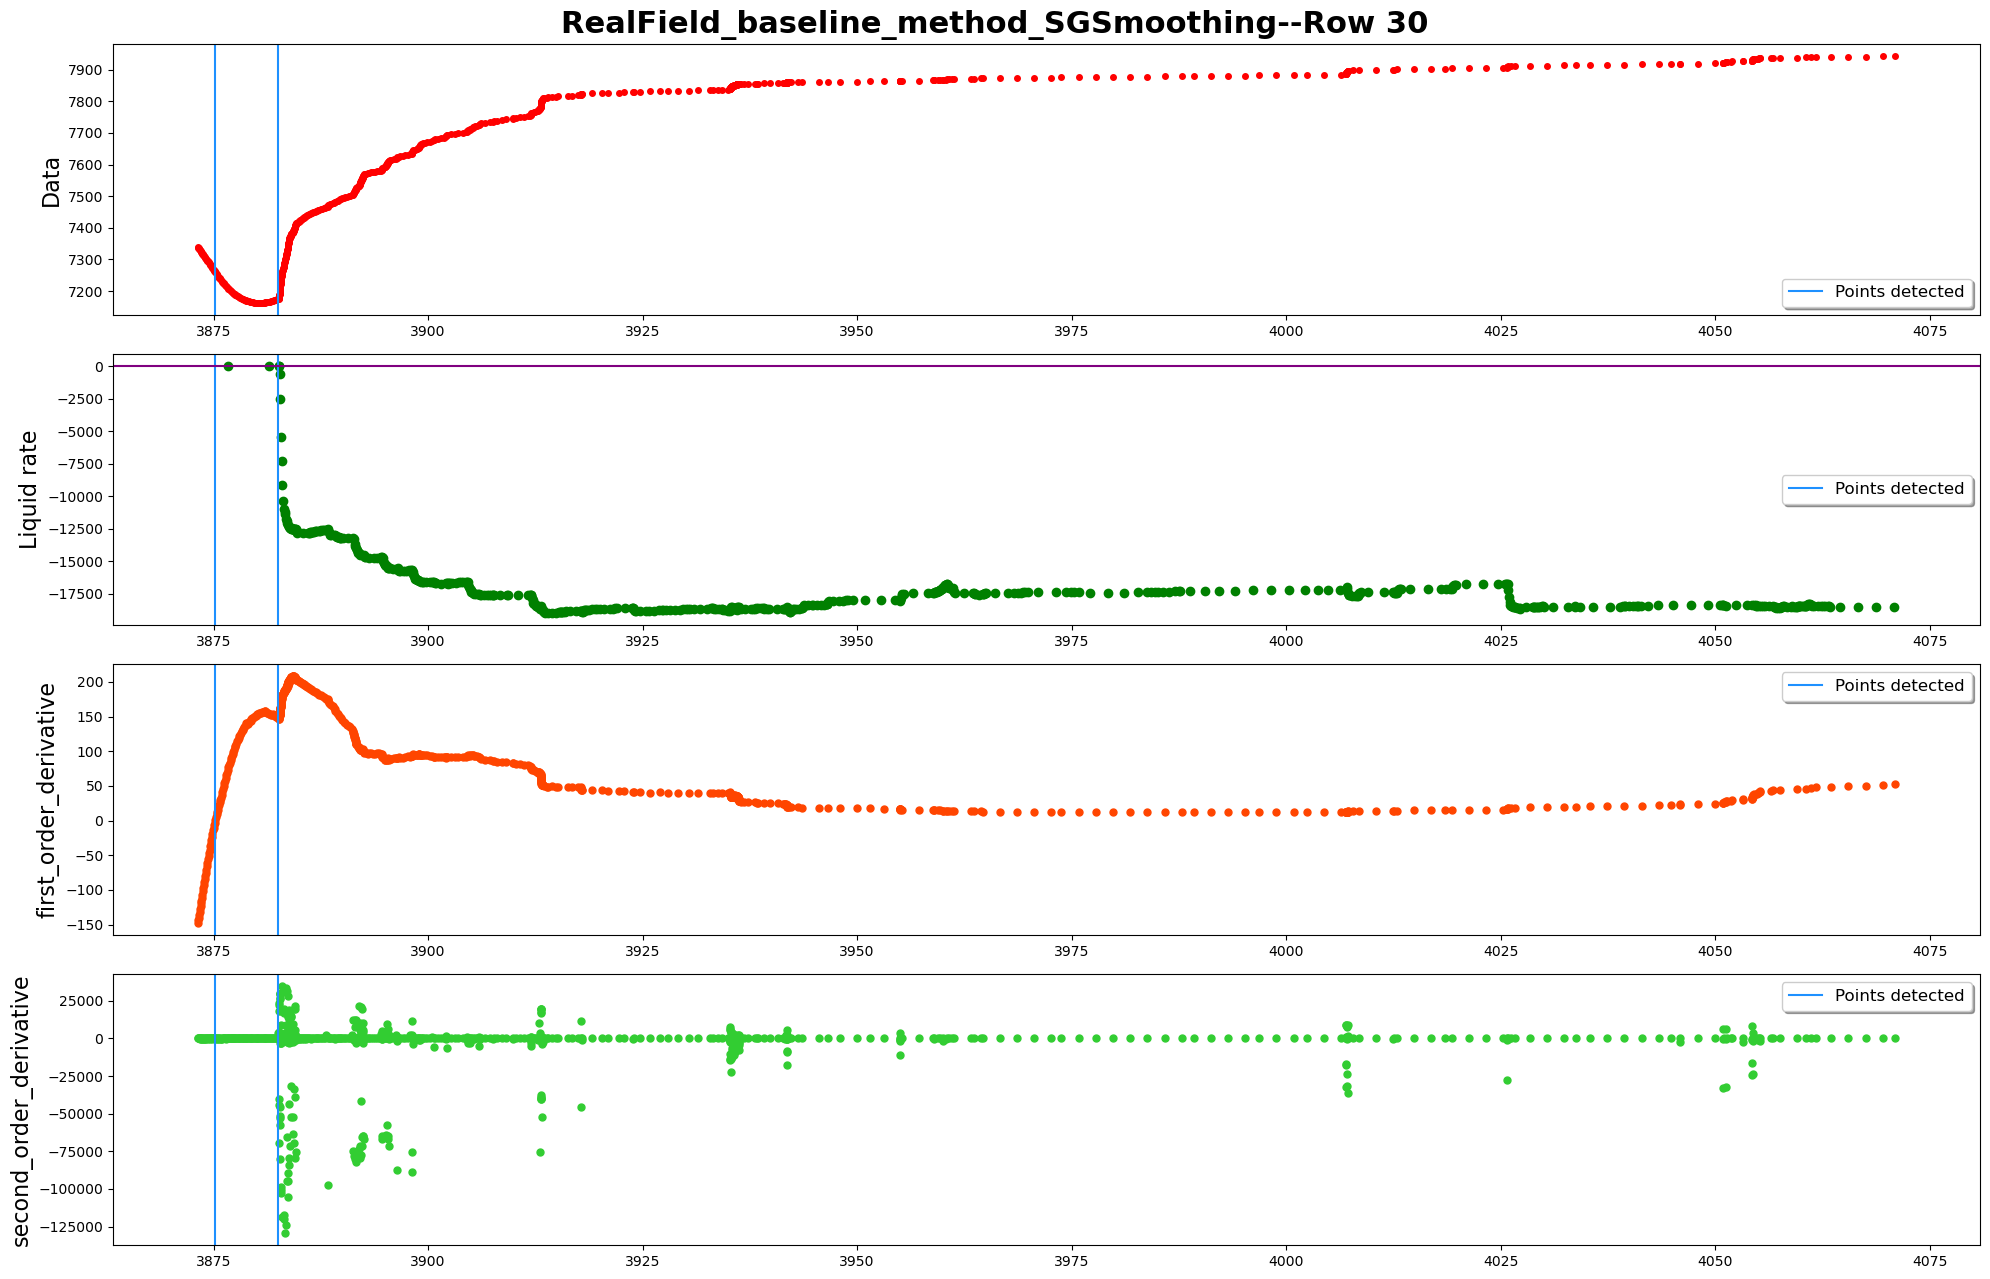

In [14]:
noise_threshold=0.01
breakpoints_detected_3SG=detect_breakpoints_3(first_order_derivative_denoised,second_order_derivative_denoised,noise_threshold)
print(len(breakpoints_detected_3SG))
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_baseline_method_SGSmoothing.pdf"
plot_name="RealField_baseline_method_SGSmoothing"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df_denoised,
          rate_df_denoised,
          breakpoints_detected_3SG,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

In [ ]:

# notin3=[point for point in breakpoints_detected_4SG if point not in breakpoints_detected_3SG]
# print(len(breakpoints_detected_3SG),len(breakpoints_detected_4SG),len(notin3))

In [ ]:
len(breakpoints_detected_3),len(breakpoints_detected_3SG)
index_zero_rate=[index for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
print(index_zero_rate)
indexo_rate=[rate_df.iloc[index]["Elapsed time"] for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
time_zero_rate=[rate_df.iloc[index]["Elapsed time"] for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
len(time_zero_rate),time_zero_rate

In [ ]:
breakpoints_zero_rate=[]
for time_rate in time_zero_rate:
    for index, time_pressure in enumerate(pressure_df["Elapsed time"]):
        if time_pressure>=time_rate:
            breakpoints_zero_rate. append(index)
            break
len(breakpoints_zero_rate) 
breakpoints_zero_rate
zero_rate={"index_zero_rate":index_zero_rate,"breakpoints_zero_rate":breakpoints_zero_rate}
zero_rate_df=pd.DataFrame(data=zero_rate)
zero_rate_df

In [ ]:
rate_df.iloc[1489]["Elapsed time"]
for index, time_pressure in enumerate(pressure_df["Elapsed time"]):
        if time_pressure>=rate_df.iloc[2893]["Elapsed time"]:
            print(index)
            break

In [ ]:
print(len(breakpoints_detected_3+breakpoints_detected_3SG+breakpoints_zero_rate+[5297]))
breakpoints_union=set(breakpoints_detected_3+breakpoints_detected_3SG+breakpoints_zero_rate+[5297]+[10216]+[10528]+[14774]+[16616]+[19764]+[20021]+[21030]+[25717]+[28322])
print(len(breakpoints_union))
# breakpoints_union

In [ ]:
rate_df.iloc[1490], rate_df.iloc[1489]["Elapsed time"]

In [ ]:
a=pressure_df.iloc[10150:10245]["Data"]
min(a)
pressure_df.loc[pressure_df["Data"]==min(a)]
pd.set_option('display.max_rows', pressure_df.shape[0]+1)
display(pressure_df.iloc[10150:10245])
delta=pressure_df.iloc[10151]["Elapsed time"]-pressure_df.iloc[10150]["Elapsed time"]
for i in range(10150,10223):
    t=pressure_df.iloc[i+1]["Elapsed time"]-pressure_df.iloc[i]["Elapsed time"]
    print(i,t,delta)
    if t>delta:
        delta=t
        pointer=i
i

In [ ]:
# data_inOneRow=700
# plot_4_metrics_details(data_inOneRow,
#                        pressure_df,
#                        rate_df,
#                        breakpoints_zero_rate,
#                        ground_truth,
#                        colum_names)

In [ ]:
# data_inOneRow=500
# plot_4_metrics_details(data_inOneRow,
#                        pressure_df,
#                        rate_df,
#                        list(breakpoints_union),
#                        ground_truth,
#                        colum_names)

In [ ]:
bp=28310
pressure_df.iloc[bp-30:bp+30]

In [ ]:
a=[10245, 10499, 10021, 10149, 10150]
b=a.sort()
a,b

In [ ]:
breakpoints_union=set(breakpoints_detected_3SG+breakpoints_zero_rate+[5297]+[10216]+[10528]+[11340]+[12363]+[13868]+[14774]+[16616]+[16098]+[19764]+[20021]+[21030]+[25717]+[28322])
print(len(breakpoints_union))
# breakpoints_union